<a href="https://colab.research.google.com/github/SandraPuig/tfg-BA/blob/main/B1_Ing_dato.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. INGENERÍA DEL DATO BBDD PRINCIPAL:**

### **Fuentes oficiales utilizadas**

- Portal Estadístico de la Comunidad de Madrid: https://www.comunidad.madrid/servicios/estadistica
- Instituto Nacional de Estadística (INE): https://www.ine.es/
- Ministerio de Transportes, Movilidad y Agenda Urbana: https://www.mitma.gob.es/
- PyTrends (Google Trends API): https://github.com/GeneralMills/pytrends

> Todas las variables provienen de datos abiertos oficiales, del último año disponible.


In [ ]:
#--------- ÍNDICE ---------
# 1. Librerías & Carga del Dataset
# 2. Cálculo de las Variables Derivadas
# 3. Limpieza Inicial
# 4. Detección y Tratamiento de Outliers (winsorizing + zscore)
# 5. Análisis de Skew & Transformación Logarítmica
# 6. Selección Variables Finales
# 7. Escalado Final
# 8. Validación Técnica Final
# 9. Análisis Exploratorio


### **B1 - PRESENTACIÓN INICIAL**

In [ ]:
#--------- INSTALAMOS LAS LIBRERÍAS ---------
!pip install openpyxl
!pip install feature_engine

# Librerías de análisis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Estadística y preprocesamiento
from scipy.stats import skew, zscore
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Visualización en Jupyter
from IPython.display import display, HTML, Markdown

# Feature engineering
from feature_engine.outliers import Winsorizer


In [ ]:
# --------- CARGA DEL DATASET ---------
df = pd.read_excel('/content/Final BBDD.xlsx', sheet_name='mi base de datos')

# Estandarizar nombres de columnas
df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
    .str.replace('á', 'a')
    .str.replace('é', 'e')
    .str.replace('í', 'i')
    .str.replace('ó', 'o')
    .str.replace('ú', 'u')
    .str.replace('ñ', 'n')
)


#--------- INFORMACIÓN INICIAL ---------
# Guardar original para recuperación de columnas
df_completo = df.copy()

# Información general
print("Información básica del conjunto de datos:")
print(f"- Observaciones: {df.shape[0]}")
print(f"- Variables: {df.shape[1]}")
print("\nTipos de variables:\n", df.dtypes.value_counts())
df.dtypes

Información básica del conjunto de datos:
- Observaciones: 200
- Variables: 42

Tipos de variables:
 int64      20
float64    19
object      3
Name: count, dtype: int64


municipio_cm                  object
id_cm                         object
distrito_cm                   object
preciom2_compra                int64
preciom2_alquiler            float64
rentabilidad_bruta           float64
superficie_cm                float64
densidad_cm                  float64
poblacion_cm                   int64
pob_empadronada                int64
pob_extranjeros                int64
grado_extranj                float64
edad_media                   float64
tasa_natalidad               float64
tasa_mortalidad              float64
grado_envejecimiento         float64
grado_juventud               float64
renta_media                  float64
pib_percapita                  int64
afilidados_ss                  int64
contratos_registrados          int64
tasa_paro                    float64
tasa_paro_m                  float64
tasa_paro_h                  float64
nalumnos_cescolar              int64
alumnos_cpublico               int64
alumnos_cprivado               int64
alumnos_regespecial            int64
centrosescolares               int64
centro_salud                   int64
nfarmacias                     int64
ncentro_serviciossociales      int64
total_transportepb             int64
estaciones_metro               int64
estaciones_trencercanias       int64
paradas_bus                    int64
n_biblios                      int64
transacciones_total          float64
transacciones_nueva          float64
transacciones_segmano        float64
transacciones_libre          float64
transacciones_protegida      float64
dtype: object

### **B2 - CÁLCULO DE VARIABLES DERIVADAS**

In [ ]:
#--------- NORMALIZAR NOMBRES DE COLUMNAS -----------
df.columns = [col.lower() for col in df.columns]
print("Variables del DataFrame:\n", df.columns.tolist())

Variables del DataFrame:
 ['municipio_cm', 'id_cm', 'distrito_cm', 'preciom2_compra', 'preciom2_alquiler', 'rentabilidad_bruta', 'superficie_cm', 'densidad_cm', 'poblacion_cm', 'pob_empadronada', 'pob_extranjeros', 'grado_extranj', 'edad_media', 'tasa_natalidad', 'tasa_mortalidad', 'grado_envejecimiento', 'grado_juventud', 'renta_media', 'pib_percapita', 'afilidados_ss', 'contratos_registrados', 'tasa_paro', 'tasa_paro_m', 'tasa_paro_h', 'nalumnos_cescolar', 'alumnos_cpublico', 'alumnos_cprivado', 'alumnos_regespecial', 'centrosescolares', 'centro_salud', 'nfarmacias', 'ncentro_serviciossociales', 'total_transportepb', 'estaciones_metro', 'estaciones_trencercanias', 'paradas_bus', 'n_biblios', 'transacciones_total', 'transacciones_nueva', 'transacciones_segmano', 'transacciones_libre', 'transacciones_protegida', 'rentabilidad_bruta_calc', 'viabilidad_financiera', 'indice_esfuerzo_compra', 'indice_presion_inmobiliaria', 'paro_diff', 'densidad_poblacional', 'movilidad', 'transacciones_m2

In [ ]:
#--------- GUARDAR COPIA -----------
# Preservar municipio y distrito en un DataFrame separado
df_id = df[['municipio_cm', 'distrito_cm']].copy()

# Trabajaremos con una copia para transformaciones
df_trans = df.drop(columns=['municipio_cm', 'distrito_cm'])

In [ ]:
#--------- RENTABILIDAD BRUTA CALCULADA -----------
df['rentabilidad_bruta_calc'] = np.where(
    (df['preciom2_alquiler'] > 0) & (df['preciom2_compra'] > 0),
    (df['preciom2_alquiler'] * 12) / df['preciom2_compra'],
    np.nan)

#--------- VIABILIDAD FINANCIERA -----------
df['viabilidad_financiera'] = np.where(
    (df['renta_media'] > 0) & (df['preciom2_compra'] > 0),
    (df['renta_media'] / df['preciom2_compra']) * (1 - df['tasa_paro']),
    np.nan)

#--------- ESFUERZO DE COMPRA -----------
df['indice_esfuerzo_compra'] = np.where(
    (df['renta_media'] > 0),
    df['preciom2_compra'] / df['renta_media'],
    np.nan)

#--------- ROTACIÓN DE VIVIENDAS -----------
df['indice_presion_inmobiliaria'] = np.where(
    (df['poblacion_cm'] > 0),
    df['transacciones_total'] / df['poblacion_cm'],
    np.nan)

#--------- DIFERENCIA PARO MASCULINO VS FEMENINO -----------
df['paro_diff'] = df['tasa_paro_m'] - df['tasa_paro_h']


#--------- DENSIDAD POBLACIÓN -----------
#poblacion_total / superficie_m2 -> Para entender la presión urbana y la distribución de servicios. Zonas con mayor densidad pueden requerir diferentes estrategias de planificación urbana
df['densidad_poblacional'] = df['poblacion_cm'] / df['superficie_cm']


#--------- INDICE MOVILIDAD PÚBLICA -----------
#movilidad = estaciones_metro + estaciones_trencercanias + paradas_bus
df['movilidad'] = (
    df['estaciones_metro'] +
    df['estaciones_trencercanias'] +
    df['paradas_bus'])


#--------- TRANSACCIONES POR SUPERFICIO KM2 -----------
#Mide la presión del mercado inmobiliario por unidad de superficie, ideal para entender zonas con alta rotación en espacios más densos.
df['transacciones_m2'] = df['transacciones_total'] / df['superficie_cm']


#--------- RATIOS POR 1000 HABITANTES -----------
df['ratio_transporte'] = df['total_transportepb'] / df['poblacion_cm'] * 1000
df['ratio_centros_salud'] = df['centro_salud'] / df['poblacion_cm'] * 1000
df['ratio_farmacias'] = df['nfarmacias'] / df['poblacion_cm'] * 1000
df['ratio_bibliotecas'] = df['n_biblios'] / df['poblacion_cm'] * 1000
df['ratio_centros_educativos'] = df['centrosescolares'] / df['poblacion_cm'] * 1000
df['tasa_transacciones_pob'] = (df['transacciones_total'] / df['poblacion_cm']) * 1000 #Dinamismo del mercado inmobiliario en proporcion al tamaño poblacional (detectar zonas de alta movilidad residencial)



#Las variables asolutas pueden sesgar nuestro clusterin y por eso usamos ratoos por cada 1000 habitantes

# Guardamos el nuevo dataset enriquecido
df_completa = df.copy()
df.head()

municipio_cm                    id_cm         distrito_cm  \
0            Acebeda            Acebeda280014        Sierra Norte   
1            Ajalvir            Ajalvir280029  Este Metropolitano   
2  Alameda del Valle  Alameda del Valle280035        Sierra Norte   
3              Alamo              Alamo280040  Sudoeste Comunidad   
4  Alcalá de Henares  Alcalá de Henares280053  Este Metropolitano   

   preciom2_compra  preciom2_alquiler  rentabilidad_bruta  superficie_cm  \
0             2192               9.03            0.049434          21.86   
1             2524              10.97            0.052155          19.80   
2             1222               9.19            0.090245          25.70   
3             1511               7.53            0.059801          22.00   
4             2366              12.56            0.063702          88.11   

   densidad_cm  poblacion_cm  pob_empadronada  ...  paro_diff  \
0         3.02            68               68  ...       -3.2   
1       225.00          4946             4863  ...        2.8   
2         7.74           256              255  ...        4.3   
3       415.86         10413            10430  ...        3.2   
4      2205.31        199804           200702  ...        2.7   

   densidad_poblacional  movilidad  transacciones_m2  ratio_transporte  \
0              3.110704          3          0.091491         29.411765   
1            249.797980         18          1.010101          1.213101   
2              9.961089          3          0.136187          7.812500   
3            473.318182         25          1.681818          0.384135   
4           2267.665418        336          6.900465          0.170167   

   ratio_centros_salud  ratio_farmacias  ratio_bibliotecas  \
0             0.000000         0.000000           0.000000   
1             0.000000         0.202184           0.202184   
2             0.000000         3.906250           0.000000   
3             0.000000         0.192068           0.096034   
4             0.050049         0.345338           0.040039   

   ratio_centros_educativos  tasa_transacciones_pob  
0                  0.000000               29.411765  
1                  0.404367                4.043672  
2                  0.000000               13.671875  
3                  0.576203                3.553251  
4                  0.500490                3.042982  

[5 rows x 56 columns]

<ipython-input-160-2409220963>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlaciones_series.values, y=correlaciones_series.index, palette='Blues_r')


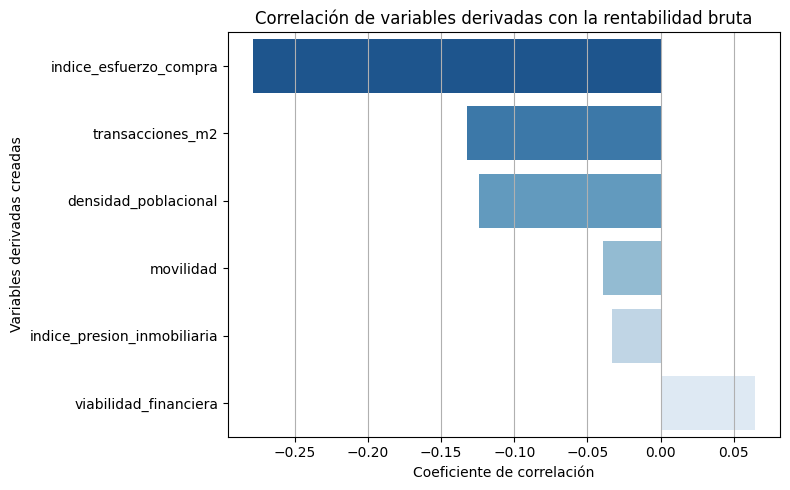

In [ ]:
# Asegúrate de que rentabilidad_bruta_calc no está duplicada
variables_derivadas = [
    'indice_esfuerzo_compra',
    'viabilidad_financiera',
    'indice_presion_inmobiliaria',
    'densidad_poblacional',
    'movilidad',
    'transacciones_m2',
]

# Calcular la correlación con la rentabilidad
correlaciones = {}
for var in variables_derivadas:
    if var in df.columns:
        correlaciones[var] = df[[var, 'rentabilidad_bruta_calc']].corr().iloc[0, 1]
    else:
        print(f"⚠️ La variable '{var}' no está en el DataFrame.")

# Convertimos a Series para graficar
correlaciones_series = pd.Series(correlaciones).sort_values()

# Gráfico
plt.figure(figsize=(8, 5))
sns.barplot(x=correlaciones_series.values, y=correlaciones_series.index, palette='Blues_r')
plt.title('Correlación de variables derivadas con la rentabilidad bruta')
plt.xlabel('Coeficiente de correlación')
plt.ylabel('Variables derivadas creadas')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()



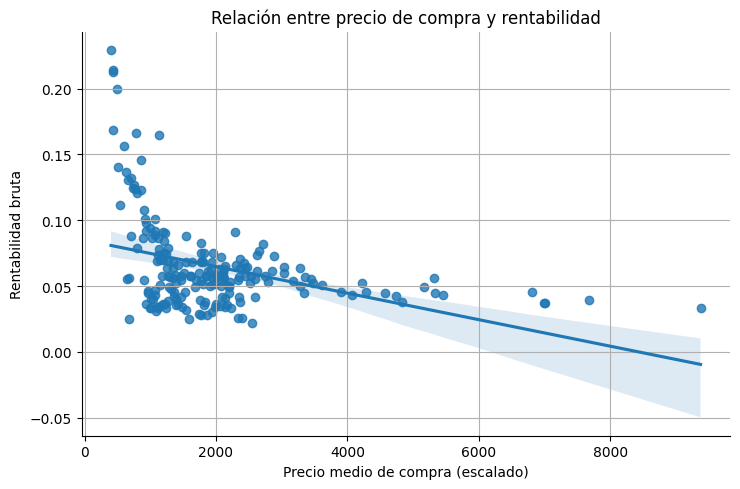

In [ ]:
sns.lmplot(x='preciom2_compra', y='rentabilidad_bruta_calc', data=df_completa, aspect=1.5)
plt.title("Relación entre precio de compra y rentabilidad")
plt.xlabel("Precio medio de compra (escalado)")
plt.ylabel("Rentabilidad bruta")
plt.grid(True)
plt.tight_layout()
plt.show()

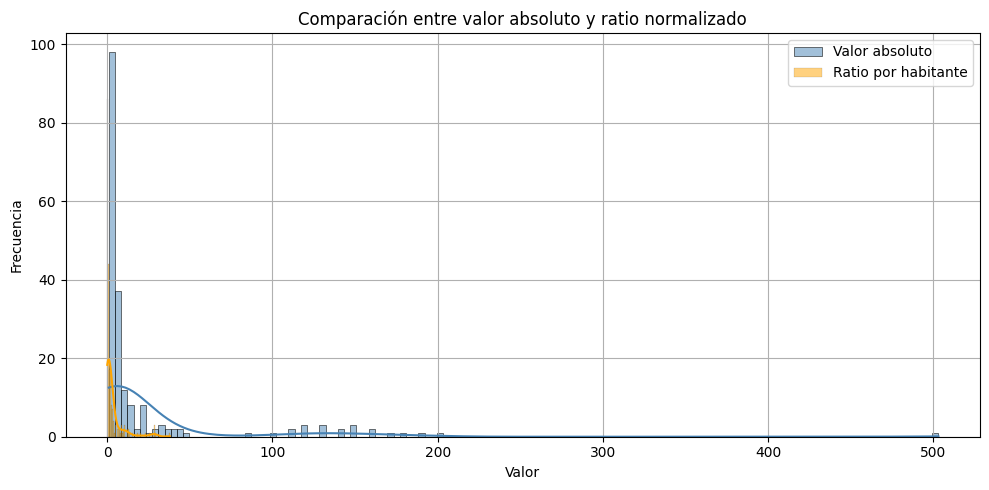

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))

# Histograma del valor absoluto
sns.histplot(df['total_transportepb'], kde=True, color='steelblue', label='Valor absoluto')

# Histograma del ratio normalizado
sns.histplot(df['ratio_transporte'], kde=True, color='orange', label='Ratio por habitante')

plt.title('Comparación entre valor absoluto y ratio normalizado')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


### **B3 - LIMPIEZA INICIAL & DIAGNÓSTICO DE CALIDAD**

In [ ]:
#--------- QUITAMOS DUPLICADOS ---------
df_completa = df_completa.drop_duplicates()

# --------- VERIFICACIÓN FINAL DE NULOS ---------
print("Verificando presencia de valores nulos en el dataset...")

# Calcular porcentaje de nulos por columna
null_percent = df_completa.isnull().mean() * 100
null_percent = null_percent[null_percent > 0]

if null_percent.empty:
    print("No hay valores nulos en el dataset.")
else:
    print("Se encontraron valores nulos:")
    print(null_percent.round(2))


Verificando presencia de valores nulos en el dataset...
No hay valores nulos en el dataset.


In [ ]:
#--------- ASIMETRÍA Y CURTOSIS -----------
# Analizamos la asimetría y curtosis de las variables para ver si necesitan transformación
forma = pd.DataFrame({
    'skewness': df.skew(numeric_only=True),
    'kurtosis': df.kurt(numeric_only=True)
})

# Guardamos copia de las variables numéricas originales antes de la transformación
df_original_numericas = df.select_dtypes(include='number').copy()

# Ordenamos para ver las variables más problemáticas
forma.sort_values('skewness', ascending=False).head(10)

skewness    kurtosis
contratos_registrados      13.946839  196.253843
estaciones_metro           13.836664  194.152085
ncentro_serviciossociales  13.804777  193.500039
nfarmacias                 13.687923  191.315640
alumnos_cprivado           13.656510  190.682188
transacciones_libre        13.584821  189.331186
movilidad                  13.476081  187.282666
paradas_bus                13.446901  186.724173
centrosescolares           13.298301  183.835855
centro_salud               13.112550  180.285422

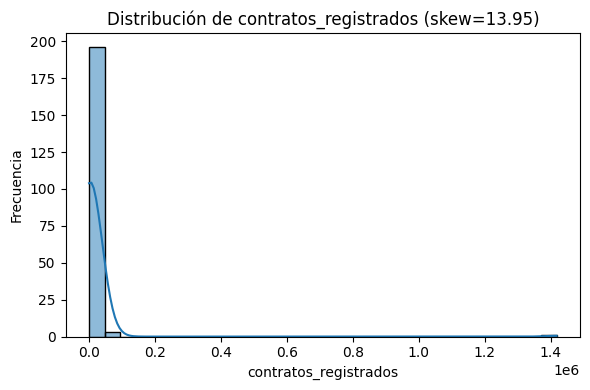

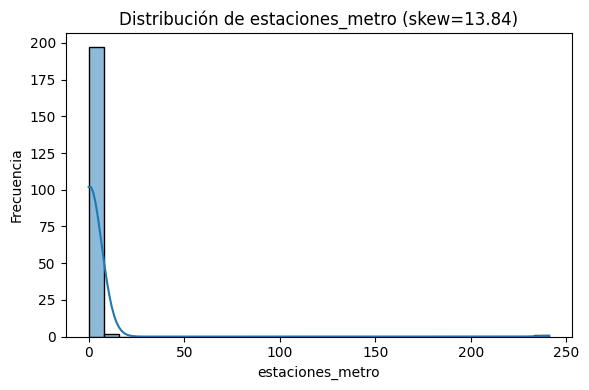

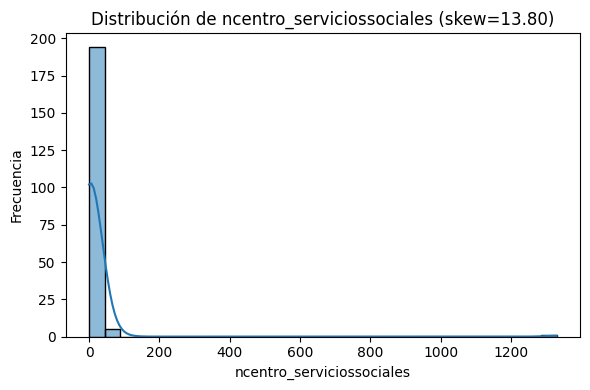

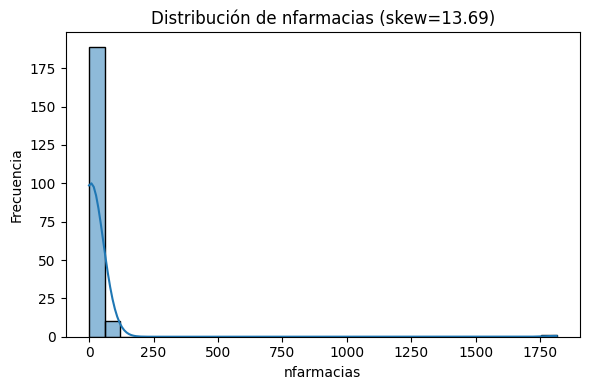

In [ ]:
#--------- HISTORIGRAMAS DISTRIBUCIÓN VARIABLES AHORA ---------

# Lista de variables con alto skew
variables_con_skew = df.select_dtypes(include='number').skew().sort_values(ascending=False)
variables_skewed = variables_con_skew[variables_con_skew > 1.5].index.tolist()

# Visualizar las 4 más sesgadas
for var in variables_skewed[:4]:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[var], kde=True, bins=30)
    plt.title(f'Distribución de {var} (skew={variables_con_skew[var]:.2f})')
    plt.xlabel(var)
    plt.ylabel('Frecuencia')
    plt.tight_layout()
    plt.show()


<ipython-input-167-781007111>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_skew.values, y=top_skew.index, palette='Reds_r')


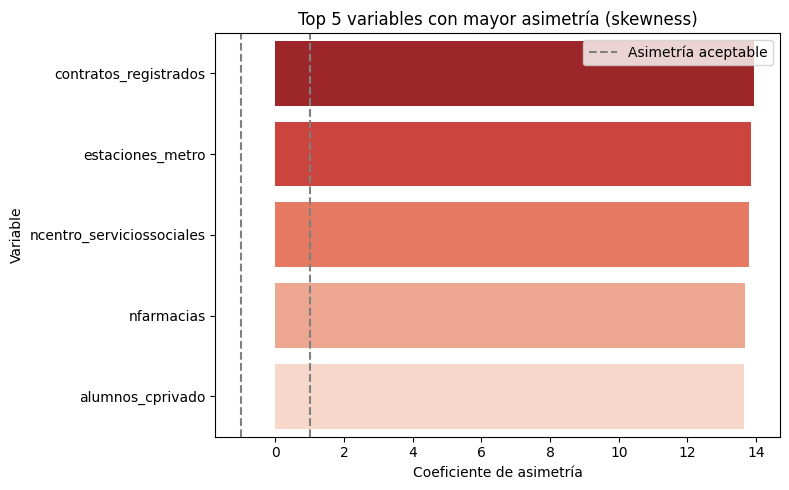

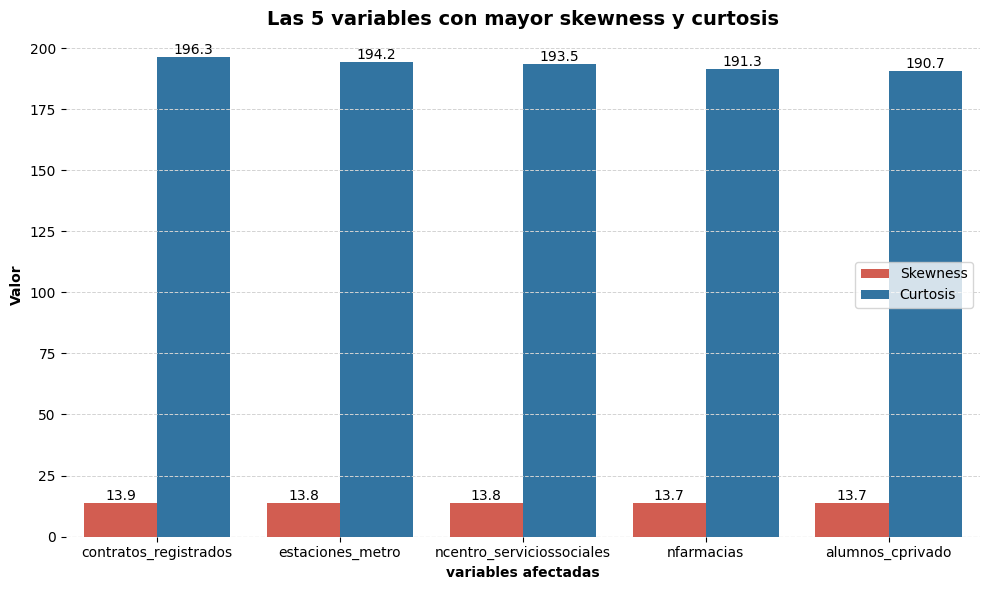

In [ ]:
#--------- HISTORIGRAMAS SESGO VS VALORES ÓPTIMOS ---------

# Calcular skewness (asimetría) solo para variables numéricas
skew_vals = df.select_dtypes(include='number').skew().sort_values(ascending=False)

# Seleccionar las 5 variables más asimétricas
top_skew = skew_vals.head(5)

# Visualizar con barra horizontal
plt.figure(figsize=(8, 5))
sns.barplot(x=top_skew.values, y=top_skew.index, palette='Reds_r')

# Línea de referencia en ±1 (asimetría moderada)
plt.axvline(x=1, color='gray', linestyle='--', label='Asimetría aceptable')
plt.axvline(x=-1, color='gray', linestyle='--')

plt.title('Top 5 variables con mayor asimetría (skewness)')
plt.xlabel('Coeficiente de asimetría')
plt.ylabel('Variable')
plt.legend()
plt.tight_layout()
plt.show()


#--------- HISTORIGRAMAS TOP 5 VARIABLES MÁS SESGADAS ---------

# Calcular skewness y curtosis
skew_vals = df.select_dtypes(include='number').skew()
kurt_vals = df.select_dtypes(include='number').kurt()

# Crear DataFrame conjunto y ordenar por skewness
forma = pd.DataFrame({
    'Skewness': skew_vals,
    'Curtosis': kurt_vals
}).sort_values('Skewness', ascending=False)

# Seleccionar las 5 variables más asimétricas
top5 = forma.head(5).copy()

# Crear gráfico con estilo más limpio
plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    data=top5.reset_index().melt(id_vars='index'),
    x='index',
    y='value',
    hue='variable',
    palette=['#e74c3c', '#1f78b4']
)

# Añadir etiquetas con valores reales
for p in barplot.patches:
    height = p.get_height()
    if height > 0:
        barplot.annotate(f'{height:.1f}',
                         (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='bottom', fontsize=10, color='black')

# Estética del gráfico
plt.title('Las 5 variables con mayor skewness y curtosis', fontsize=14, fontweight='bold')
plt.xlabel('variables afectadas', fontweight='bold')
plt.ylabel('Valor', fontweight='bold')
plt.xticks(rotation=0)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)

# Añadir rejilla suave
plt.grid(axis='y', color='lightgray', linestyle='--', linewidth=0.7)
for spine in barplot.spines.values():
    spine.set_visible(False)

plt.legend(title='')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Resumen estadístico general
resumen = df.describe().T
resumen['skewness'] = df.select_dtypes(include='number').skew()
resumen['kurtosis'] = df.select_dtypes(include='number').kurt()
resumen = resumen[['mean', '50%', 'std', 'min', 'max', 'skewness', 'kurtosis']]

resumen_ordenado = resumen.sort_values(by='skewness', ascending=False)
display(resumen_ordenado)




mean           50%           std  \
contratos_registrados        1.216649e+04    743.500000  1.003565e+05   
estaciones_metro             2.040000e+00      0.000000  1.710648e+01   
ncentro_serviciossociales    1.277000e+01      2.000000  9.430351e+01   
nfarmacias                   1.985500e+01      2.000000  1.288321e+02   
alumnos_cprivado             3.482825e+03     11.500000  2.314307e+04   
transacciones_libre          1.344387e+02     20.750000  8.021499e+02   
movilidad                    8.199000e+01     17.000000  4.153660e+02   
paradas_bus                  7.938500e+01     17.000000  3.956220e+02   
centrosescolares             2.166500e+01      4.000000  1.079153e+02   
centro_salud                 1.785000e+00      0.000000  9.201746e+00   
nalumnos_cescolar            8.694940e+03    920.500000  4.224299e+04   
alumnos_regespecial          5.944800e+02     42.500000  2.869096e+03   
poblacion_cm                 5.149454e+04   6147.500000  2.495123e+05   
pob_empadronada              5.126640e+04   6142.500000  2.465101e+05   
estaciones_trencercanias     5.650000e-01      0.000000  2.838319e+00   
alumnos_cpublico             5.106115e+03    762.500000  1.940008e+04   
afilidados_ss                2.342447e+04   2512.500000  1.176080e+05   
n_biblios                    1.345000e+00      1.000000  3.620985e+00   
transacciones_total          3.042150e+02     21.500000  1.063002e+03   
transacciones_segmano        2.536025e+02     19.375000  8.816560e+02   
pob_extranjeros              4.711020e+03    178.500000  1.707550e+04   
transacciones_protegida      4.022500e+00      0.000000  1.809712e+01   
superficie_cm                4.224371e+01     31.955000  5.048929e+01   
ratio_centros_educativos     8.502653e-01      0.594983  1.081595e+00   
densidad_poblacional         2.349303e+03    179.628225  6.853904e+03   
total_transportepb           2.416500e+01      5.000000  5.461568e+01   
transacciones_nueva          3.955875e+01      0.625000  1.238252e+02   
transacciones_m2             2.236984e+01      0.585309  7.805716e+01   
ratio_centros_salud          3.669223e-02      0.000000  9.158155e-02   
grado_extranj                5.374941e-02      0.032972  6.779041e-02   
densidad_cm                  2.016638e+03    129.465000  5.502947e+03   
ratio_farmacias              5.786653e-01      0.321597  7.805580e-01   
ratio_transporte             3.260489e+00      0.864650  6.271262e+00   
ratio_bibliotecas            6.943669e-02      0.021069  1.232520e-01   
tasa_transacciones_pob       4.964292e+00      3.915685  3.657531e+00   
indice_presion_inmobiliaria  4.964292e-03      0.003916  3.657531e-03   
grado_envejecimiento         2.526268e+00      0.190750  6.834694e+00   
renta_media                  2.259431e+03     38.116820  6.558387e+03   
tasa_natalidad               9.546675e+00      6.900000  1.145112e+01   
grado_juventud               2.112281e+00      0.509700  4.763663e+00   
pib_percapita                1.531083e+07  78070.000000  4.232419e+07   
preciom2_compra              1.975180e+03   1749.000000  1.344201e+03   
rentabilidad_bruta_calc      6.500624e-02      0.057013  3.527169e-02   
rentabilidad_bruta           6.500576e-02      0.057013  3.527196e-02   
tasa_mortalidad              1.371821e+01      8.050000  1.428720e+01   
tasa_paro                    7.983500e+00      7.600000  2.674856e+00   
edad_media                   4.338910e+01     42.905000  3.505135e+00   
preciom2_alquiler            9.190350e+00      7.920000  4.819835e+00   
paro_diff                    2.941500e+00      2.750000  3.422733e+00   
tasa_paro_m                  9.398000e+00      8.650000  3.649437e+00   
tasa_paro_h                  6.456500e+00      6.100000  2.431898e+00   
indice_esfuerzo_compra       3.728739e+01     39.077321  1.891806e+01   
viabilidad_financiera       -4.145813e+00     -0.173424  1.235016e+01   

                                     min           max   skewness    kurtosis  
contratos_regi

### **B4 - DETECCIÓN Y TRATAMIENTO DE OUTLIERS**

In [ ]:
# --------- DETECCIÓN CON IQR ---------
def detectar_outliers_iqr(data):
    outliers = pd.DataFrame(False, index=data.index, columns=data.columns)
    for col in data.columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outliers[col] = (data[col] < lower) | (data[col] > upper)
    return outliers

# --------- DETECCIÓN CON MÉTODO Z-SCORE ---------
from scipy.stats import zscore

def detectar_outliers_zscore(data, threshold=3):
    z_scores = np.abs(zscore(data, nan_policy='omit'))
    return pd.DataFrame(z_scores > threshold, columns=data.columns)

# --------- FUNCIÓN PARA RESUMIR OUTLIERS ---------
def resumen_outliers(outliers_df):
    conteo = outliers_df.sum().sort_values(ascending=False)
    porcentaje = (conteo / len(outliers_df)) * 100
    resumen = pd.DataFrame({
        'Variable': conteo.index,
        'Outliers': conteo.values,
        '%': porcentaje.round(1).values
    }).reset_index(drop=True)
    return resumen

# --------- USAMOS df_trans ---------
df_num = df_trans.select_dtypes(include='number').copy()

outliers_iqr = detectar_outliers_iqr(df_num)
outliers_z = detectar_outliers_zscore(df_num)

# --------- RESUMEN OBTENIDO ---------
resumen_1 = resumen_outliers(outliers_iqr)
resumen_2 = resumen_outliers(outliers_z)

display(HTML("<h4>Recuento de Outliers por IQR</h4>"))
display(resumen_1)

display(HTML("<h4>Recuento de Outliers por Z-Score</h4>"))
display(resumen_2)



Variable  Outliers     %
0      estaciones_trencercanias        49  24.5
1                 pib_percapita        41  20.5
2               pob_extranjeros        40  20.0
3           transacciones_total        39  19.5
4                 afilidados_ss        39  19.5
5           transacciones_nueva        38  19.0
6         transacciones_segmano        38  19.0
7                  poblacion_cm        38  19.0
8         contratos_registrados        38  19.0
9               pob_empadronada        37  18.5
10                   nfarmacias        37  18.5
11             transacciones_m2        36  18.0
12               tasa_natalidad        35  17.5
13                 centro_salud        35  17.5
14         densidad_poblacional        35  17.5
15                  densidad_cm        33  16.5
16             estaciones_metro        33  16.5
17           total_transportepb        33  16.5
18              tasa_mortalidad        32  16.0
19      transacciones_protegida        31  15.5
20          transacciones_libre        31  15.5
21              ratio_farmacias        31  15.5
22             ratio_transporte        30  15.0
23    ncentro_serviciossociales        29  14.5
24                grado_extranj        28  14.0
25                    n_biblios        28  14.0
26             alumnos_cprivado        28  14.0
27               grado_juventud        28  14.0
28          alumnos_regespecial        27  13.5
29             centrosescolares        26  13.0
30             alumnos_cpublico        26  13.0
31                  renta_media        25  12.5
32        viabilidad_financiera        24  12.0
33            nalumnos_cescolar        24  12.0
34         grado_envejecimiento        21  10.5
35          ratio_centros_salud        21  10.5
36       tasa_transacciones_pob        20  10.0
37  indice_presion_inmobiliaria        20  10.0
38     ratio_centros_educativos        19   9.5
39      rentabilidad_bruta_calc        18   9.0
40           rentabilidad_bruta        18   9.0
41                    paro_diff        15   7.5
42            ratio_bibliotecas        15   7.5
43              preciom2_compra        14   7.0
44                superficie_cm        13   6.5
45                   edad_media        12   6.0
46                  paradas_bus        11   5.5
47                    movilidad        11   5.5
48            preciom2_alquiler         9   4.5
49                  tasa_paro_m         9   4.5
50                    tasa_paro         4   2.0
51                  tasa_paro_h         2   1.0
52       indice_esfuerzo_compra         2   1.0

Variable  Outliers    %
0                tasa_natalidad        17  8.5
1          grado_envejecimiento        10  5.0
2                   renta_media         8  4.0
3                grado_juventud         8  4.0
4                   densidad_cm         8  4.0
5         viabilidad_financiera         8  4.0
6              ratio_transporte         8  4.0
7          densidad_poblacional         7  3.5
8           transacciones_nueva         7  3.5
9               ratio_farmacias         6  3.0
10          ratio_centros_salud         6  3.0
11             transacciones_m2         6  3.0
12              preciom2_compra         5  2.5
13  indice_presion_inmobiliaria         5  2.5
14       tasa_transacciones_pob         5  2.5
15            ratio_bibliotecas         5  2.5
16            preciom2_alquiler         4  2.0
17           rentabilidad_bruta         4  2.0
18      rentabilidad_bruta_calc         4  2.0
19           total_transportepb         3  1.5
20                grado_extranj         3  1.5
21                    paro_diff         3  1.5
22      transacciones_protegida         3  1.5
23     ratio_centros_educativos         3  1.5
24                superficie_cm         2  1.0
25              tasa_mortalidad         2  1.0
26                  tasa_paro_h         2  1.0
27                afilidados_ss         2  1.0
28                  tasa_paro_m         2  1.0
29       indice_esfuerzo_compra         2  1.0
30        transacciones_segmano         1  0.5
31                    tasa_paro         1  0.5
32        contratos_registrados         1  0.5
33              pob_extranjeros         1  0.5
34              pob_empadronada         1  0.5
35                 poblacion_cm         1  0.5
36                   edad_media         1  0.5
37          alumnos_regespecial         1  0.5
38          transacciones_total         1  0.5
39                    n_biblios         1  0.5
40                  paradas_bus         1  0.5
41             estaciones_metro         1  0.5
42     estaciones_trencercanias         1  0.5
43                   nfarmacias         1  0.5
44    ncentro_serviciossociales         1  0.5
45             alumnos_cpublico         1  0.5
46             alumnos_cprivado         1  0.5
47                 centro_salud         1  0.5
48             centrosescolares         1  0.5
49          transacciones_libre         1  0.5
50            nalumnos_cescolar         1  0.5
51                    movilidad         1  0.5
52                pib_percapita         0  0.0

In [ ]:
# --------- TRATAMIENTO CON WINSORIZING ---------
from feature_engine.outliers import Winsorizer

# Seleccionar solo variables numéricas desde df_trans
df_num = df_trans.select_dtypes(include=[np.number]).copy()

# Separar columnas según tengan IQR > 0 (variabilidad real)
iqr_nonzero_cols = []
iqr_zero_cols = []

for col in df_num.columns:
    q1, q3 = df_num[col].quantile([0.25, 0.75])
    if (q3 - q1) > 0:
        iqr_nonzero_cols.append(col)
    else:
        iqr_zero_cols.append(col)

# Winsorizing con IQR
winsor_iqr = Winsorizer(
    capping_method='iqr',
    tail='both',
    fold=1.5,
    variables=iqr_nonzero_cols
)

# Winsorizing con cuantiles para variables sin IQR
winsor_quant = Winsorizer(
    capping_method='quantiles',
    tail='right',
    fold=0.01,
    variables=iqr_zero_cols
)

# Aplicar winsorizing
df_winsor = df_num.copy()

if iqr_nonzero_cols:
    df_winsor[iqr_nonzero_cols] = winsor_iqr.fit_transform(df_winsor[iqr_nonzero_cols])

if iqr_zero_cols:
    df_winsor[iqr_zero_cols] = winsor_quant.fit_transform(df_winsor[iqr_zero_cols])

# df_winsor ahora es la versión numérica final sin outliers extremos
df_winsor.head()




preciom2_compra  preciom2_alquiler  rentabilidad_bruta  superficie_cm  \
0           2192.0               9.03            0.049434          21.86   
1           2524.0              10.97            0.052155          19.80   
2           1222.0               9.19            0.090245          25.70   
3           1511.0               7.53            0.059801          22.00   
4           2366.0              12.56            0.063702          88.11   

   densidad_cm  poblacion_cm  pob_empadronada  pob_extranjeros  grado_extranj  \
0        3.020        68.000             68.0            0.000       0.000000   
1      225.000      4946.000           4863.0          245.000       0.049535   
2        7.740       256.000            255.0           25.000       0.077516   
3      415.860     10413.000          10430.0          425.000       0.040814   
4     1743.075     67230.875          67194.5         2377.875       0.043558   

   edad_media  ...  paro_diff  densidad_poblacional  movilidad  \
0    50.31875  ...       -3.2              3.110704      3.000   
1    40.87000  ...        2.8            249.797980     18.000   
2    47.49000  ...        4.3              9.961089      3.000   
3    42.57000  ...        3.2            473.318182     25.000   
4    43.87000  ...        2.7           1881.152725    210.125   

   transacciones_m2  ratio_transporte  ratio_centros_salud  ratio_farmacias  \
0          0.091491          5.490832             0.000000         0.000000   
1          1.010101          1.213101             0.000000         0.202184   
2          0.136187          5.490832             0.000000         0.925868   
3          1.681818          0.384135             0.000000         0.192068   
4          6.060718          0.170167             0.050049         0.345338   

   ratio_bibliotecas  ratio_centros_educativos  tasa_transacciones_pob  
0           0.000000                  0.000000                9.211765  
1           0.202184                  0.404367                4.043672  
2           0.000000                  0.000000                9.211765  
3           0.096034                  0.576203                3.553251  
4           0.040039                  0.500490                3.042982  

[5 rows x 53 columns]

In [ ]:
# -------- COMPARACIÓN ANTES Y DESPUÉS DE WINSORIZING --------

# Detección con Z-Score antes y después
outliers_antes = detectar_outliers_zscore(df_trans.select_dtypes(include='number'))
outliers_despues = detectar_outliers_zscore(df_winsor)

# Resumen
resumen_antes = resumen_outliers(outliers_antes).rename(columns={'Outliers': 'Antes', '%': '% Antes'})
resumen_despues = resumen_outliers(outliers_despues).rename(columns={'Outliers': 'Después', '%': '% Después'})

# Combinar y calcular reducción
comparacion = pd.concat([resumen_antes, resumen_despues], axis=1)
comparacion['Reducción'] = comparacion['Antes'] - comparacion['Después']
comparacion['% Reducción'] = ((comparacion['Reducción'] / comparacion['Antes']) * 100).replace([np.inf, -np.inf], np.nan).round(1)

# Mostrar
display(HTML("<h4>📉 Comparación de Outliers por Variable (Antes vs. Después de Winsorizing)</h4>"))
display(comparacion.sort_values('Reducción', ascending=False).fillna(0))


Antes  % Antes  Después  % Después  Reducción  \
tasa_natalidad                  17      8.5        0        0.0         17   
grado_envejecimiento            10      5.0        0        0.0         10   
renta_media                      8      4.0        0        0.0          8   
grado_juventud                   8      4.0        0        0.0          8   
densidad_cm                      8      4.0        0        0.0          8   
viabilidad_financiera            8      4.0        0        0.0          8   
ratio_transporte                 8      4.0        0        0.0          8   
densidad_poblacional             7      3.5        0        0.0          7   
transacciones_nueva              7      3.5        0        0.0          7   
ratio_farmacias                  6      3.0        0        0.0          6   
ratio_centros_salud              6      3.0        0        0.0          6   
transacciones_m2                 6      3.0        0        0.0          6   
preciom2_compra                  5      2.5        0        0.0          5   
indice_presion_inmobiliaria      5      2.5        0        0.0          5   
tasa_transacciones_pob           5      2.5        0        0.0          5   
ratio_bibliotecas                5      2.5        0        0.0          5   
preciom2_alquiler                4      2.0        0        0.0          4   
rentabilidad_bruta               4      2.0        0        0.0          4   
rentabilidad_bruta_calc          4      2.0        0        0.0          4   
total_transportepb               3      1.5        0        0.0          3   
grado_extranj                    3      1.5        0        0.0          3   
paro_diff                        3      1.5        0        0.0          3   
transacciones_protegida          3      1.5        0        0.0          3   
ratio_centros_educativos         3      1.5        0        0.0          3   
superficie_cm                    2      1.0        0        0.0          2   
tasa_mortalidad                  2      1.0        0        0.0          2   
tasa_paro_h                      2      1.0        0        0.0          2   
afilidados_ss                    2      1.0        0        0.0          2   
tasa_paro_m                      2      1.0        0        0.0          2   
indice_esfuerzo_compra           2      1.0        0        0.0          2   
alumnos_regespecial              1      0.5        0        0.0          1   
tasa_paro                        1      0.5        0        0.0          1   
contratos_registrados            1      0.5        0        0.0          1   
pob_extranjeros                  1      0.5        0        0.0          1   
pob_empadronada                  1      0.5        0        0.0          1   
poblacion_cm                     1      0.5        0        0.0          1   
edad_media                       1      0.5        0        0.0          1   
alumnos_cpublico                 1      0.5        0        0.0          1   
alumnos_cprivado                 1      0.5        0        0.0          1   
transacciones_segmano            1      0.5        0        0.0          1   
transacciones_total              1      0.5        0        0.0          1   
paradas_bus                      1      0.5        0        0.0          1   
n_biblios                        1      0.5        0        0.0          1   
nfarmacias                       1      0.5        0        0.0          1   
ncentro_serviciossociales        1      0.5        0        0.0          1   
transacciones_libre              1      0.5        0        0.0          1   
nalumnos_cescolar                1      0.5        0        0.0          1   
centro_salud                     1      0.5        0        0.0          1   
centrosescolares                 1      0.5        0        0.0          1   
movilidad                        1      0.5        0        0.0          1   
pib_percapita                    0      0.0        

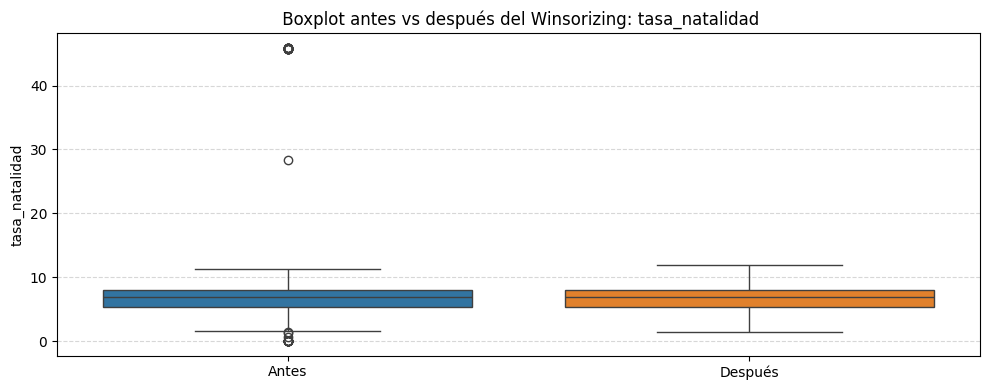

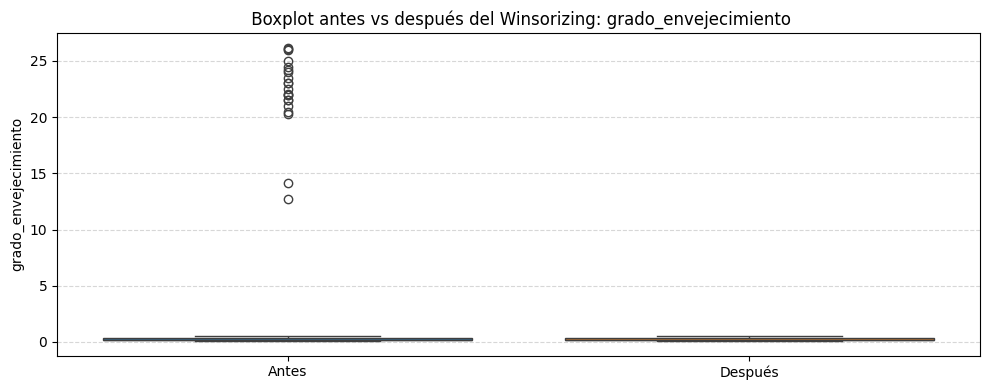

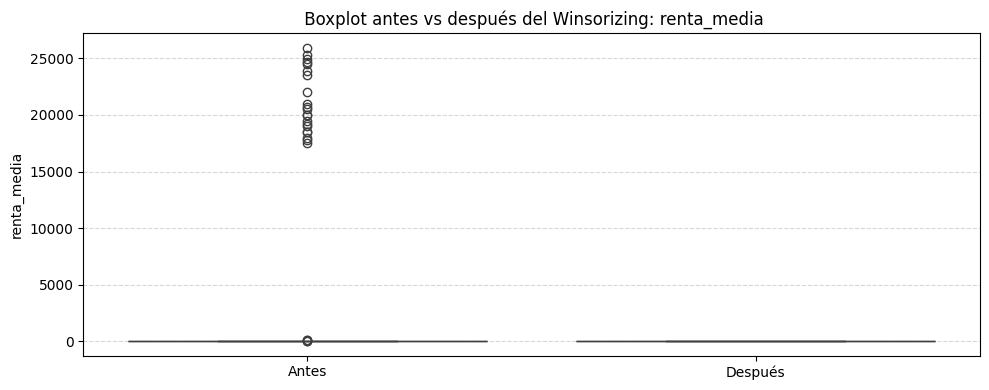

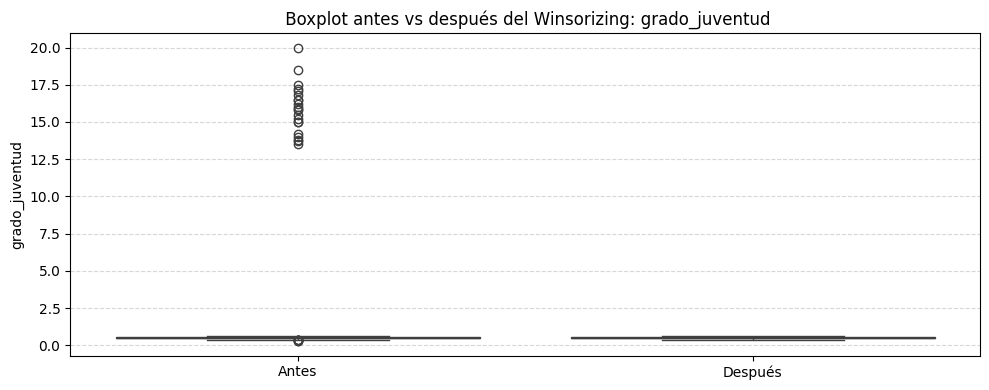

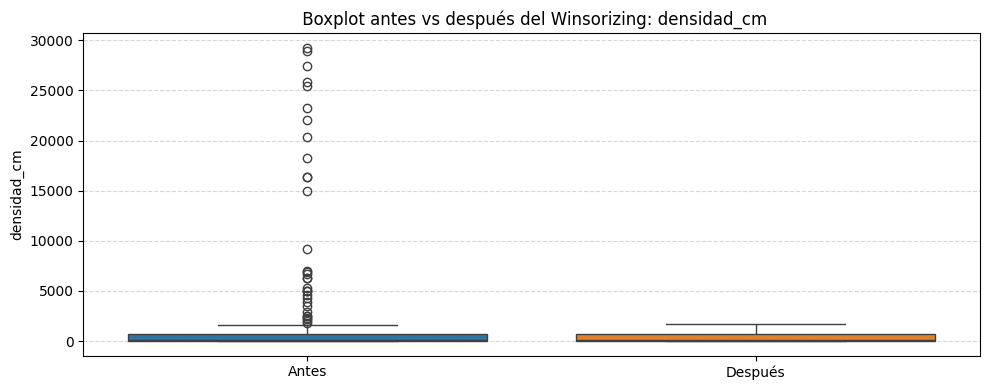

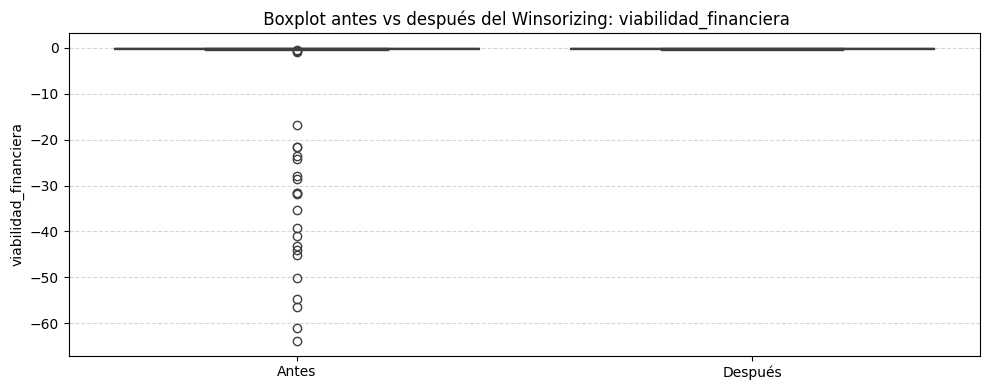

In [ ]:
# -------- COMPARACIÓN OUTLIERS CON BOXPLOTS --------

# Elegimos las más reducidas
variables_a_mostrar = comparacion.sort_values('Reducción', ascending=False).head(6).index.tolist()

for col in variables_a_mostrar:
    plt.figure(figsize=(10, 4))

    sns.boxplot(data=pd.DataFrame({
        'Antes': df_trans[col],
        'Después': df_winsor[col]
    }))

    plt.title(f" Boxplot antes vs después del Winsorizing: {col}")
    plt.ylabel(col)
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


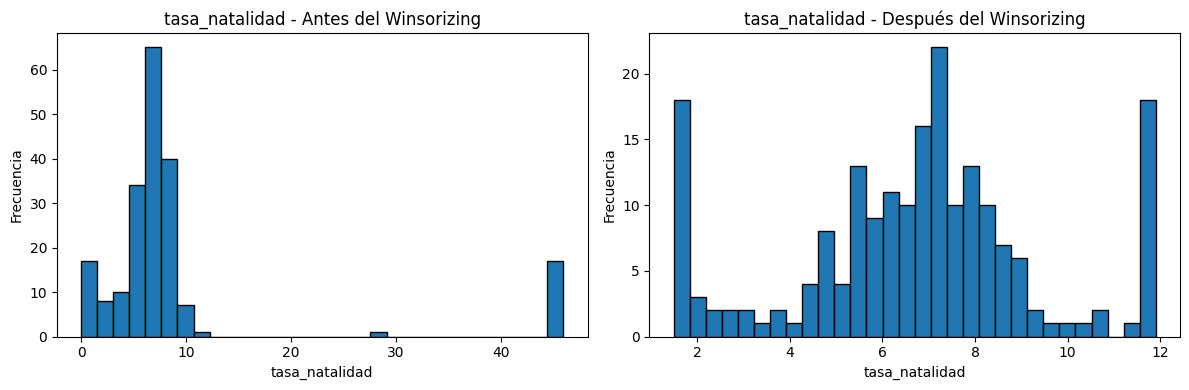

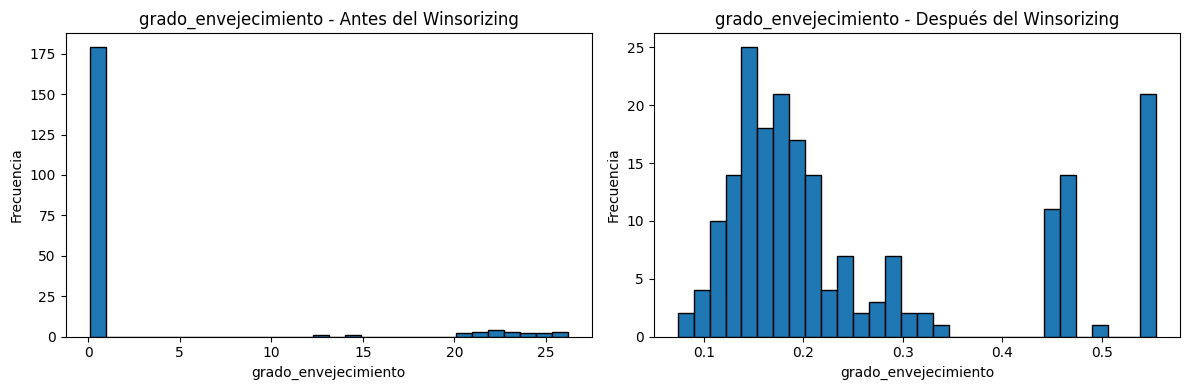

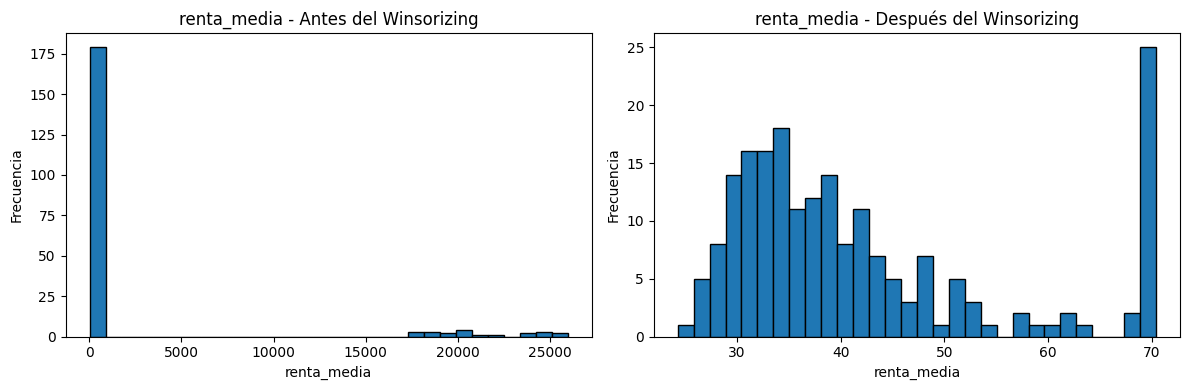

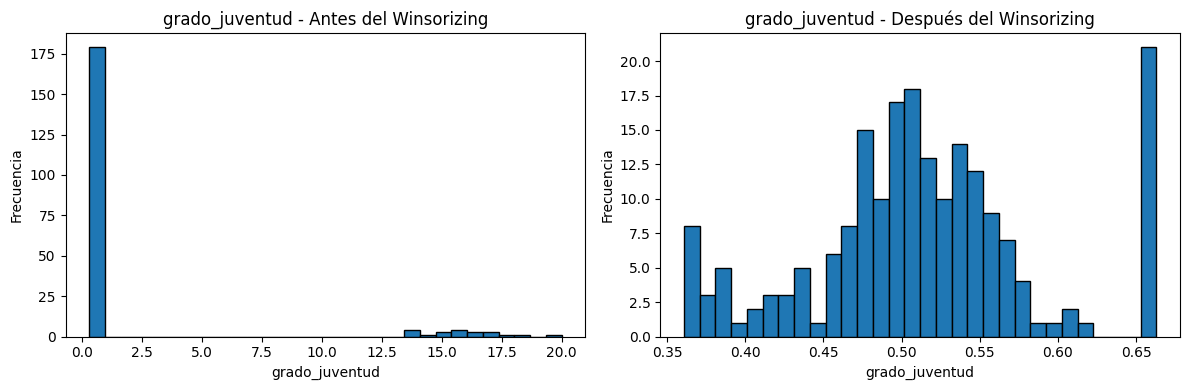

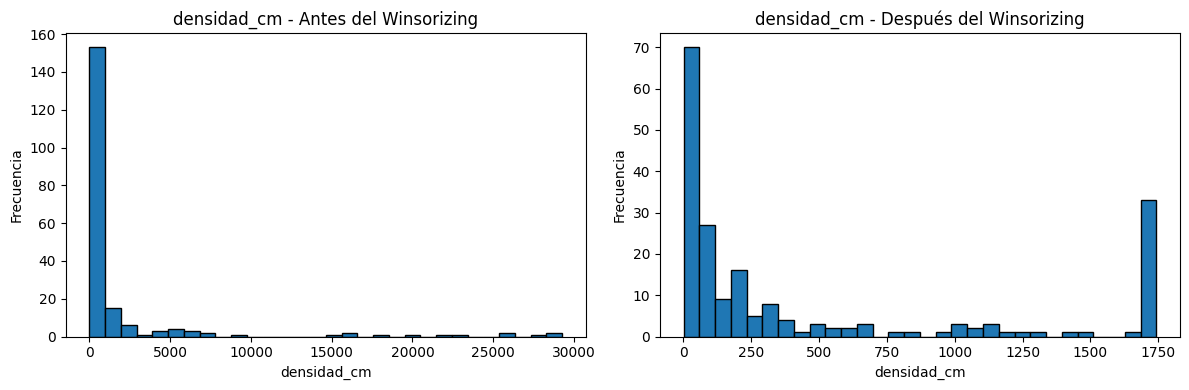

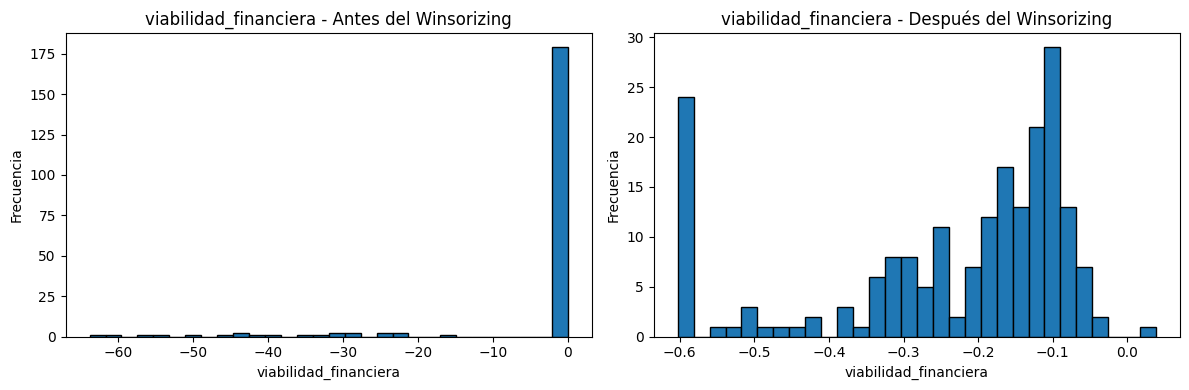

In [ ]:
# ---------- COMPARACIÓN OUTLIERS HISTOGRAMAS --------

# Usamos las mismas 6 variables con mayor reducción de outliers
variables_a_mostrar = comparacion.sort_values('Reducción', ascending=False).head(6).index.tolist()

for col in variables_a_mostrar:
    plt.figure(figsize=(12, 4))

    # Antes
    plt.subplot(1, 2, 1)
    plt.hist(df_num[col], bins=30, edgecolor='black')
    plt.title(f"{col} - Antes del Winsorizing")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")

    # Después
    plt.subplot(1, 2, 2)
    plt.hist(df_winsor[col], bins=30, edgecolor='black')
    plt.title(f"{col} - Después del Winsorizing")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")

    plt.tight_layout()
    plt.show()


### **B6 - SELECCIÓN DE VARIABLES**

**ANÁLISIS TÉCNICO PARA SELECCIONAR VARIABLES**

In [ ]:
# --------- CÁLCULOS DE LA VARIANZA ---------
numeric_df = df_winsor.select_dtypes(include=[np.number])  # variables numéricas ya sin outliers
variances = numeric_df.var().sort_values(ascending=False)
variances.head(15)




pib_percapita            3.115923e+11
poblacion_cm             6.723035e+08
pob_empadronada          6.718002e+08
afilidados_ss            1.299458e+08
nalumnos_cescolar        3.857478e+07
contratos_registrados    1.905885e+07
alumnos_cpublico         1.288794e+07
alumnos_cprivado         4.365737e+06
preciom2_compra          9.215151e+05
pob_extranjeros          8.491112e+05
densidad_poblacional     4.930132e+05
densidad_cm              4.150015e+05
alumnos_regespecial      2.044013e+05
transacciones_total      6.188518e+03
transacciones_segmano    5.251109e+03
dtype: float64

In [ ]:
# --------- ANÁLISIS DE SKEWNESS (SESGO) ---------
skewness = numeric_df.skew().sort_values(ascending=False)
skewness.head(10)

# Nota: puedes filtrar por variables con skew > 1.5 si quieres tratarlas
# skewness[skewness > 1.5]


estaciones_metro            2.357669
estaciones_trencercanias    2.050527
ratio_bibliotecas           1.374294
paradas_bus                 1.342291
movilidad                   1.330269
ratio_centros_salud         1.330050
transacciones_protegida     1.267796
ratio_transporte            1.233326
alumnos_regespecial         1.231066
alumnos_cprivado            1.201573
dtype: float64

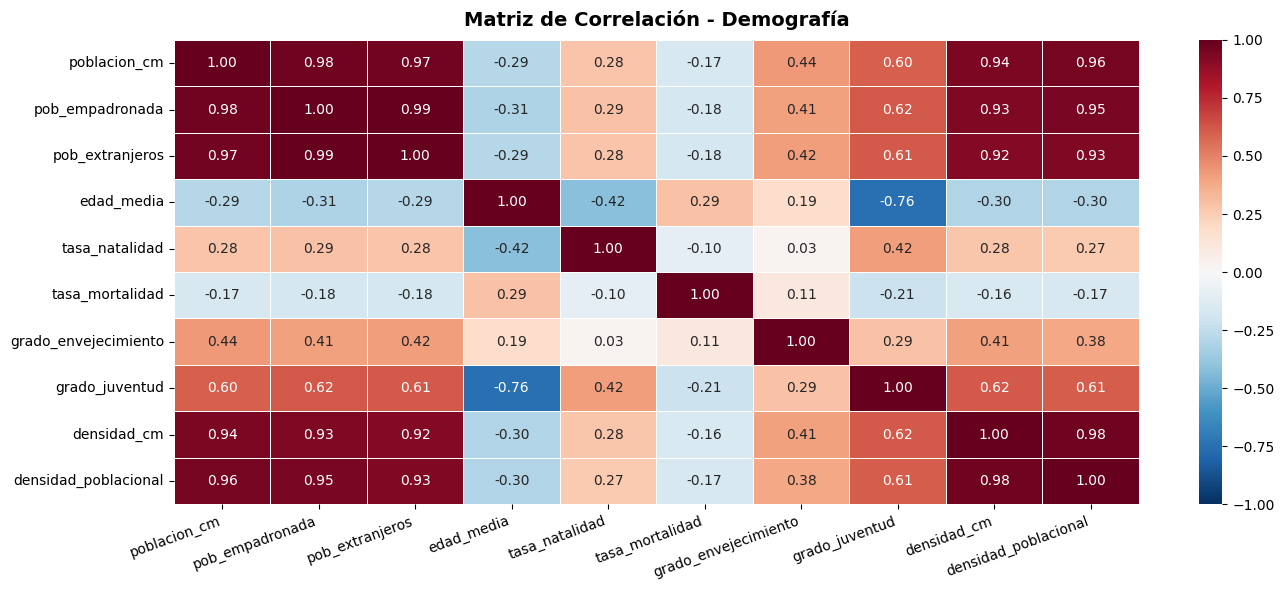

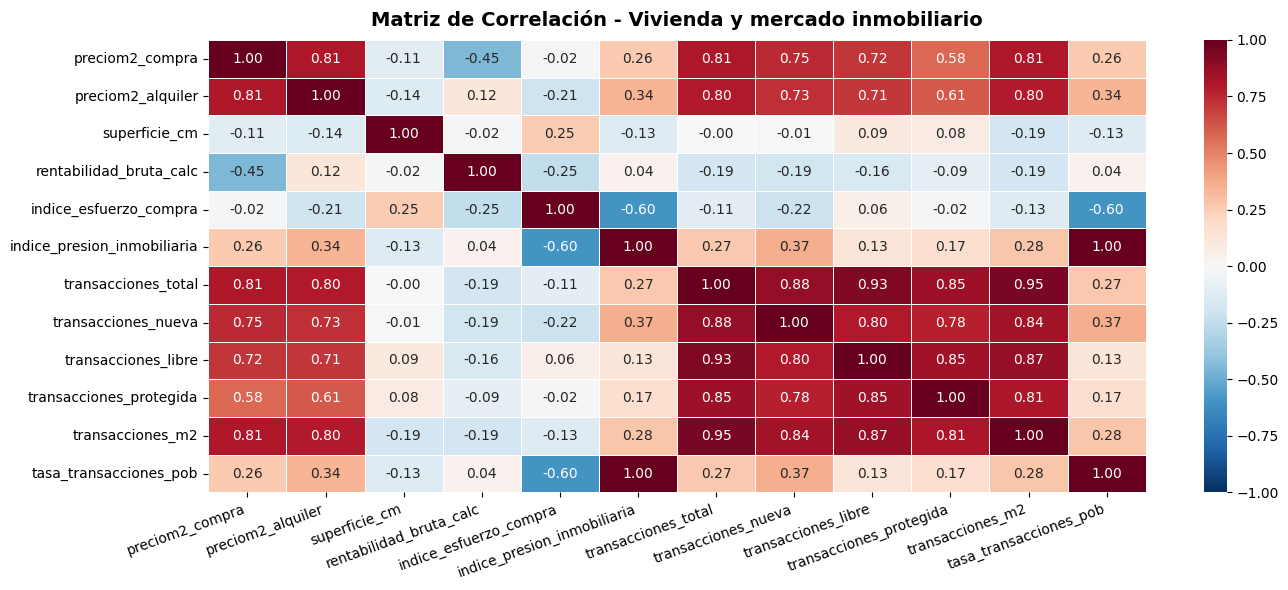

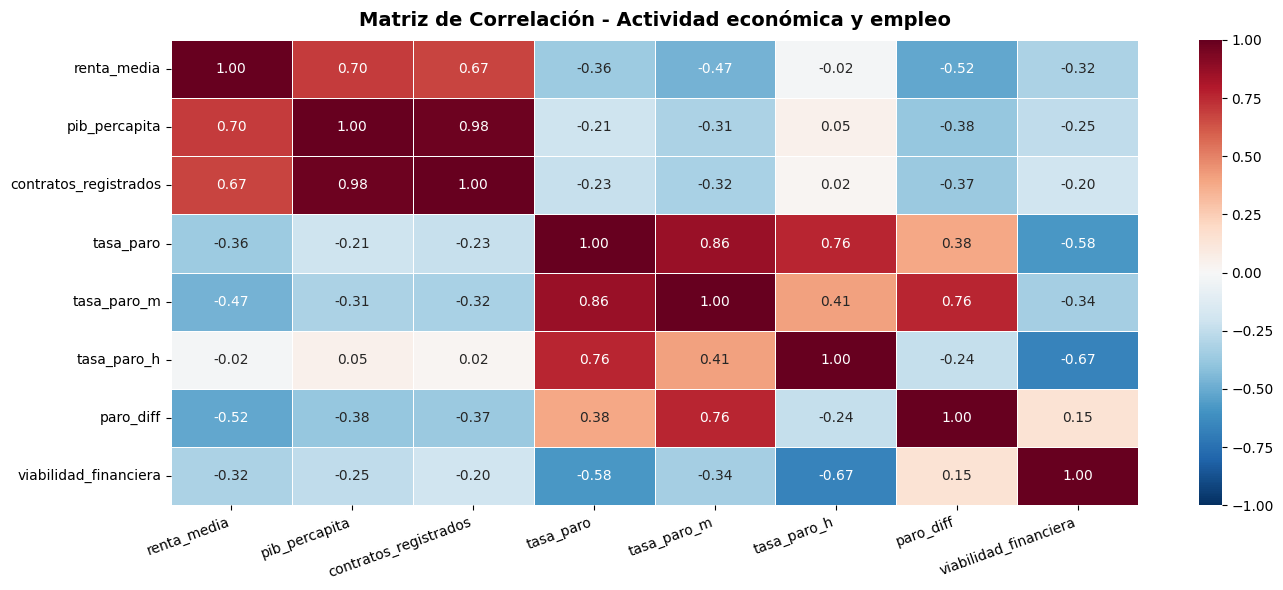

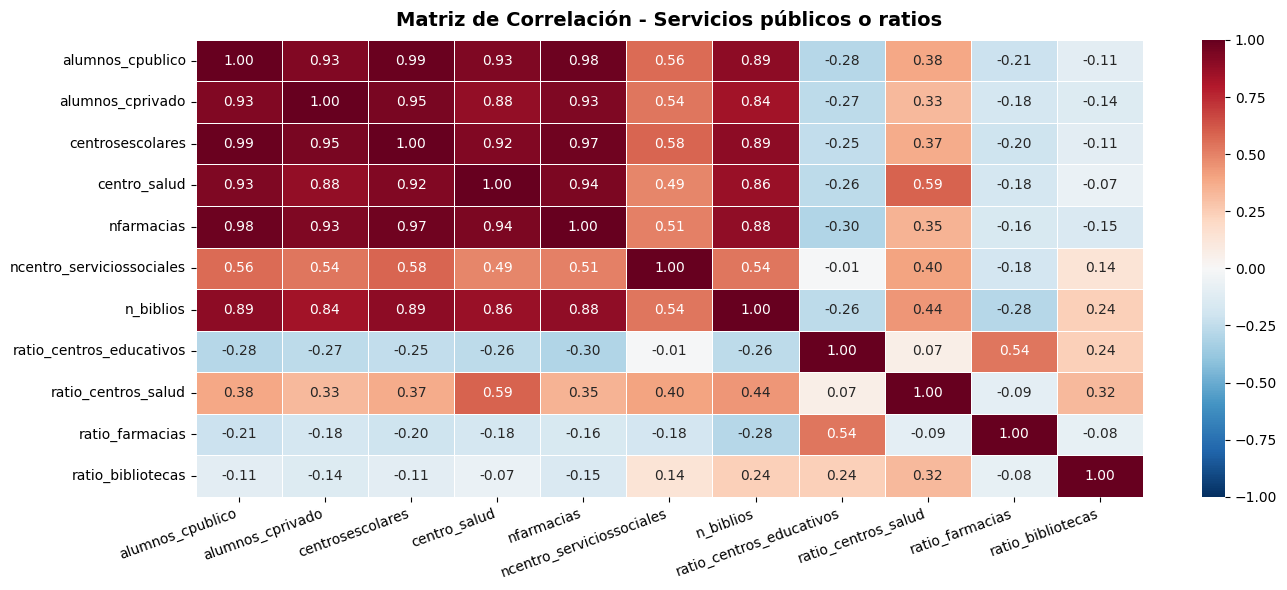

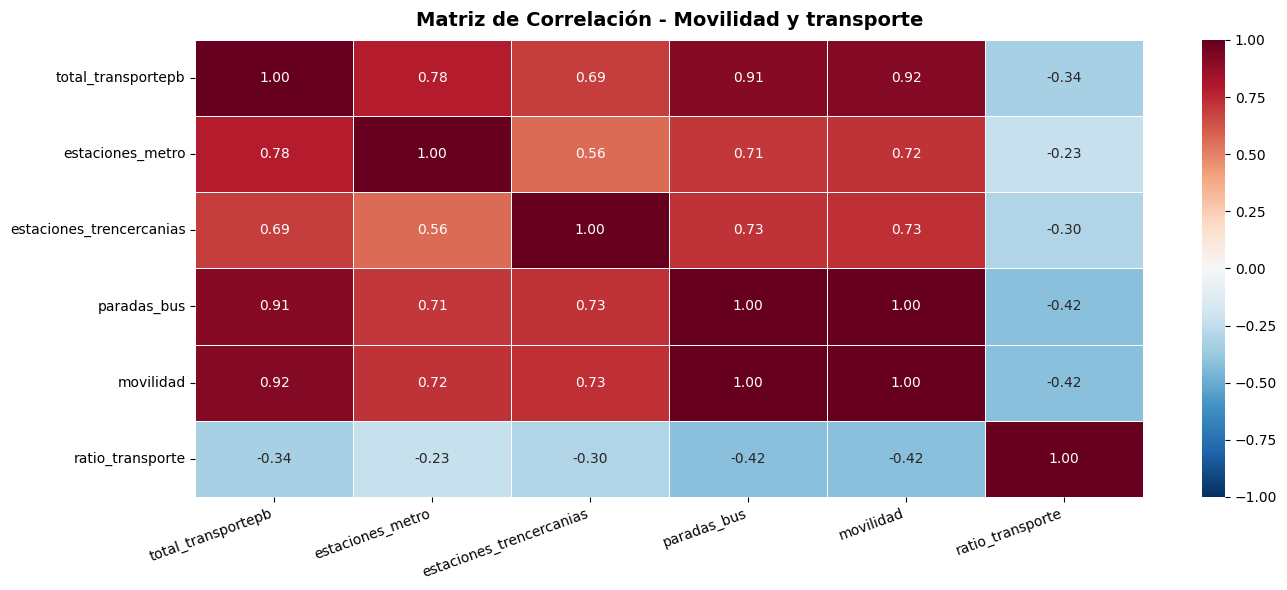

In [ ]:
# --------- MATRIZ DE CORRELACIÓN POR BLOQUES ---------
import seaborn as sns
import matplotlib.pyplot as plt

# Bloques temáticos (actualizados sin proporcion_nueva ni proporcion_protegida)
bloques = {
    'Demografía': [
        'poblacion_cm', 'pob_empadronada', 'pob_extranjeros', 'edad_media',
        'tasa_natalidad', 'tasa_mortalidad', 'grado_envejecimiento',
        'grado_juventud', 'densidad_cm', 'grado_extran', 'densidad_poblacional'
    ],
    'Vivienda y mercado inmobiliario': [
        'preciom2_compra', 'preciom2_alquiler', 'superficie_cm', 'rentabilidad_bruta_calc',
        'indice_esfuerzo_compra', 'indice_presion_inmobiliaria',
        'transacciones_total', 'transacciones_nueva', 'transacciones_segnano',
        'transacciones_libre', 'transacciones_protegida', 'transacciones_m2',
        'tasa_transacciones_pob'
    ],
    'Actividad económica y empleo': [
        'renta_media', 'pib_percapita', 'afiliados_ss', 'contratos_registrados',
        'tasa_paro', 'tasa_paro_m', 'tasa_paro_h', 'paro_diff', 'viabilidad_financiera'
    ],
    'Servicios públicos o ratios': [
        'alumnos_escolar', 'alumnos_cpublico', 'alumnos_cprivado',
        'alumnos_repespecial', 'centrosescolares', 'centro_salud', 'nfarmacias',
        'ncentro_serviciossociales', 'n_biblios', 'ratio_centros_educativos',
        'ratio_centros_salud', 'ratio_farmacias', 'ratio_bibliotecas'
    ],
    'Movilidad y transporte': [
        'total_transportepb', 'estaciones_metro', 'estaciones_trencercanias',
        'paradas_bus', 'movilidad', 'ratio_transporte'
    ]
}

# Crear matrices de correlación por bloque
df_num = df_winsor.select_dtypes(include='number')
matrices_correlacion = {}

for bloque, variables in bloques.items():
    variables_validas = [v for v in variables if v in df_num.columns]
    matrices_correlacion[bloque] = df_num[variables_validas].corr()

# Graficar cada heatmap por bloque
for bloque, matriz in matrices_correlacion.items():
    num_cols = len(matriz.columns)
    ancho = max(14, int(num_cols * 1.2))

    plt.figure(figsize=(ancho, 6))
    sns.heatmap(matriz, annot=True, cmap="RdBu_r", fmt=".2f", linewidths=0.5,
                linecolor='white', cbar=True, vmin=-1, vmax=1)
    plt.title(f'Matriz de Correlación - {bloque}', fontsize=14, weight='bold', pad=10)
    plt.xticks(rotation=20, ha='right')
    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


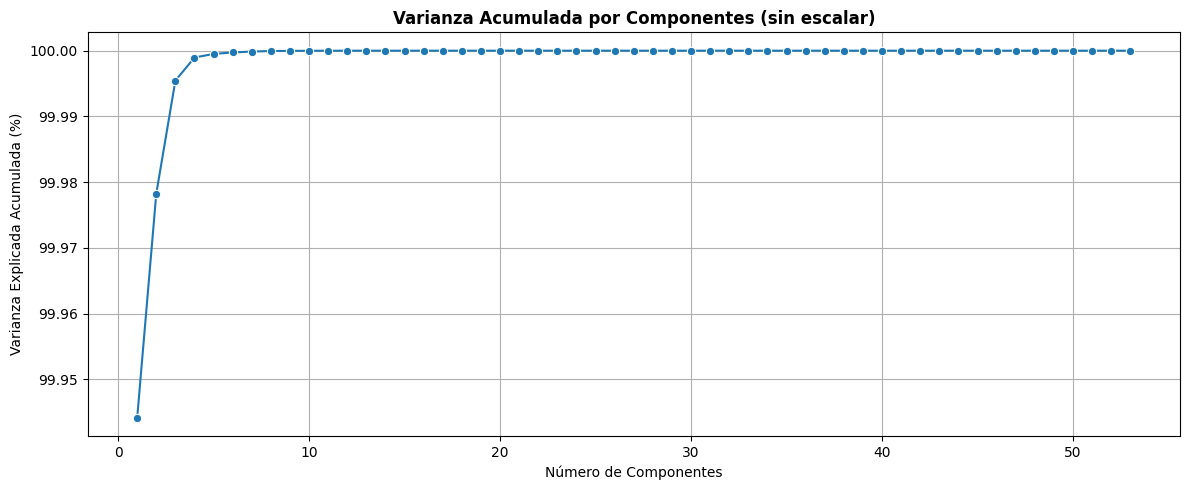

Componente  Varianza Explicada (%)  Acumulada (%)
0         PC1                   99.94          99.94
1         PC2                    0.03          99.98
2         PC3                    0.02         100.00
3         PC4                    0.00         100.00
4         PC5                    0.00         100.00
5         PC6                    0.00         100.00
6         PC7                    0.00         100.00
7         PC8                    0.00         100.00
8         PC9                    0.00         100.00
9        PC10                    0.00         100.00
10       PC11                    0.00         100.00
11       PC12                    0.00         100.00
12       PC13                    0.00         100.00
13       PC14                    0.00         100.00
14       PC15                    0.00         100.00
15       PC16                    0.00         100.00
16       PC17                    0.00         100.00
17       PC18                    0.00         100.00
18       PC19                    0.00         100.00
19       PC20                    0.00         100.00
20       PC21                    0.00         100.00
21       PC22                    0.00         100.00
22       PC23                    0.00         100.00
23       PC24                    0.00         100.00
24       PC25                    0.00         100.00
25       PC26                    0.00         100.00
26       PC27                    0.00         100.00
27       PC28                    0.00         100.00
28       PC29                    0.00         100.00
29       PC30                    0.00         100.00
30       PC31                    0.00         100.00
31       PC32                    0.00         100.00
32       PC33                    0.00         100.00
33       PC34                    0.00         100.00
34       PC35                    0.00         100.00
35       PC36                    0.00         100.00
36       PC37                    0.00         100.00
37       PC38                    0.00         100.00
38       PC39                    0.00         100.00
39       PC40                    0.00         100.00
40       PC41                    0.00         100.00
41       PC42                    0.00         100.00
42       PC43                    0.00         100.00
43       PC44                    0.00         100.00
44       PC45                    0.00         100.00
45       PC46                    0.00         100.00
46       PC47                    0.00         100.00
47       PC48                    0.00         100.00
48       PC49                    0.00         100.00
49       PC50                    0.00         100.00
50       PC51                    0.00         100.00
51       PC52                    0.00         100.00
52       PC53                    0.00         100.00

Variable           VIF
52       tasa_transacciones_pob           inf
42  indice_presion_inmobiliaria           inf
39      rentabilidad_bruta_calc  5.571627e+07
2            rentabilidad_bruta  5.568537e+07
45                    movilidad  2.821669e+04
32                  paradas_bus  2.715934e+04
6               pob_empadronada  8.001725e+02
21            nalumnos_cescolar  7.453441e+02
34          transacciones_total  7.098455e+02
27                   nfarmacias  6.424666e+02
36        transacciones_segmano  6.082318e+02
5                  poblacion_cm  3.873022e+02
19                  tasa_paro_m  3.797887e+02
7               pob_extranjeros  3.277376e+02
22             alumnos_cpublico  3.184121e+02
18                    tasa_paro  3.104771e+02
9                    edad_media  2.706466e+02
25             centrosescolares  2.341660e+02
44         densidad_poblacional  2.114684e+02
0               preciom2_compra  1.954901e+02
13               grado_juventud  1.784900e+02
14                  renta_media  1.781879e+02
20                  tasa_paro_h  1.764278e+02
1             preciom2_alquiler  1.752991e+02
26                 centro_salud  1.635854e+02
15                pib_percapita  1.413386e+02
46             transacciones_m2  1.354934e+02
41       indice_esfuerzo_compra  1.239331e+02
23             alumnos_cprivado  9.313560e+01
40        viabilidad_financiera  8.127171e+01
4                   densidad_cm  7.470728e+01
33                    n_biblios  7.235602e+01
17        contratos_registrados  7.072565e+01
29           total_transportepb  6.488025e+01
43                    paro_diff  5.863701e+01
37          transacciones_libre  3.868262e+01
24          alumnos_regespecial  2.820426e+01
48          ratio_centros_salud  1.864275e+01
35          transacciones_nueva  1.714734e+01
8                 grado_extranj  1.555298e+01
12         grado_envejecimiento  1.200049e+01
10               tasa_natalidad  1.154723e+01
3                 superficie_cm  1.097935e+01
47             ratio_transporte  1.081032e+01
49              ratio_farmacias  1.070333e+01
30             estaciones_metro  1.046041e+01
50            ratio_bibliotecas  1.027632e+01
38      transacciones_protegida  1.024257e+01
28    ncentro_serviciossociales  9.350280e+00
51     ratio_centros_educativos  8.348921e+00
31     estaciones_trencercanias  5.275106e+00
11              tasa_mortalidad  5.129952e+00
16                afilidados_ss  3.214690e+00

Variable  CV
0               preciom2_compra NaN
1             preciom2_alquiler NaN
2            rentabilidad_bruta NaN
3                 superficie_cm NaN
4                   densidad_cm NaN
5                  poblacion_cm NaN
6               pob_empadronada NaN
7               pob_extranjeros NaN
8                 grado_extranj NaN
9                    edad_media NaN
10               tasa_natalidad NaN
11              tasa_mortalidad NaN
12         grado_envejecimiento NaN
13               grado_juventud NaN
14                  renta_media NaN
15                pib_percapita NaN
16                afilidados_ss NaN
17        contratos_registrados NaN
18                    tasa_paro NaN
19                  tasa_paro_m NaN
20                  tasa_paro_h NaN
21            nalumnos_cescolar NaN
22             alumnos_cpublico NaN
23             alumnos_cprivado NaN
24          alumnos_regespecial NaN
25             centrosescolares NaN
26                 centro_salud NaN
27                   nfarmacias NaN
28    ncentro_serviciossociales NaN
29           total_transportepb NaN
30             estaciones_metro NaN
31     estaciones_trencercanias NaN
32                  paradas_bus NaN
33                    n_biblios NaN
34          transacciones_total NaN
35          transacciones_nueva NaN
36        transacciones_segmano NaN
37          transacciones_libre NaN
38      transacciones_protegida NaN
39      rentabilidad_bruta_calc NaN
40        viabilidad_financiera NaN
41       indice_esfuerzo_compra NaN
42  indice_presion_inmobiliaria NaN
43                    paro_diff NaN
44         densidad_poblacional NaN
45                    movilidad NaN
46             transacciones_m2 NaN
47             ratio_transporte NaN
48          ratio_centros_salud NaN
49              ratio_farmacias NaN
50            ratio_bibliotecas NaN
51     ratio_centros_educativos NaN
52       tasa_transacciones_pob NaN

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from IPython.display import display, HTML

# ---------- PREPROCESADO ----------
df_num = df_winsor.select_dtypes(include='number').dropna()

# ⚠ ADVERTENCIA: no está escalado aún (solo para exploración inicial)
# ---------- 1. PCA ----------
pca = PCA()
pca.fit(df_num)

explained_var_ratio = pca.explained_variance_ratio_

pca_df = pd.DataFrame({
    'Componente': [f'PC{i+1}' for i in range(len(explained_var_ratio))],
    'Varianza Explicada (%)': np.round(explained_var_ratio * 100, 2),
    'Acumulada (%)': np.round(np.cumsum(explained_var_ratio) * 100, 2)
})

# ---------- 2. VIF ----------
# Para VIF necesitamos una matriz tipo ndarray
X_array = df_num.values
vif_df = pd.DataFrame()
vif_df["Variable"] = df_num.columns
vif_df["VIF"] = [variance_inflation_factor(X_array, i) for i in range(X_array.shape[1])]

# ---------- 3. Coeficiente de Variación ----------
cv_df = pd.DataFrame()
cv_df["Variable"] = df_num.columns
cv_df["CV"] = (df_num.std() / df_num.mean()).round(3)

# ---------- 4. Gráfico PCA ----------
plt.figure(figsize=(12, 5))
sns.lineplot(x=np.arange(1, len(explained_var_ratio)+1),
             y=np.cumsum(explained_var_ratio * 100),
             marker='o')
plt.title('Varianza Acumulada por Componentes (sin escalar)', weight='bold')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------- 5. Mostrar tablas ----------
display(HTML("<h4> PCA - Varianza por Componente</h4>")); display(pca_df)
display(HTML("<h4> VIF - Multicolinealidad (sin escalar)</h4>")); display(vif_df.sort_values("VIF", ascending=False))
display(HTML("<h4> Coeficiente de Variación</h4>")); display(cv_df.sort_values("CV"))


**SELECCIONAR VARIABLES**

In [ ]:
# -------- SELECCIÓN DE VARIABLES --------
variables_finales = [
    # Referencia geográfica
    'municipio_cm', 'distrito_cm',

    # Socioeconómicas
    'renta_media', 'pib_percapita', 'tasa_paro',

    # Mercado inmobiliario
    'preciom2_compra', 'preciom2_alquiler', 'rentabilidad_bruta_calc',
    'viabilidad_financiera', 'indice_esfuerzo_compra', 'indice_presion_inmobiliaria',

    # Dinamismo del mercado
    'transacciones_m2', 'tasa_transacciones_pob',

    # Demográficas
    'edad_media', 'grado_extranj', 'grado_envejecimiento', 'grado_juventud',

    # Infraestructura y servicios
    'ratio_transporte', 'ratio_centros_salud', 'ratio_farmacias',
    'ratio_bibliotecas', 'ratio_centros_educativos',

    # Contexto urbano
    'densidad_poblacional', 'movilidad'
]


# -------- CREAR DATAFRAME REDUCIDO CON VARIABLES SELECCIONADAS --------
variables_existentes = [v for v in variables_finales if v in df_winsor.columns]

df_reducido = df_winsor[variables_existentes].copy()

print(f"📦 Columnas en df_reducido: {len(df_reducido.columns.tolist())} -> {df_reducido.columns.tolist()}")

from IPython.display import display, Markdown
display(Markdown(f"**✅ Dataset final para segmentación:** {df_reducido.shape[0]} filas, {df_reducido.shape[1]} variables."))
display(df_reducido.head())

# -------- INTEGRAR MUNICIPIO Y DISTRITO --------
# Asegúrate de que df_id existe: df_id = df[['municipio', 'distrito']]

df_reducido_final = pd.concat([df_id.reset_index(drop=True), df_reducido.reset_index(drop=True)], axis=1)


# Verificar
print(f"Dataset final con IDs tiene: {df_reducido_final.shape[0]} filas y {df_reducido_final.shape[1]} columnas.")
display(df_reducido_final.head())


📦 Columnas en df_reducido: 22 -> ['renta_media', 'pib_percapita', 'tasa_paro', 'preciom2_compra', 'preciom2_alquiler', 'rentabilidad_bruta_calc', 'viabilidad_financiera', 'indice_esfuerzo_compra', 'indice_presion_inmobiliaria', 'transacciones_m2', 'tasa_transacciones_pob', 'edad_media', 'grado_extranj', 'grado_envejecimiento', 'grado_juventud', 'ratio_transporte', 'ratio_centros_salud', 'ratio_farmacias', 'ratio_bibliotecas', 'ratio_centros_educativos', 'densidad_poblacional', 'movilidad']


**✅ Dataset final para segmentación:** 200 filas, 22 variables.

renta_media  pib_percapita  tasa_paro  preciom2_compra  preciom2_alquiler  \
0    29.297000       3934.000        6.5           2192.0               9.03   
1    43.174250     274506.000        5.4           2524.0              10.97   
2    33.055000       4904.000       13.4           1222.0               9.19   
3    34.355833     122196.000        7.8           1511.0               7.53   
4    39.236008    1406014.125        7.4           2366.0              12.56   

   rentabilidad_bruta_calc  viabilidad_financiera  indice_esfuerzo_compra  \
0                 0.049434              -0.073510               74.819947   
1                 0.052155              -0.075264               58.460772   
2                 0.090245              -0.335419               36.968689   
3                 0.059801              -0.154613               43.980886   
4                 0.063702              -0.106133               60.301752   

   indice_presion_inmobiliaria  transacciones_m2  ...  grado_extranj  \
0                     0.009212          0.091491  ...       0.000000   
1                     0.004044          1.010101  ...       0.049535   
2                     0.009212          0.136187  ...       0.077516   
3                     0.003553          1.681818  ...       0.040814   
4                     0.003043          6.060718  ...       0.043558   

   grado_envejecimiento  grado_juventud  ratio_transporte  \
0                0.5000          0.4583          5.490832   
1                0.1124          0.5441          1.213101   
2                0.4580          0.3906          5.490832   
3                0.1813          0.5204          0.384135   
4                0.1984          0.4964          0.170167   

   ratio_centros_salud  ratio_farmacias  ratio_bibliotecas  \
0             0.000000         0.000000           0.000000   
1             0.000000         0.202184           0.202184   
2             0.000000         0.925868           0.000000   
3             0.000000         0.192068           0.096034   
4             0.050049         0.345338           0.040039   

   ratio_centros_educativos  densidad_poblacional  movilidad  
0                  0.000000              3.110704      3.000  
1                  0.404367            249.797980     18.000  
2                  0.000000              9.961089      3.000  
3                  0.576203            473.318182     25.000  
4                  0.500490           1881.152725    210.125  

[5 rows x 22 columns]

✅ Dataset final con IDs tiene: 200 filas y 24 columnas.


municipio_cm         distrito_cm  renta_media  pib_percapita  \
0            Acebeda        Sierra Norte    29.297000       3934.000   
1            Ajalvir  Este Metropolitano    43.174250     274506.000   
2  Alameda del Valle        Sierra Norte    33.055000       4904.000   
3              Alamo  Sudoeste Comunidad    34.355833     122196.000   
4  Alcalá de Henares  Este Metropolitano    39.236008    1406014.125   

   tasa_paro  preciom2_compra  preciom2_alquiler  rentabilidad_bruta_calc  \
0        6.5           2192.0               9.03                 0.049434   
1        5.4           2524.0              10.97                 0.052155   
2       13.4           1222.0               9.19                 0.090245   
3        7.8           1511.0               7.53                 0.059801   
4        7.4           2366.0              12.56                 0.063702   

   viabilidad_financiera  indice_esfuerzo_compra  ...  grado_extranj  \
0              -0.073510               74.819947  ...       0.000000   
1              -0.075264               58.460772  ...       0.049535   
2              -0.335419               36.968689  ...       0.077516   
3              -0.154613               43.980886  ...       0.040814   
4              -0.106133               60.301752  ...       0.043558   

   grado_envejecimiento  grado_juventud  ratio_transporte  \
0                0.5000          0.4583          5.490832   
1                0.1124          0.5441          1.213101   
2                0.4580          0.3906          5.490832   
3                0.1813          0.5204          0.384135   
4                0.1984          0.4964          0.170167   

   ratio_centros_salud  ratio_farmacias  ratio_bibliotecas  \
0             0.000000         0.000000           0.000000   
1             0.000000         0.202184           0.202184   
2             0.000000         0.925868           0.000000   
3             0.000000         0.192068           0.096034   
4             0.050049         0.345338           0.040039   

   ratio_centros_educativos  densidad_poblacional  movilidad  
0                  0.000000              3.110704      3.000  
1                  0.404367            249.797980     18.000  
2                  0.000000              9.961089      3.000  
3                  0.576203            473.318182     25.000  
4                  0.500490           1881.152725    210.125  

[5 rows x 24 columns]

### **B5 - TRANSFORMACIÓN LOGARÍTMICA**

In [ ]:
# Verificar que df_id existe y tiene las columnas necesarias
print(df_id.columns)  # Esto debería mostrar: municipio, distrito

# Añadir municipio y distrito de forma segura
df_reducido_final = pd.concat([df_id.reset_index(drop=True), df_reducido.reset_index(drop=True)], axis=1)

# Confirmar resultado
print(f"Dataset final con IDs tiene: {df_reducido_final.shape[0]} filas y {df_reducido_final.shape[1]} columnas.")
display(df_reducido_final[['municipio_cm', 'distrito_cm']].head())


Index(['municipio_cm', 'distrito_cm'], dtype='object')
Dataset final con IDs tiene: 200 filas y 24 columnas.


municipio_cm         distrito_cm
0            Acebeda        Sierra Norte
1            Ajalvir  Este Metropolitano
2  Alameda del Valle        Sierra Norte
3              Alamo  Sudoeste Comunidad
4  Alcalá de Henares  Este Metropolitano

In [ ]:
# -------- TRANSFORMACIÓN LOGARÍTMICA --------
from scipy.stats import skew
import numpy as np

def transformar_skew(df, threshold=1.5, epsilon=1e-3):
    df_log = df.copy()
    skew_vals = df_log.select_dtypes(include=[float, int]).apply(skew)
    skewed = skew_vals[skew_vals > threshold].index.tolist()

    print(f" Variables con skew > {threshold} (a transformar): {skewed}")

    for col in skewed:
        if df_log[col].isnull().any():
            df_log[col] = df_log[col].fillna(df_log[col].median())
        if (df_log[col] <= 0).any():
            df_log[col] = np.log1p(df_log[col] - df_log[col].min() + epsilon)
        else:
            df_log[col] = np.log1p(df_log[col])

    return df_log

# -------- Aplicar transformación y recuperar municipio y distrito --------

# Guardamos identificadores
seguimiento = df_reducido_final[['municipio_cm', 'distrito_cm']].copy()

# Quitamos columnas no numéricas para log-transform
df_numericas = df_reducido_final.drop(columns=['municipio_cm', 'distrito_cm'])

# Aplicar transformación logarítmica
df_transformado = transformar_skew(df_numericas)

# Volver a unir municipio y distrito
df_transformado['municipio_cm'] = seguimiento['municipio_cm'].values
df_transformado['distrito_cm'] = seguimiento['distrito_cm'].values

# Verificar
from IPython.display import display, Markdown
display(Markdown(f" **Dataset transformado:** {df_transformado.shape[0]} filas, {df_transformado.shape[1]} columnas."))
display(df_transformado.head())


 Variables con skew > 1.5 (a transformar): []


 **Dataset transformado:** 200 filas, 24 columnas.

renta_media  pib_percapita  tasa_paro  preciom2_compra  preciom2_alquiler  \
0    29.297000       3934.000        6.5           2192.0               9.03   
1    43.174250     274506.000        5.4           2524.0              10.97   
2    33.055000       4904.000       13.4           1222.0               9.19   
3    34.355833     122196.000        7.8           1511.0               7.53   
4    39.236008    1406014.125        7.4           2366.0              12.56   

   rentabilidad_bruta_calc  viabilidad_financiera  indice_esfuerzo_compra  \
0                 0.049434              -0.073510               74.819947   
1                 0.052155              -0.075264               58.460772   
2                 0.090245              -0.335419               36.968689   
3                 0.059801              -0.154613               43.980886   
4                 0.063702              -0.106133               60.301752   

   indice_presion_inmobiliaria  transacciones_m2  ...  grado_juventud  \
0                     0.009212          0.091491  ...          0.4583   
1                     0.004044          1.010101  ...          0.5441   
2                     0.009212          0.136187  ...          0.3906   
3                     0.003553          1.681818  ...          0.5204   
4                     0.003043          6.060718  ...          0.4964   

   ratio_transporte  ratio_centros_salud  ratio_farmacias  ratio_bibliotecas  \
0          5.490832             0.000000         0.000000           0.000000   
1          1.213101             0.000000         0.202184           0.202184   
2          5.490832             0.000000         0.925868           0.000000   
3          0.384135             0.000000         0.192068           0.096034   
4          0.170167             0.050049         0.345338           0.040039   

   ratio_centros_educativos  densidad_poblacional  movilidad  \
0                  0.000000              3.110704      3.000   
1                  0.404367            249.797980     18.000   
2                  0.000000              9.961089      3.000   
3                  0.576203            473.318182     25.000   
4                  0.500490           1881.152725    210.125   

        municipio_cm         distrito_cm  
0            Acebeda        Sierra Norte  
1            Ajalvir  Este Metropolitano  
2  Alameda del Valle        Sierra Norte  
3              Alamo  Sudoeste Comunidad  
4  Alcalá de Henares  Este Metropolitano  

[5 rows x 24 columns]

In [ ]:
#--------- SKEWNESS Y CURTOSIS POST-LOG -----------

# Asegurar que analizamos solo variables numéricas
df_numeric = df.select_dtypes(include='number')

# Calcular skew y kurtosis tras la transformación logarítmica
skew_kurtosis_log = pd.DataFrame({
    'Skew (Post-Log)': df_numeric.skew(numeric_only=True),
    'Kurtosis (Post-Log)': df_numeric.kurtosis(numeric_only=True)
}).round(2)

# Mostrar resultados
from IPython.display import display
display(skew_kurtosis_log)


Skew (Post-Log)  Kurtosis (Post-Log)
preciom2_compra                         2.40                 7.72
preciom2_alquiler                       1.22                 1.55
rentabilidad_bruta                      2.22                 5.95
superficie_cm                           7.55                78.52
densidad_cm                             3.61                12.68
poblacion_cm                           12.96               177.43
pob_empadronada                        12.93               176.90
pob_extranjeros                         8.54                93.72
grado_extranj                           3.96                22.95
edad_media                              1.23                 2.61
tasa_natalidad                          2.69                 5.90
tasa_mortalidad                         1.75                 1.62
grado_envejecimiento                    2.70                 5.50
grado_juventud                          2.66                 5.26
renta_media                             2.69                 5.48
pib_percapita                           2.51                 4.34
afilidados_ss                          11.57               144.81
contratos_registrados                  13.95               196.25
tasa_paro                               1.51                 7.64
tasa_paro_m                             0.93                 1.92
tasa_paro_h                             0.66                 1.68
nalumnos_cescolar                      13.03               178.69
alumnos_cpublico                       11.80               155.12
alumnos_cprivado                       13.66               190.68
alumnos_regespecial                    13.01               178.39
centrosescolares                       13.30               183.84
centro_salud                           13.11               180.29
nfarmacias                             13.69               191.32
ncentro_serviciossociales              13.80               193.50
total_transportepb                      4.60                30.67
estaciones_metro                       13.84               194.15
estaciones_trencercanias               12.64               171.14
paradas_bus                            13.45               186.72
n_biblios                              10.96               139.88
transacciones_total                     8.65                95.88
transacciones_nueva                     4.47                22.17
transacciones_segmano                   8.54                93.54
transacciones_libre                    13.58               189.33
transacciones_protegida                 7.80                67.49
rentabilidad_bruta_calc                 2.22                 5.95
viabilidad_financiera                  -3.20                 9.55
indice_esfuerzo_compra                  0.06                 1.43
indice_presion_inmobiliaria             2.92                12.05
paro_diff                               1.10                 3.50
densidad_poblacional                    4.80                29.02
movilidad                              13.48               187.28
transacciones_m2                        4.40                19.81
ratio_transporte                        3.20                10.71
ratio_centros_salud                     4.17                19.04
ratio_farmacias                         3.29                12.27
ratio_bibliotecas                       3.18                12.92
ratio_centros_educativos                4.89                34.92
tasa_transacciones_pob                  2.92                12.05

In [ ]:
# -------- BOXPLOTS COMPARATIVOS DE VARIABLES TRANSFORMADAS --------
from scipy.stats import skew

# 1. Dataset original ANTES del log
df_original = df_numericas.copy()  # este viene de antes del log
# 2. Dataset log-transformado (sin municipio y distrito)
df_log = df_transformado.drop(columns=['municipio_cm', 'distrito_cm']).copy()


# 3. Detectar qué variables tenían skew > 1.5 ANTES del log
skew_vals = df_original.select_dtypes(include=[float, int]).apply(skew)
vars_log = skew_vals[skew_vals > 1.5].index.tolist()

print(f"📊 Variables transformadas con log (skew > 1.5): {vars_log}")

# 4. Mostrar comparaciones con boxplots
for var in vars_log:
    if var in df_original.columns and var in df_log.columns:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharey=True)

        sns.boxplot(y=df_original[var], ax=axes[0], color='skyblue')
        axes[0].set_title(f'{var} - Original')

        sns.boxplot(y=df_log[var], ax=axes[1], color='lightgreen')
        axes[1].set_title(f'{var} - Transformada LOG')

        plt.suptitle(f"📉Comparativa LOG: {var}", fontweight='bold')
        plt.tight_layout()
        plt.show()


📊 Variables transformadas con log (skew > 1.5): []


### **B7 - TRATAMIENDO DE ESCALADO**

In [ ]:
# -------- VERIFICAR SI HAY VALORES NULOS --------
nulos_por_variable = df_transformado.isnull().sum()
nulos_por_variable[nulos_por_variable > 0]


Series([], dtype: int64)

In [ ]:
# --------- ESCALADO ---------
# Crear copia solo de las variables numéricas para escalar
variables_modelo = [col for col in df_transformado .columns if col not in ['municipio_cm', 'distrito_cm']]
df_numericas = df_transformado[variables_modelo].copy()

# Aplicar RobustScaler
scaler = RobustScaler()
df_escalado = pd.DataFrame(scaler.fit_transform(df_numericas), columns=variables_modelo)

# Volver a añadir municipio y distrito para seguimiento (no escalados)
df_escalado['municipio_cm'] = df_transformado ['municipio_cm'].values
df_escalado['distrito_cm'] = df_transformado ['distrito_cm'].values

# Verificar forma final
display(Markdown(f"**Dataset escalado: {df_escalado.shape[0]} filas, {df_escalado.shape[1]} columnas**"))
df_escalado.head()

**Dataset escalado: 200 filas, 24 columnas**

renta_media  pib_percapita  tasa_paro  preciom2_compra  preciom2_alquiler  \
0    -0.580685      -0.133516  -0.363636         0.368552           0.208549   
1     0.332974       0.353774  -0.727273         0.644759           0.573039   
2    -0.333263      -0.131769   1.917355        -0.438436           0.238610   
3    -0.247618       0.079469   0.066116        -0.198003          -0.073274   
4     0.073686       2.391577  -0.066116         0.513311           0.871771   

   rentabilidad_bruta_calc  viabilidad_financiera  indice_esfuerzo_compra  \
0                -0.261637               0.505623                1.767233   
1                -0.167705               0.496745                0.958382   
2                 1.147212              -0.819783               -0.104258   
3                 0.096249               0.095198                0.242448   
4                 0.230916               0.340532                1.049406   

   indice_presion_inmobiliaria  transacciones_m2  ...  grado_juventud  \
0                     2.098858         -0.210359  ...       -0.680119   
1                     0.050721          0.180955  ...        0.455177   
2                     2.098858         -0.191319  ...       -1.575918   
3                    -0.143634          0.467096  ...        0.141581   
4                    -0.345856          2.332438  ...       -0.175984   

   ratio_transporte  ratio_centros_salud  ratio_farmacias  ratio_bibliotecas  \
0          2.288201             0.000000        -1.193866          -0.223470   
1          0.172351             0.000000        -0.443298           1.921049   
2          2.288201             0.000000         2.243244          -0.223470   
3         -0.237672             0.000000        -0.480852           0.795141   
4         -0.343505             1.421083         0.088137           0.201218   

   ratio_centros_educativos  densidad_poblacional  movilidad  \
0                 -1.132988             -0.240247  -0.172308   
1                 -0.362977              0.095504   0.012308   
2                 -1.132988             -0.230923  -0.172308   
3                 -0.035761              0.399723   0.098462   
4                 -0.179936              2.315838   2.376923   

        municipio_cm         distrito_cm  
0            Acebeda        Sierra Norte  
1            Ajalvir  Este Metropolitano  
2  Alameda del Valle        Sierra Norte  
3              Alamo  Sudoeste Comunidad  
4  Alcalá de Henares  Este Metropolitano  

[5 rows x 24 columns]

In [ ]:
# --------- VALIDACIÓN FINAL ---------
print("Dataset listo para clustering:", df_escalado.shape)
print("Nulos restantes:", df_escalado.isnull().sum().sum())

Dataset listo para clustering: (200, 24)
Nulos restantes: 0


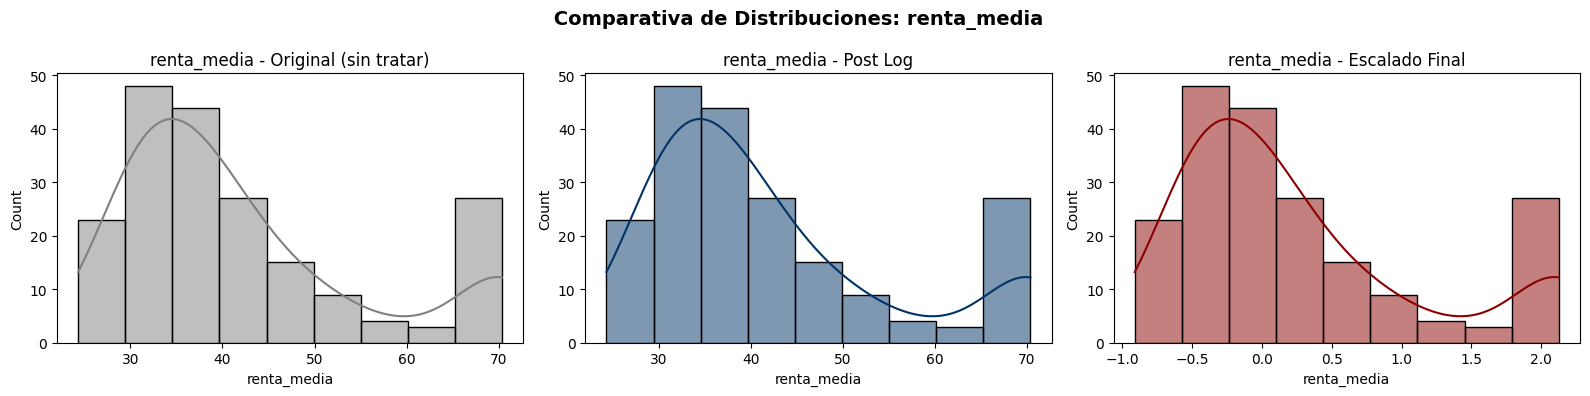

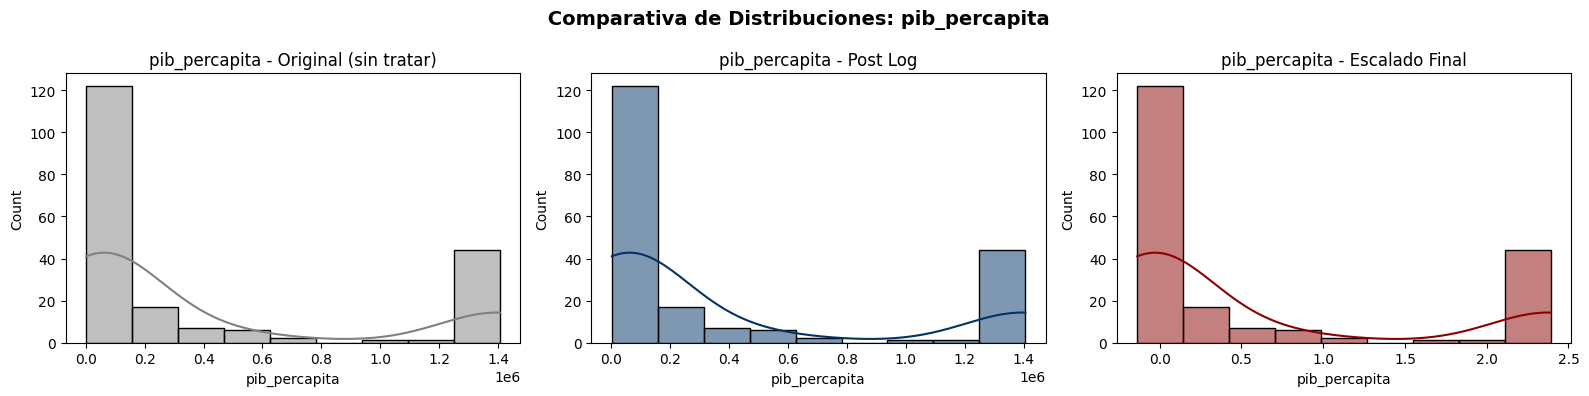

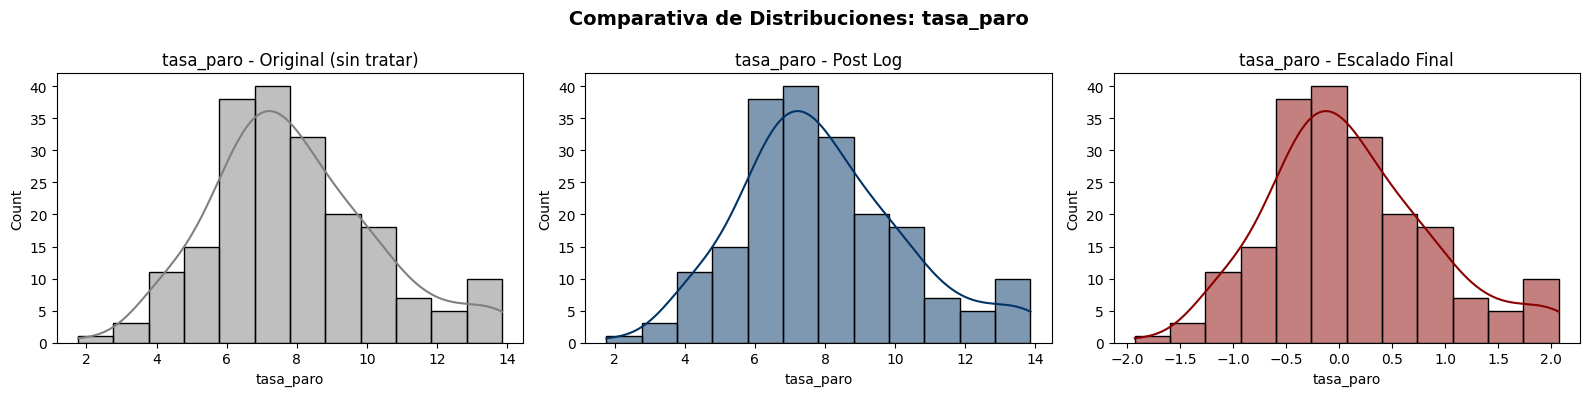

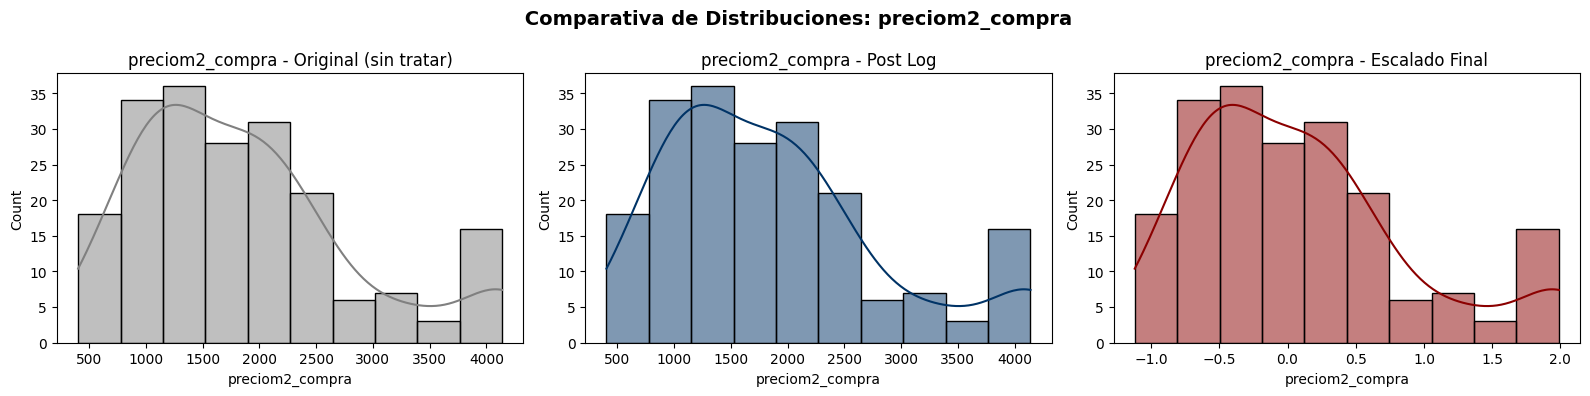

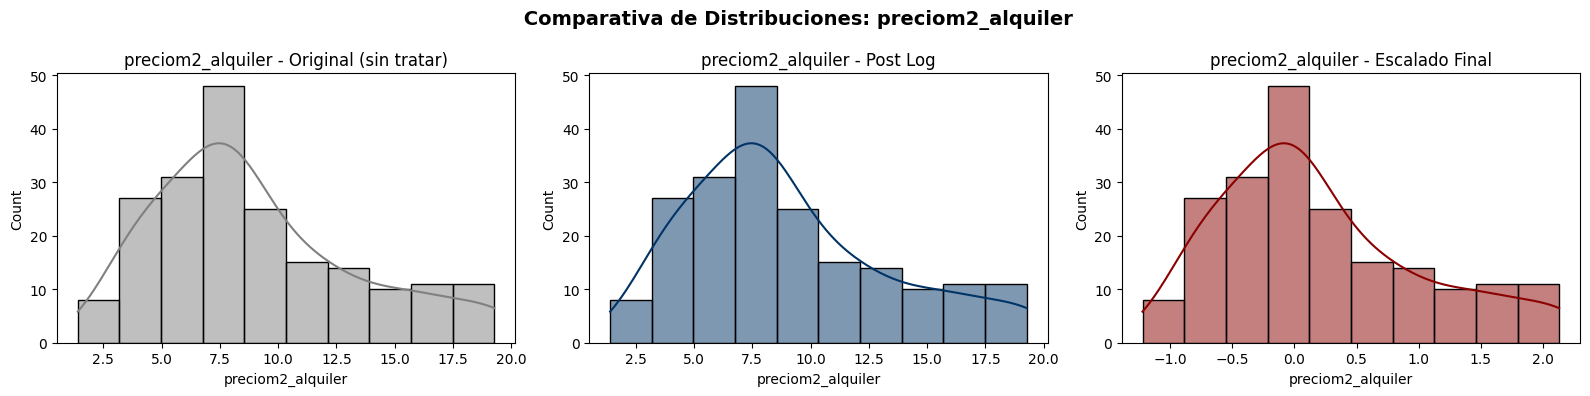

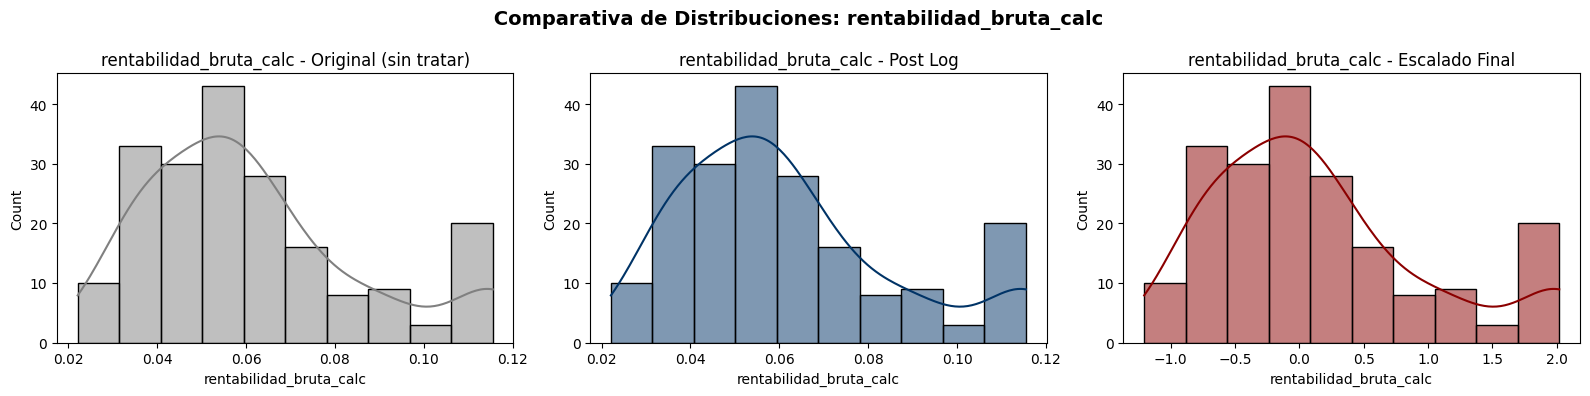

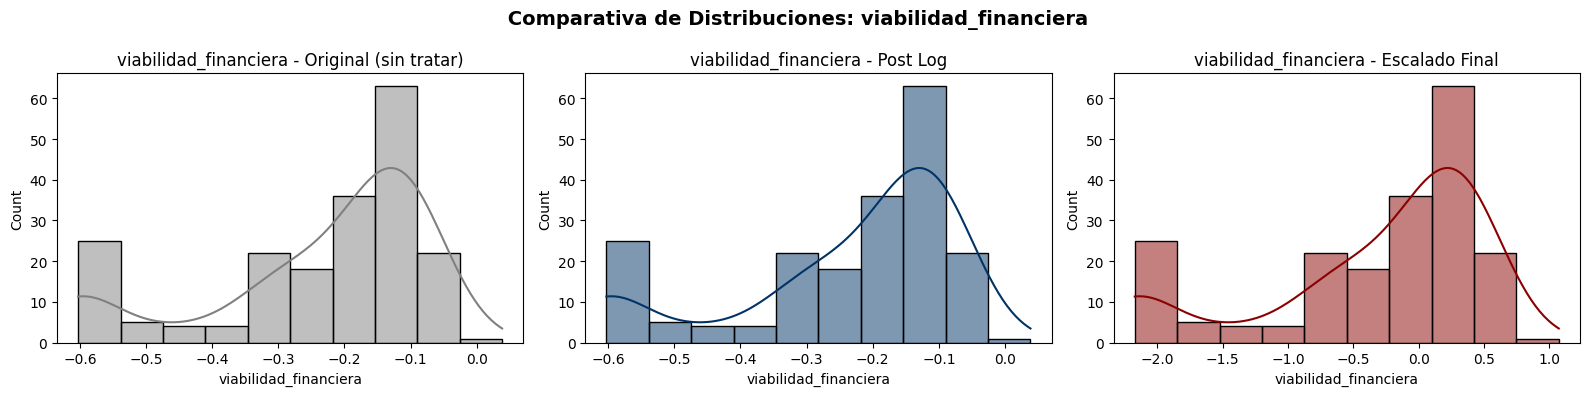

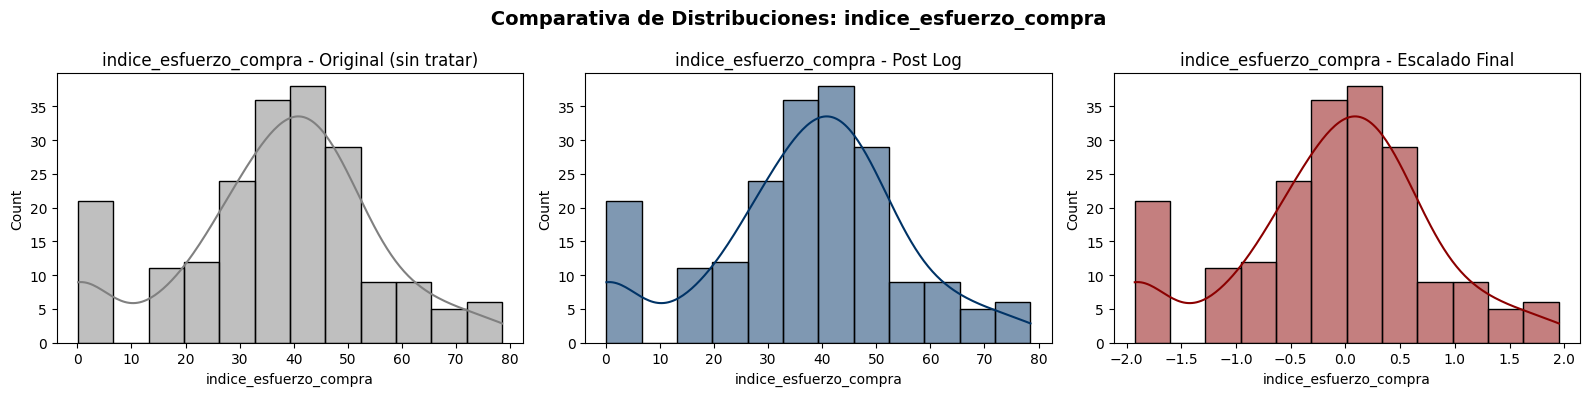

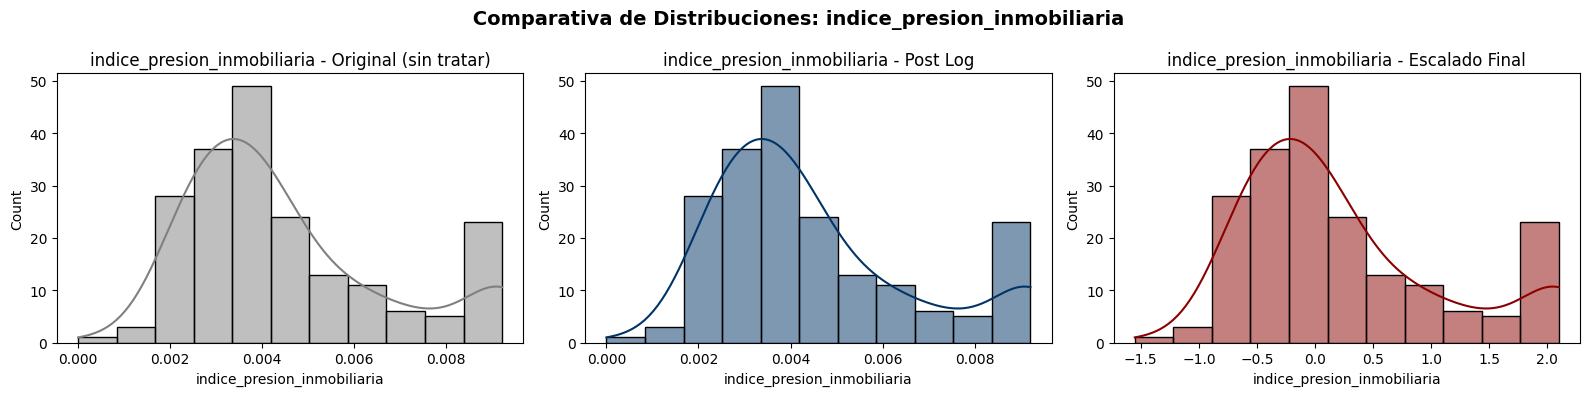

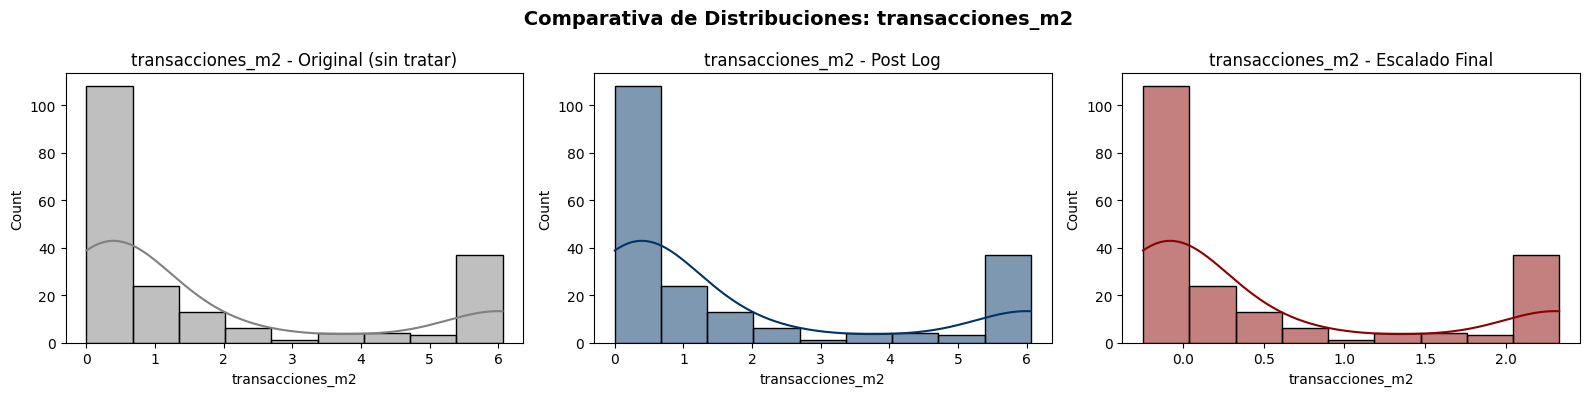

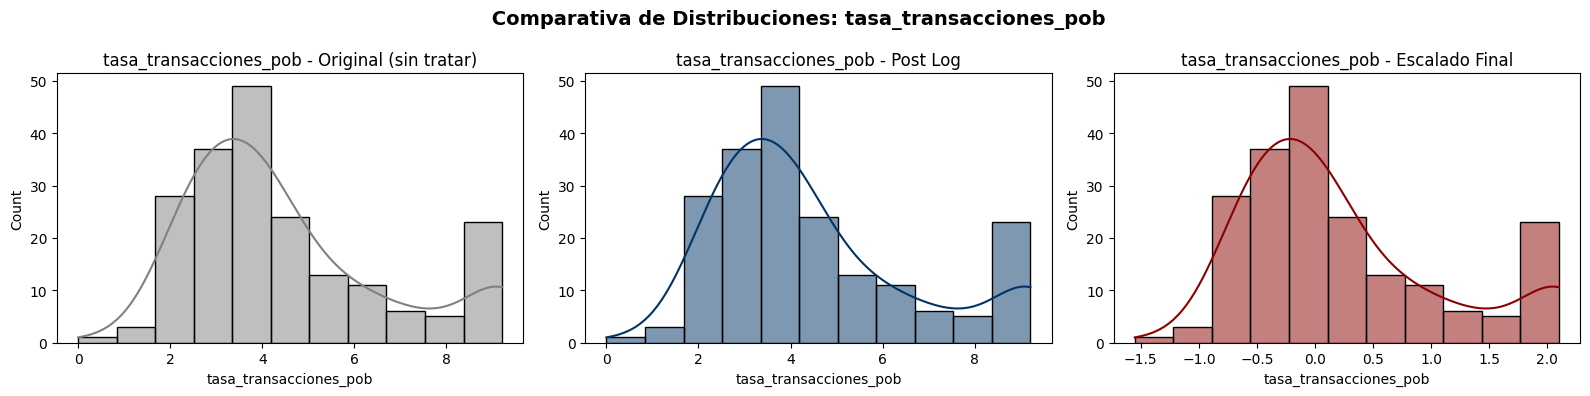

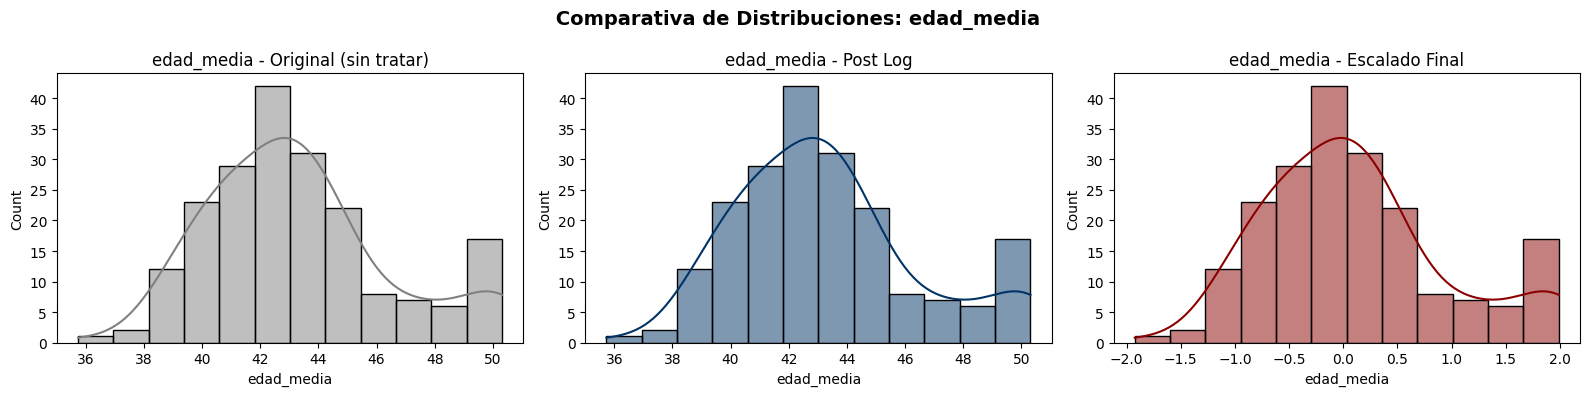

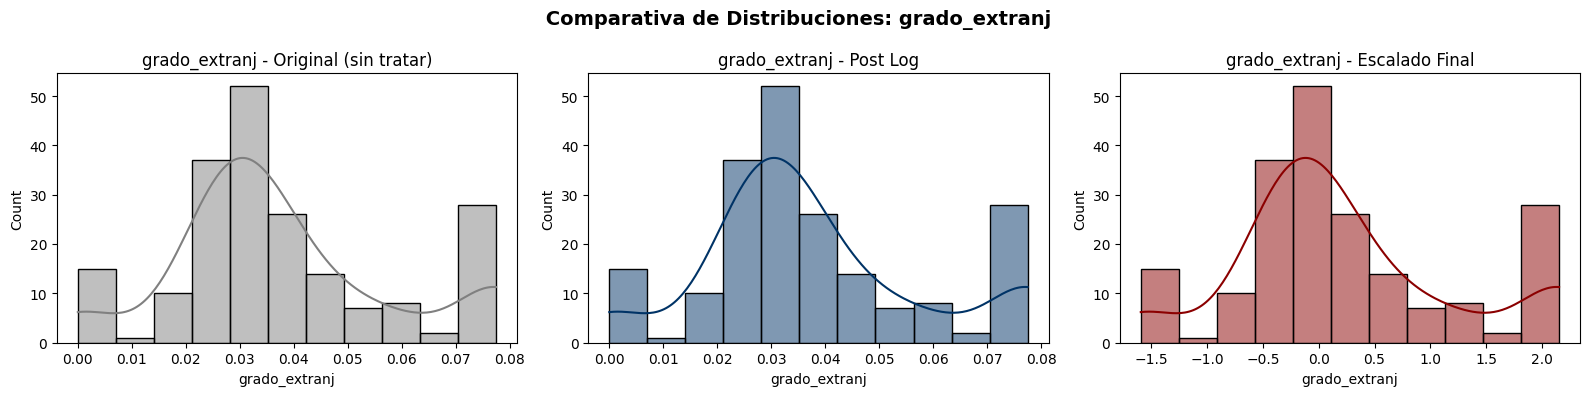

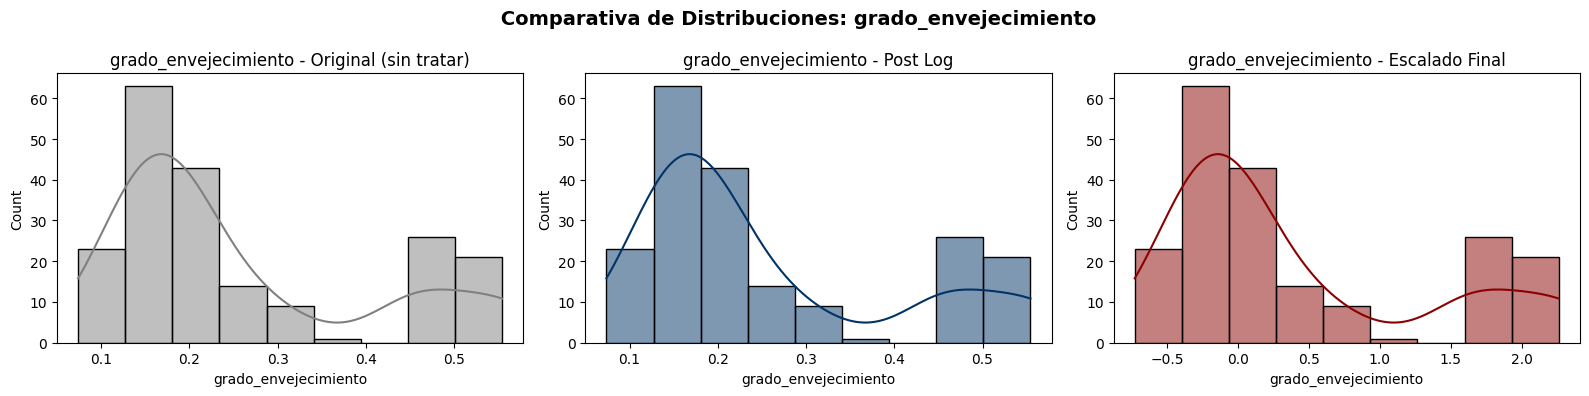

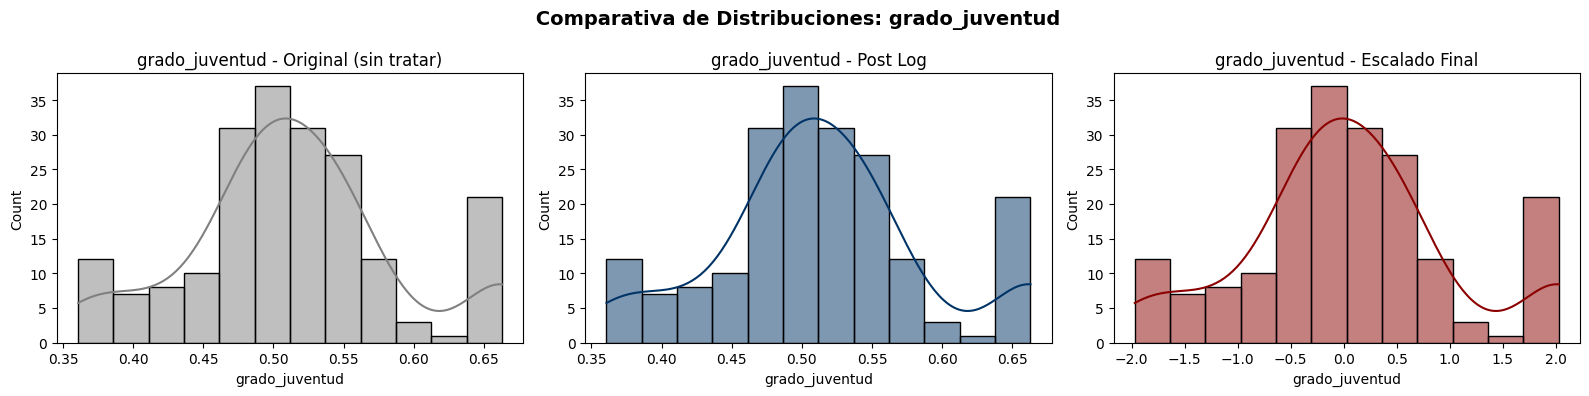

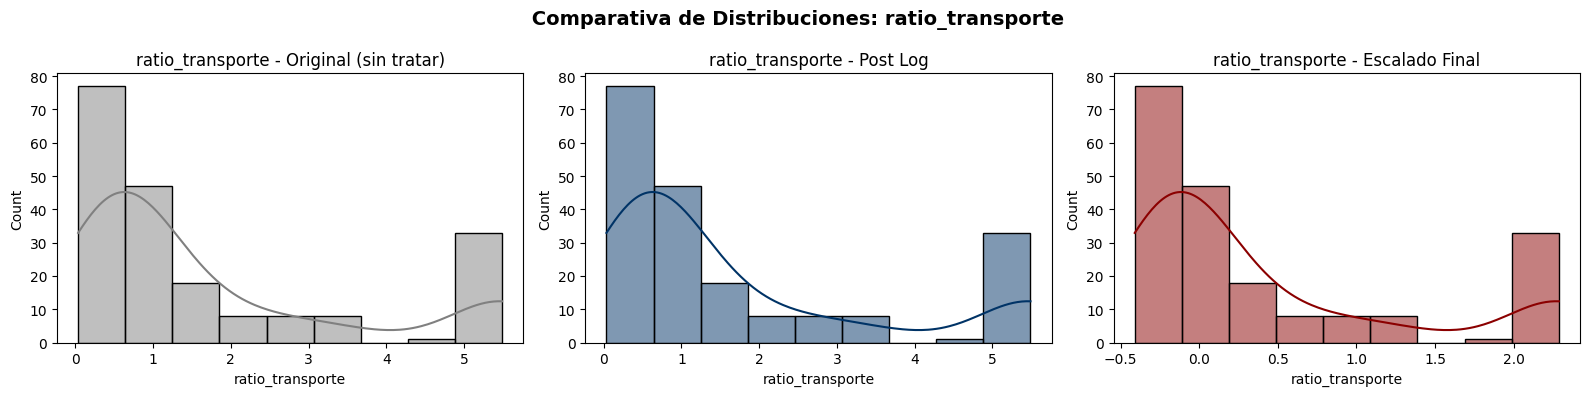

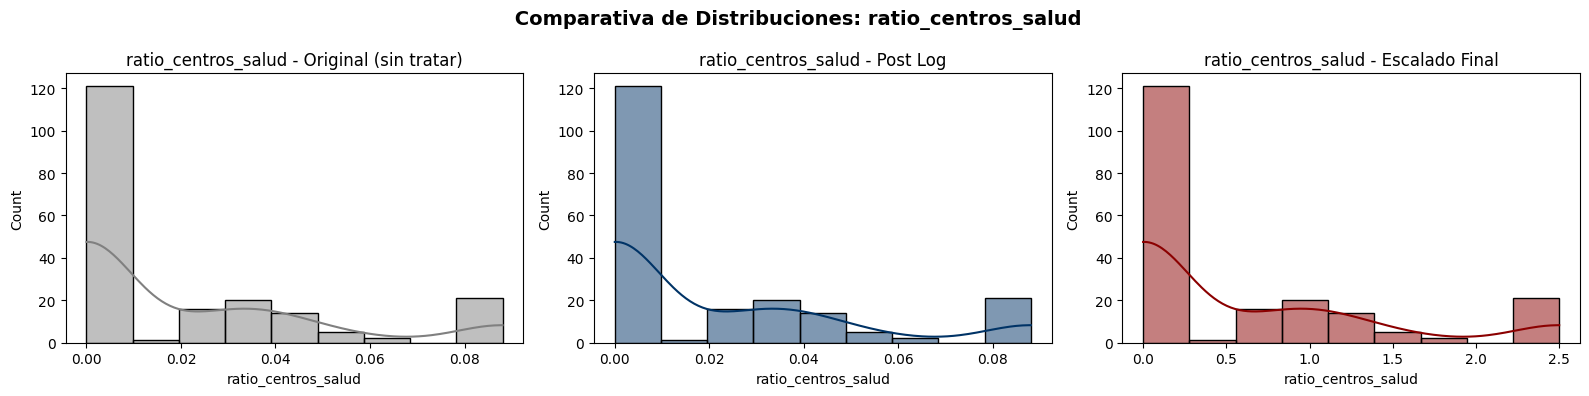

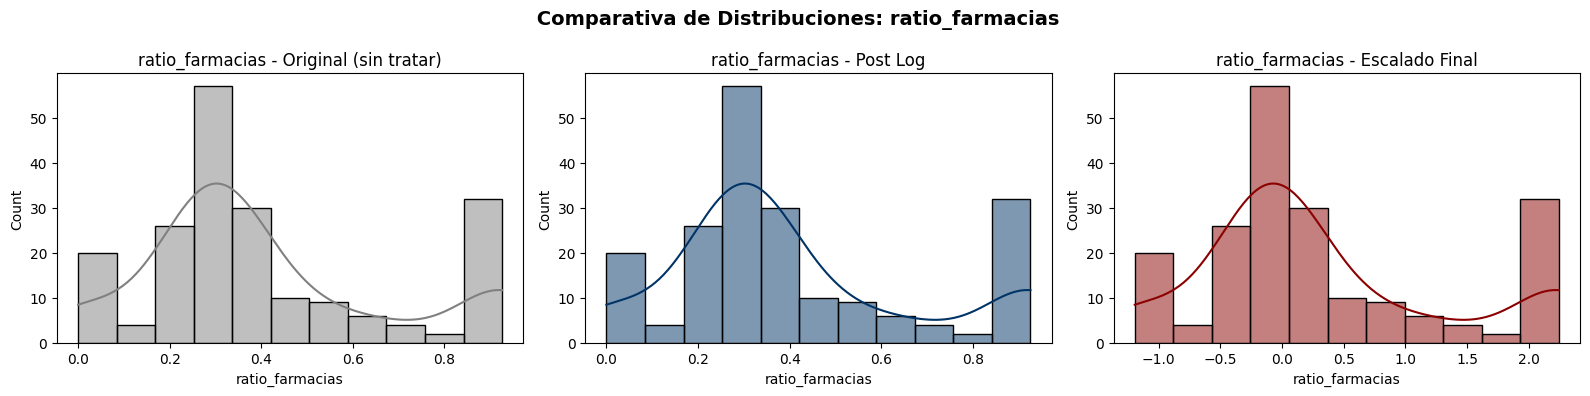

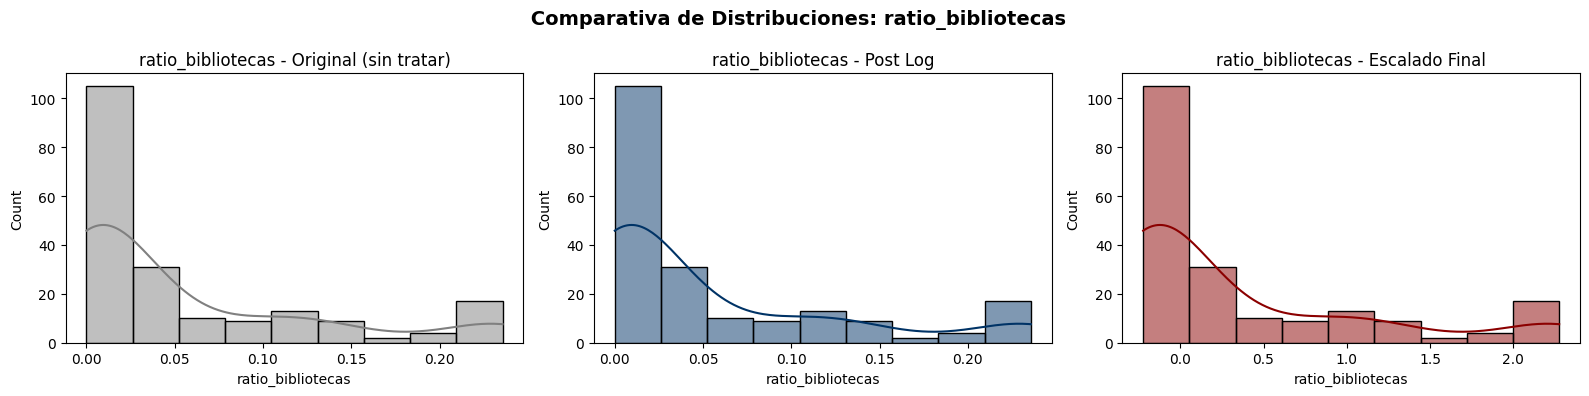

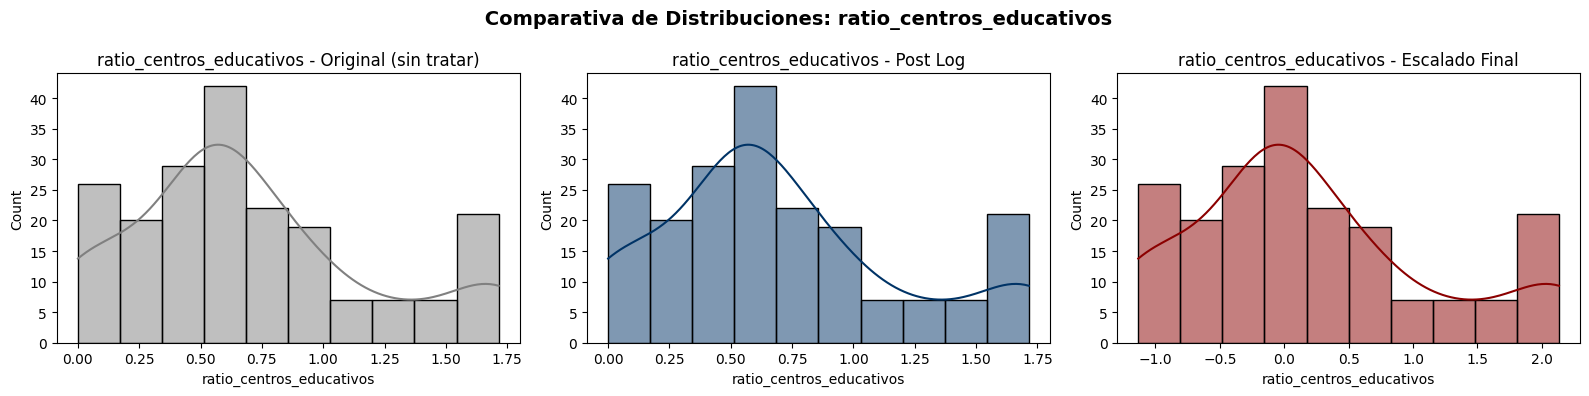

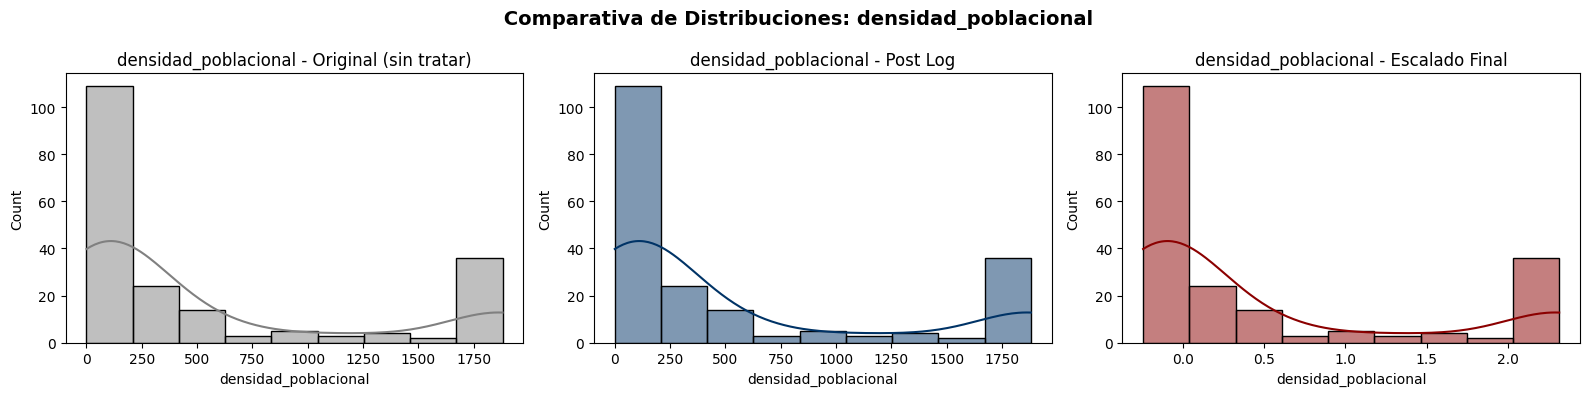

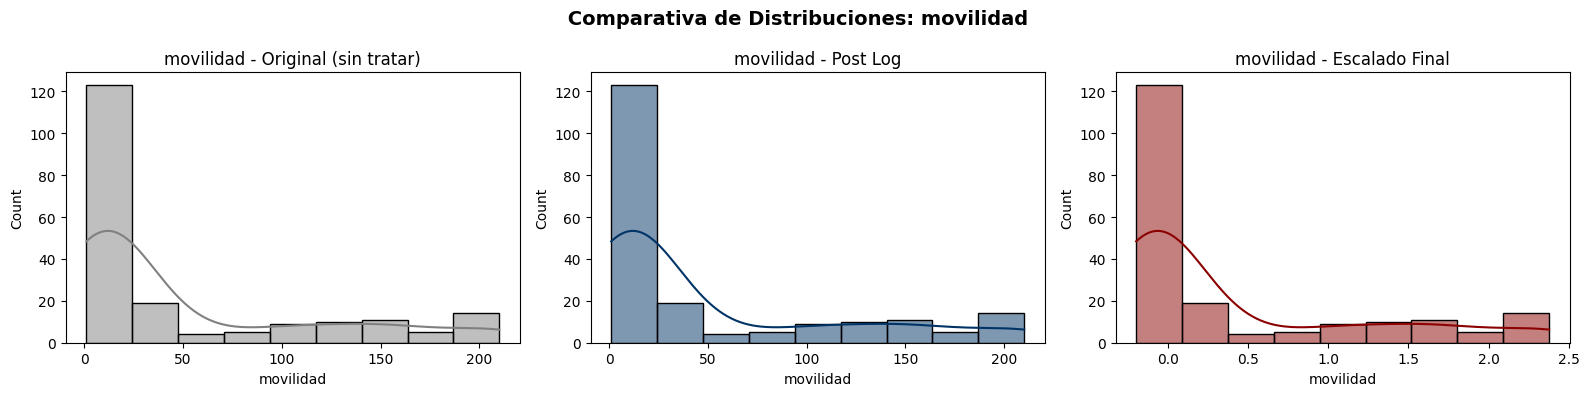

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Lista de variables a comparar
variables_comunes = df_escalado.columns.drop(['municipio_cm', 'distrito_cm'])

# Asegurar origen: original sin tratar, post-log, y escalado
df_original_plot = df_numericas[variables_comunes]             # antes del log
df_log_plot = df_transformado[variables_comunes]               # después del log
df_scaled_plot = df_escalado[variables_comunes]                # después del escalado

# Visualización triple para cada variable
for col in variables_comunes:
    plt.figure(figsize=(16, 4))

    # Histograma original
    plt.subplot(1, 3, 1)
    sns.histplot(df_original_plot[col], kde=True, color='gray')
    plt.title(f'{col} - Original (sin tratar)')

    # Histograma post-log
    plt.subplot(1, 3, 2)
    sns.histplot(df_log_plot[col], kde=True, color='#003366')
    plt.title(f'{col} - Post Log')

    # Histograma post-escalado
    plt.subplot(1, 3, 3)
    sns.histplot(df_scaled_plot[col], kde=True, color='darkred')
    plt.title(f'{col} - Escalado Final')

    plt.suptitle(f' Comparativa de Distribuciones: {col}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


In [ ]:
# --------- 10. GUARDADO ---------
df_escalado.to_excel("/content/BBDD_E1_listo.xlsx", index=False)

### **B8 - ANÁLISIS EXPLORATORIO (EDA)**

**B8.1 - MEDIDAS EXPLORATORIAS**

In [ ]:
# --------- MEDIDAS EXPLORATORIAS DESCRIPTIVAS ---------
# Crear subconjunto numérico a partir del DataFrame escalado
df_completo= df_escalado.select_dtypes(include='number')

# Medidas descriptivas y asimetría
descripcion = df_completo.describe().T
descripcion['skew'] = df_completo.skew()

# Mostrar resultados
descripcion
descripcion = df_completo.describe().T
descripcion['skew'] = df_completo.skew()

display(Markdown("**Resumen estadístico de las variables numéricas:**"))
display(descripcion)


**Resumen estadístico de las variables numéricas:**

count       mean        std         min  \
renta_media                  200.0   1.737787   5.135301   -0.797319   
pib_percapita                200.0   0.206529   0.872664   -0.863873   
tasa_paro                    200.0  -0.000934   0.898343   -6.204848   
paro_diff                    200.0   0.034297   0.880208   -1.296875   
preciom2_compra              200.0   0.126009   0.868606   -0.900291   
preciom2_alquiler            200.0   0.238675   0.905558   -1.224988   
rentabilidad_bruta_calc      200.0   0.210557   0.960924   -0.864855   
viabilidad_financiera        200.0 -16.456359  48.731585 -178.448210   
indice_esfuerzo_compra       200.0  -0.088500   0.935371   -1.925630   
indice_presion_inmobiliaria  200.0   0.319949   1.051437   -0.733821   
transacciones_m2             200.0   0.554600   1.295013   -0.403221   
tasa_transacciones_pob       200.0   0.319949   1.051437   -0.733821   
proporcion_nueva             200.0   0.451310   1.006863   -0.279031   
proporcion_protegida         200.0   0.726837   1.278568    0.000000   
edad_media                   200.0   0.112180   0.836374   -1.059021   
grado_extranj                200.0   0.780531   2.348893   -1.623625   
grado_envejecimiento         200.0   2.496828   6.854336   -0.522732   
grado_juventud               200.0   4.824268  14.681736   -1.795952   
ratio_transporte             200.0   0.342761   0.880399   -0.509080   
ratio_centros_salud          200.0   0.749074   1.357556    0.000000   
ratio_farmacias              200.0   0.463599   1.474237   -1.431133   
ratio_bibliotecas            200.0   0.394172   0.898078   -0.231410   
ratio_centros_educativos     200.0   0.307858   1.214596   -1.132988   
densidad_poblacional         200.0   0.038256   0.770717   -1.230488   
movilidad                    200.0   0.414369   0.804632   -0.196923   

                                  25%           50%       75%        max  \
renta_media                 -0.420405 -5.926249e-16  0.579595  16.712983   
pib_percapita               -0.425254  2.560886e-16  0.574746   2.150723   
tasa_paro                   -0.472723  0.000000e+00  0.527277   3.191325   
paro_diff                   -0.515625  0.000000e+00  0.484375   2.048437   
preciom2_compra             -0.511439  0.000000e+00  0.488561   2.496090   
preciom2_alquiler           -0.366369  0.000000e+00  0.633631   3.415688   
rentabilidad_bruta_calc     -0.481013  0.000000e+00  0.518987   2.760147   
viabilidad_financiera       -0.672192  7.025630e-17  0.327808   0.529100   
indice_esfuerzo_compra      -0.550312  0.000000e+00  0.449688   3.862902   
indice_presion_inmobiliaria -0.401142  0.000000e+00  0.598858   3.096674   
transacciones_m2            -0.262038  2.515349e-17  0.737962   4.305695   
tasa_transacciones_pob      -0.401142  0.000000e+00  0.598858   3.096674   
proporcion_nueva            -0.279031  0.000000e+00  0.720969   3.099070   
proporcion_protegida         0.000000  0.000000e+00  1.000000   4.425735   
edad_media                  -0.511066  0.000000e+00  0.488934   2.063179   
grado_extranj               -0.350518  0.000000e+00  0.649482   7.712078   
grado_envejecimiento        -0.249492  1.058181e-16  0.750508  22.859033   
grado_juventud              -0.477621  0.000000e+00  0.522379  48.315460   
ratio_transporte            -0.296973  0.000000e+00  0.703027   2.476688   
ratio_centros_salud          0.000000  0.000000e+00  1.000000   5.287109   
ratio_farmacias             -0.275909  1.426810e-16  0.724091   4.460127   
ratio_bibliotecas           -0.231410  0.000000e+00  0.768590   2.969486   
ratio_centros_educativos    -0.366942 -1.057097e-16  0.633058   3.713023   
densidad_poblacional        -0.486675  0.000000e+00  0.513325   1.588273   
movilidad                   -0.123077  0.000000e+00  0.876923   2.414154   

                                 skew  
renta_media                  2.538539  
pib_percapita                1.004113  
tasa_paro                   -1.474446  
paro_diff          

**B8.2 - VISUALIZACIÓN EXPLORATORIAS**

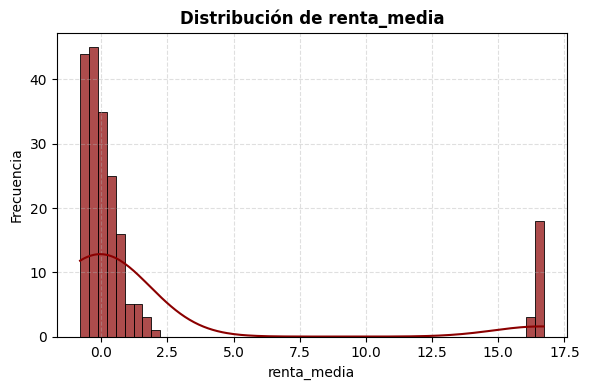

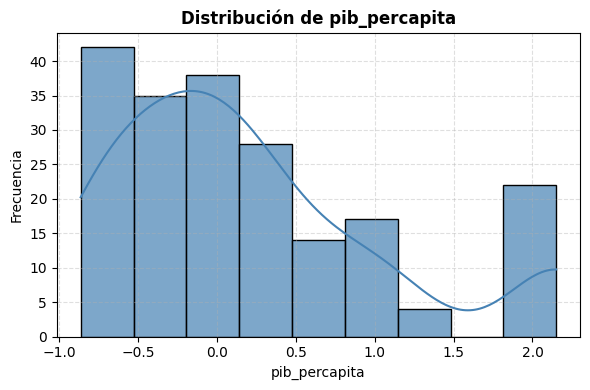

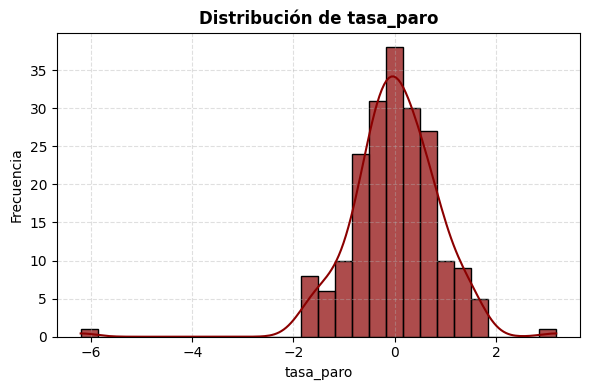

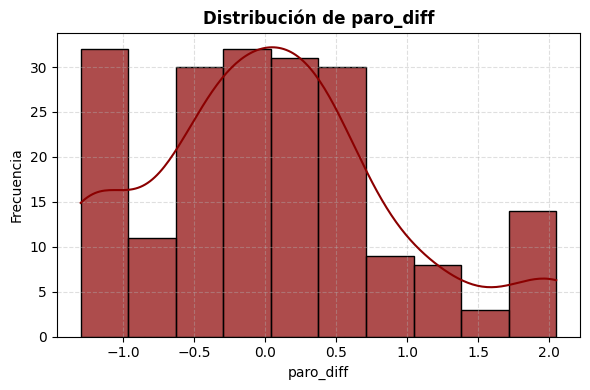

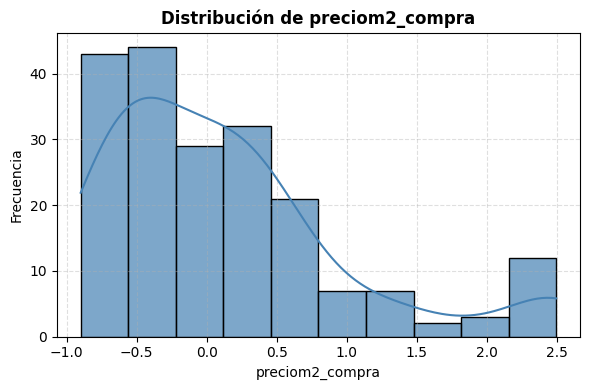

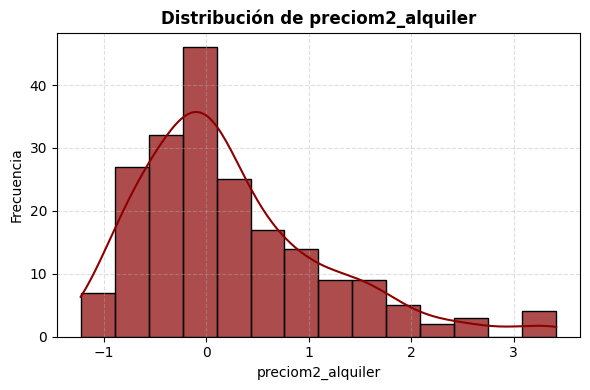

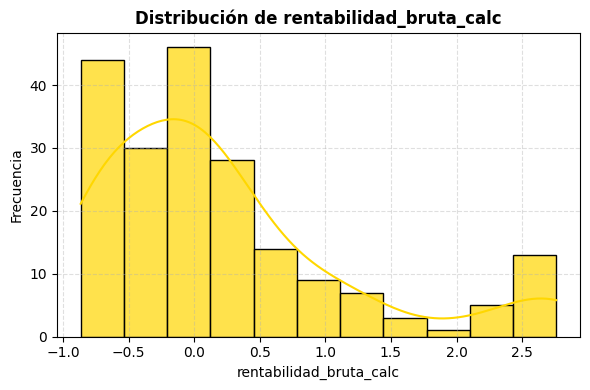

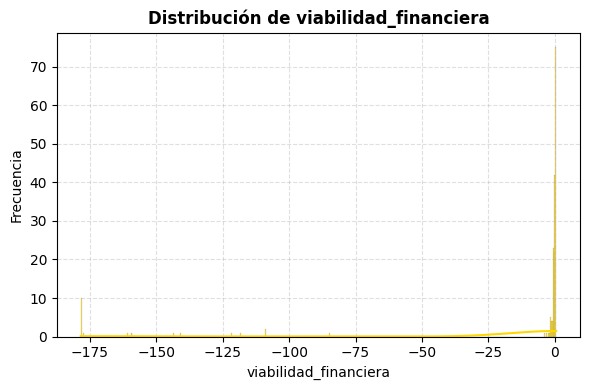

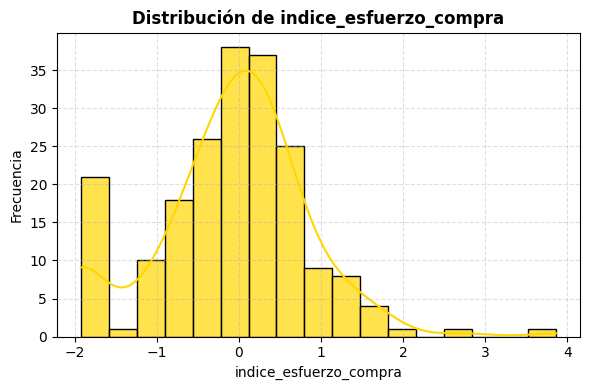

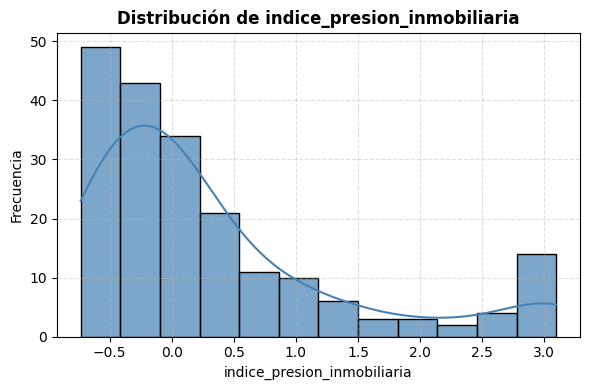

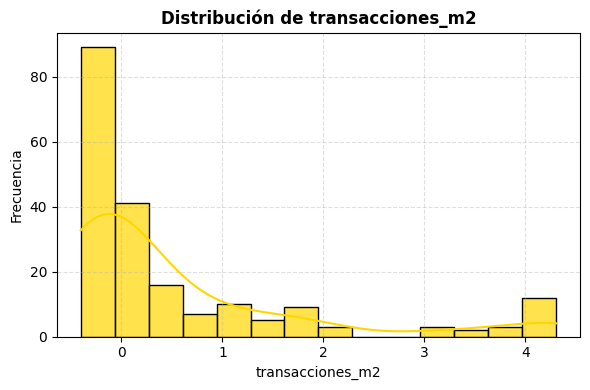

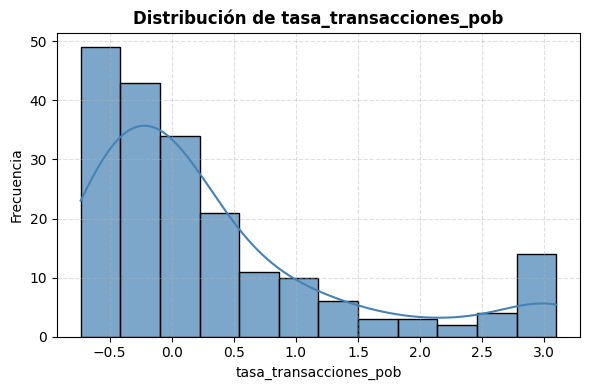

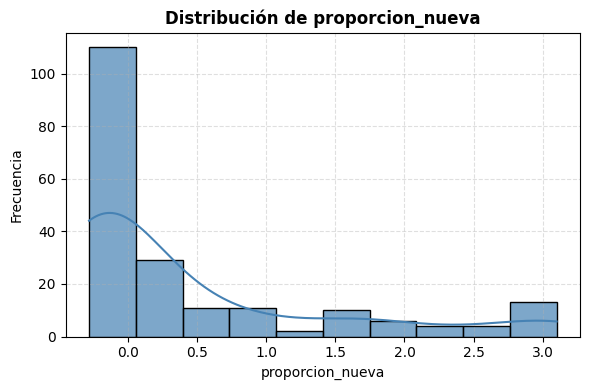

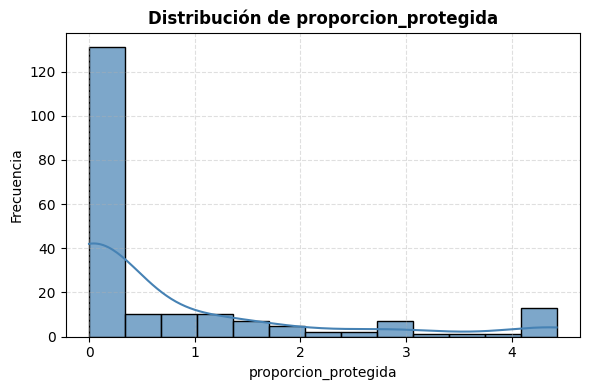

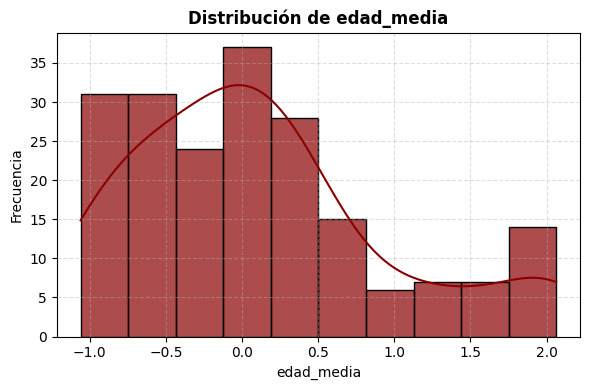

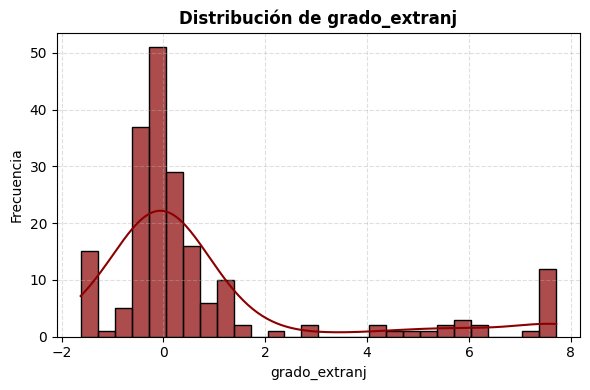

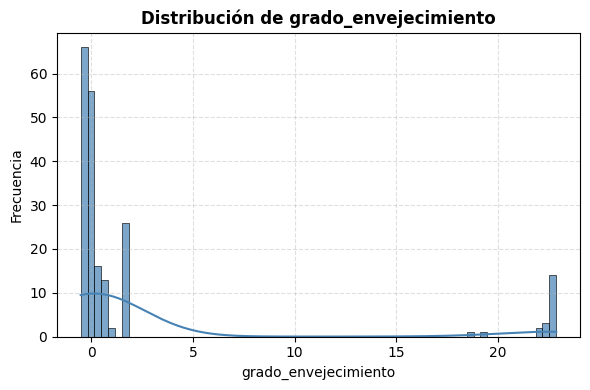

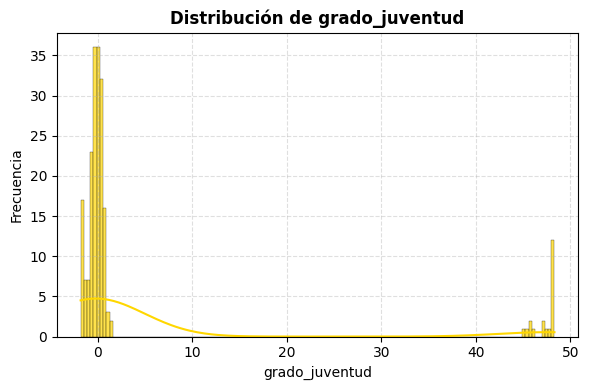

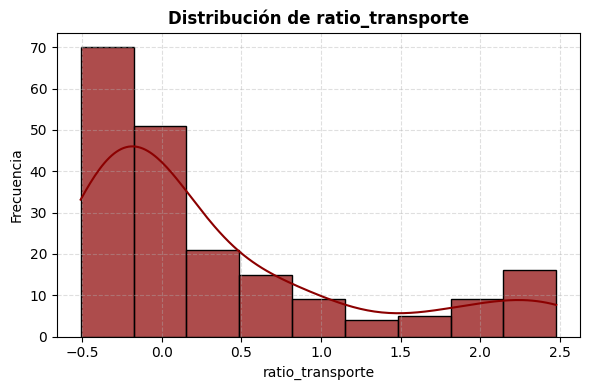

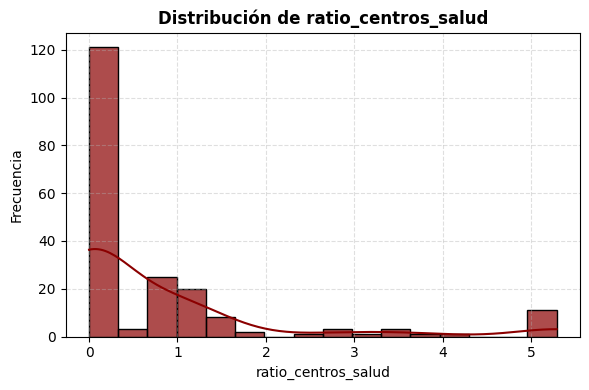

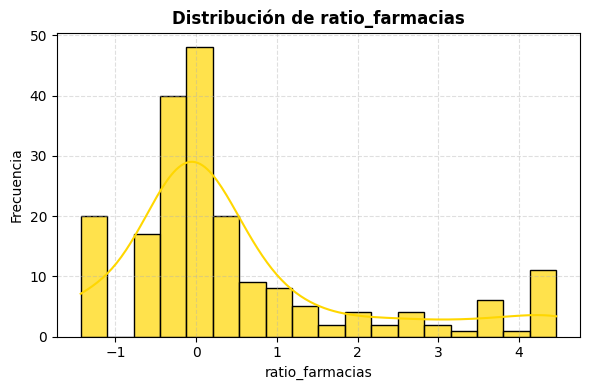

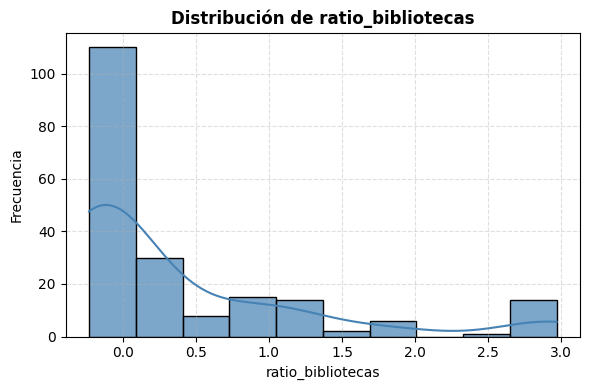

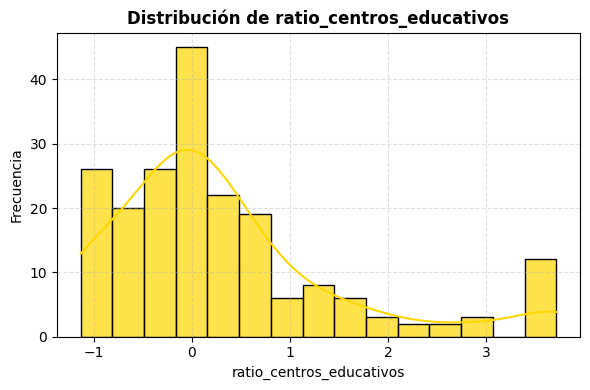

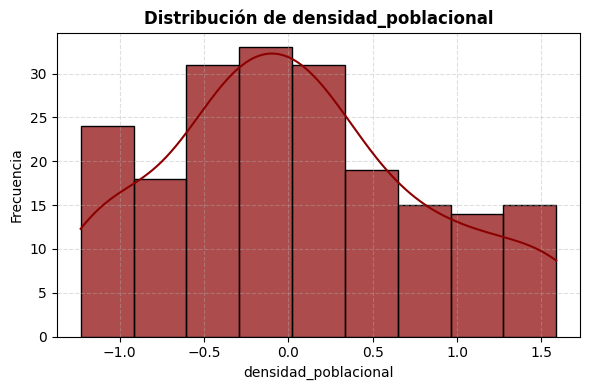

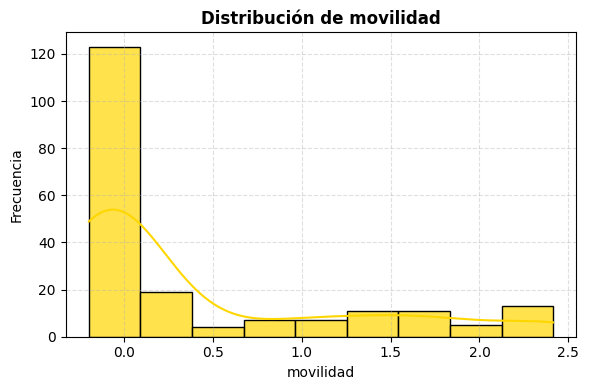

In [ ]:
# --------- HISTOGRAMA ---------
for col in df_completo.columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(df_completo[col], kde=True,
                 color=np.random.choice(['darkred', 'gold', 'steelblue']),
                 alpha=0.7)
    plt.title(f"Distribución de {col}", fontweight='bold')
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

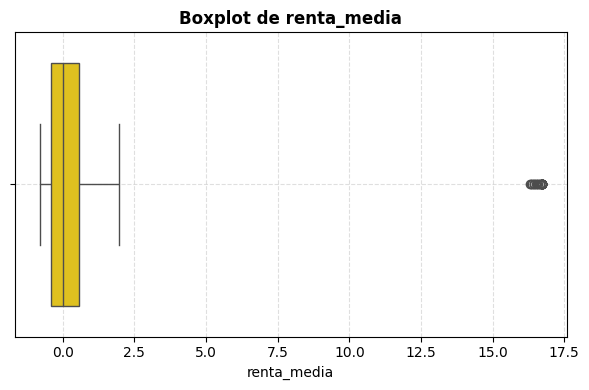

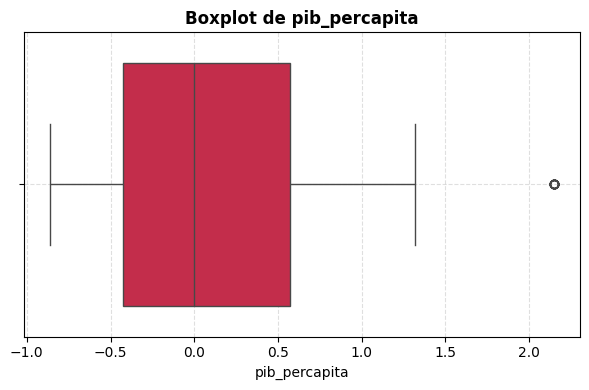

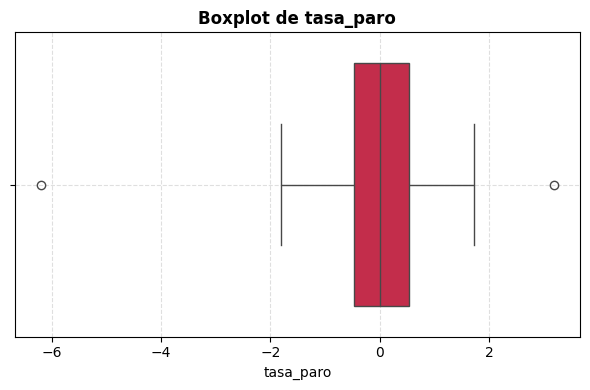

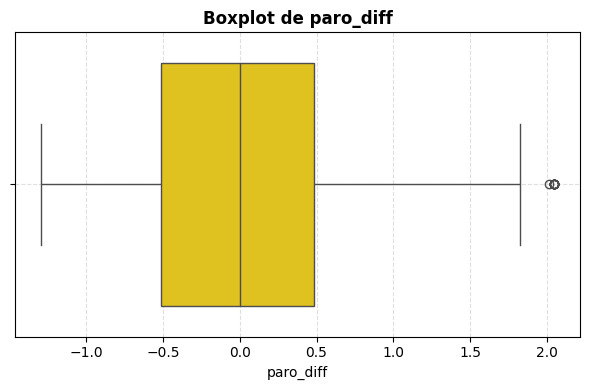

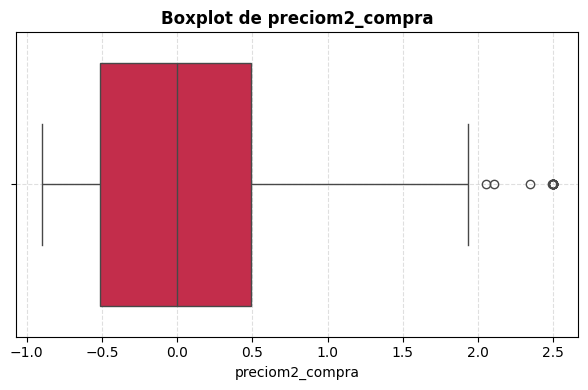

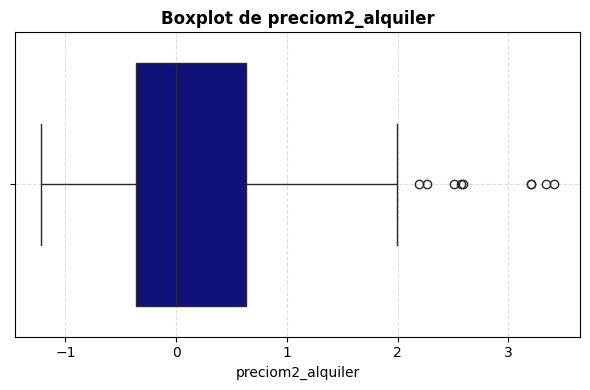

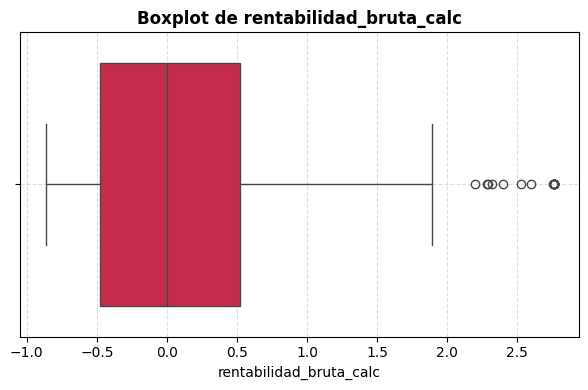

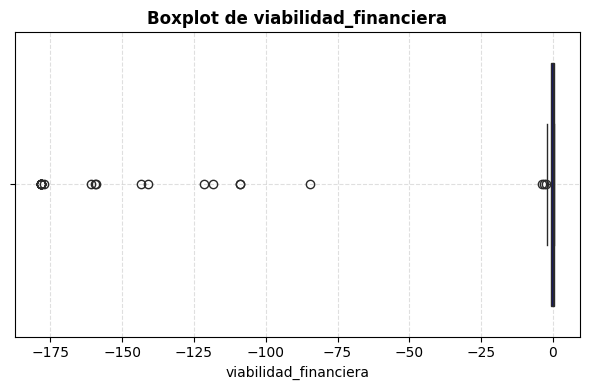

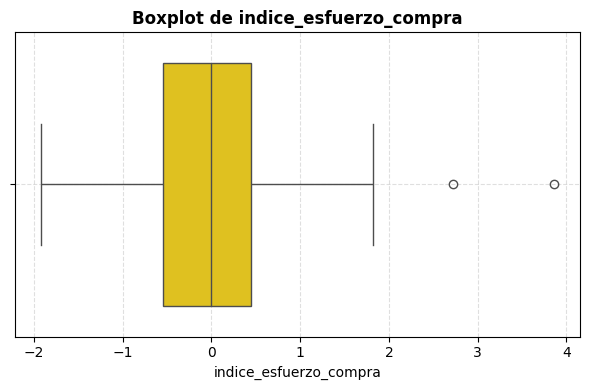

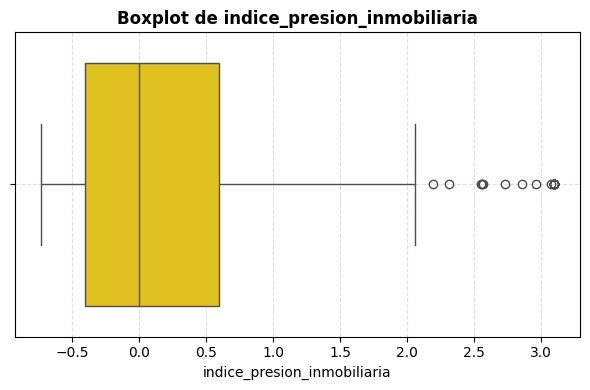

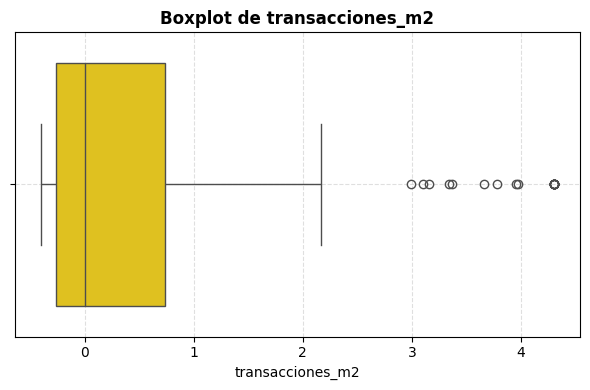

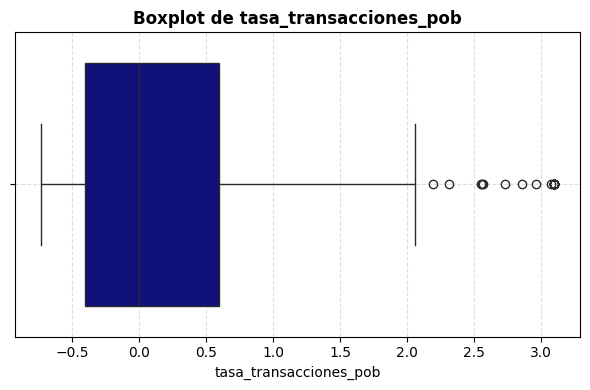

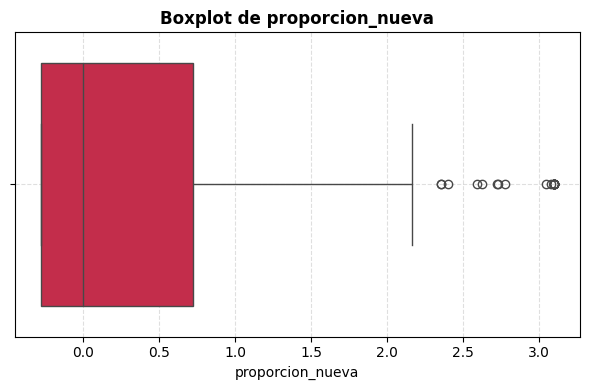

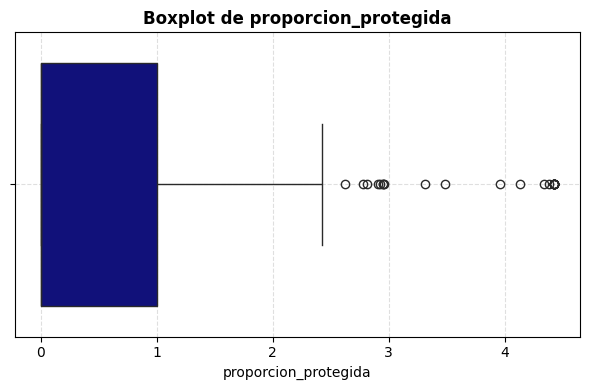

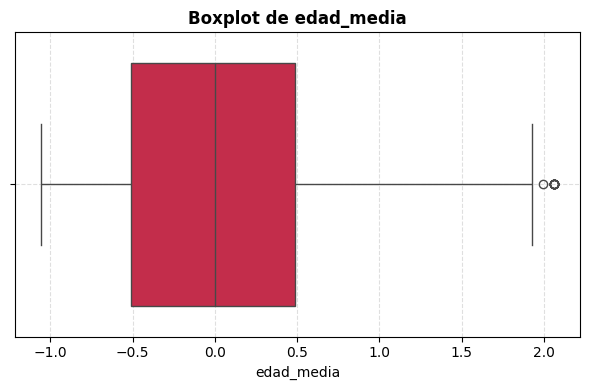

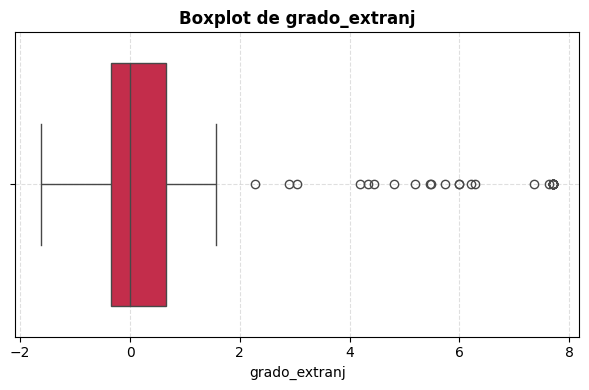

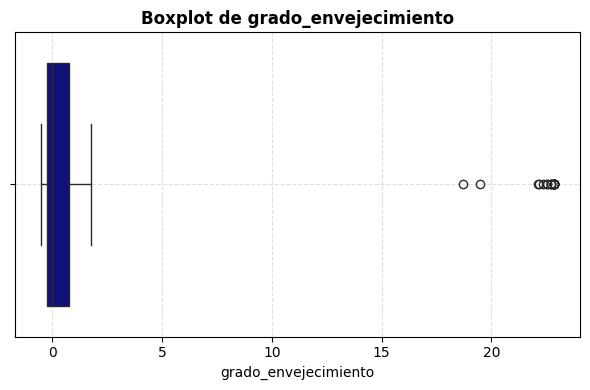

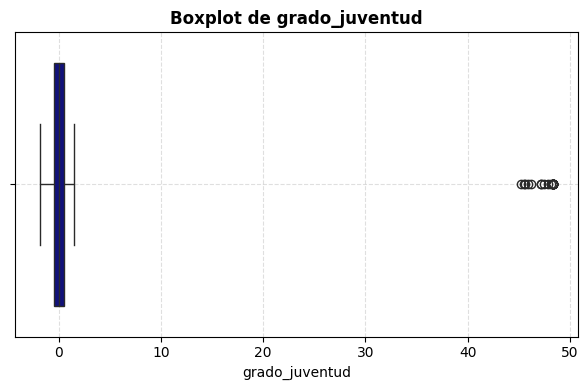

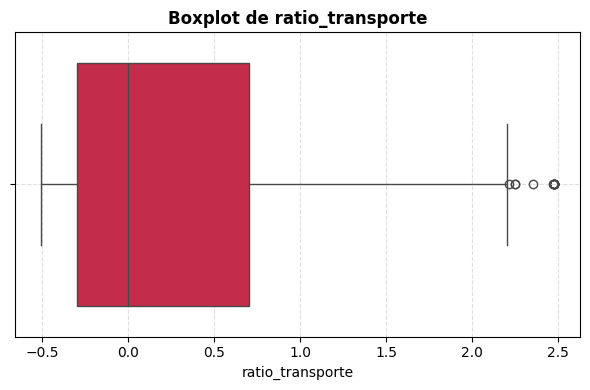

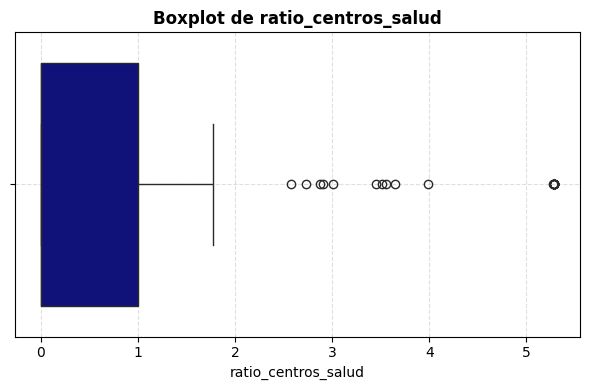

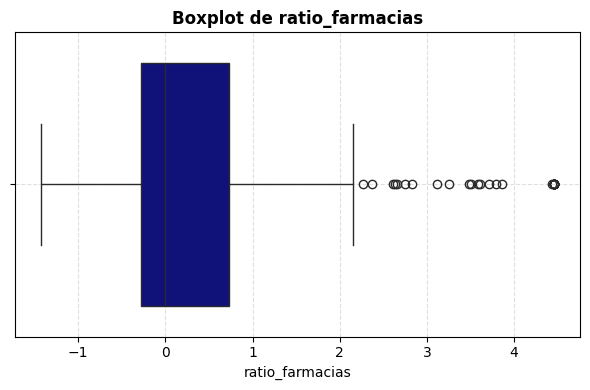

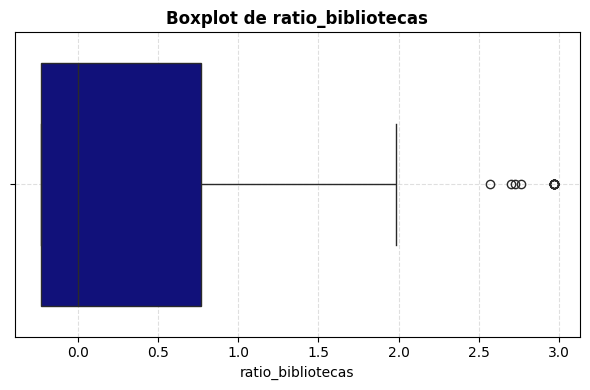

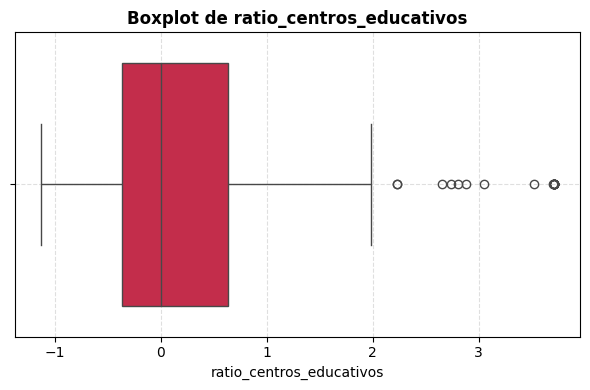

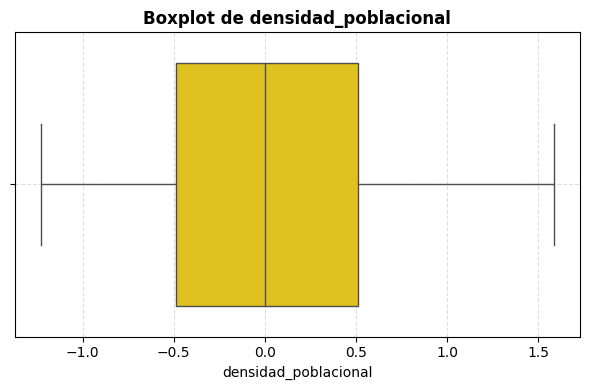

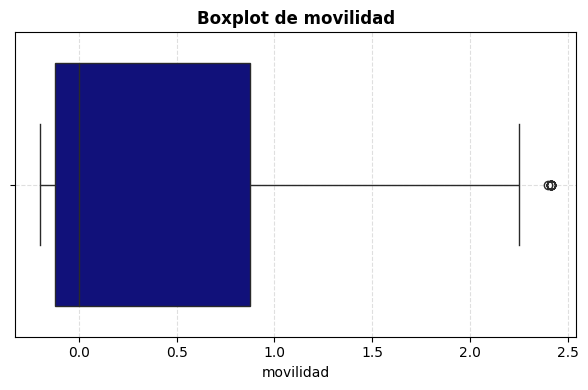

In [ ]:
# --------- BOXPLOT PARA OUTLIERS ---------
for col in df_completo.columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df_completo[col],
                color=np.random.choice(['crimson', 'darkblue', 'gold']))
    plt.title(f"Boxplot de {col}", fontweight='bold')
    plt.xlabel(col)
    plt.tight_layout()
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.show()


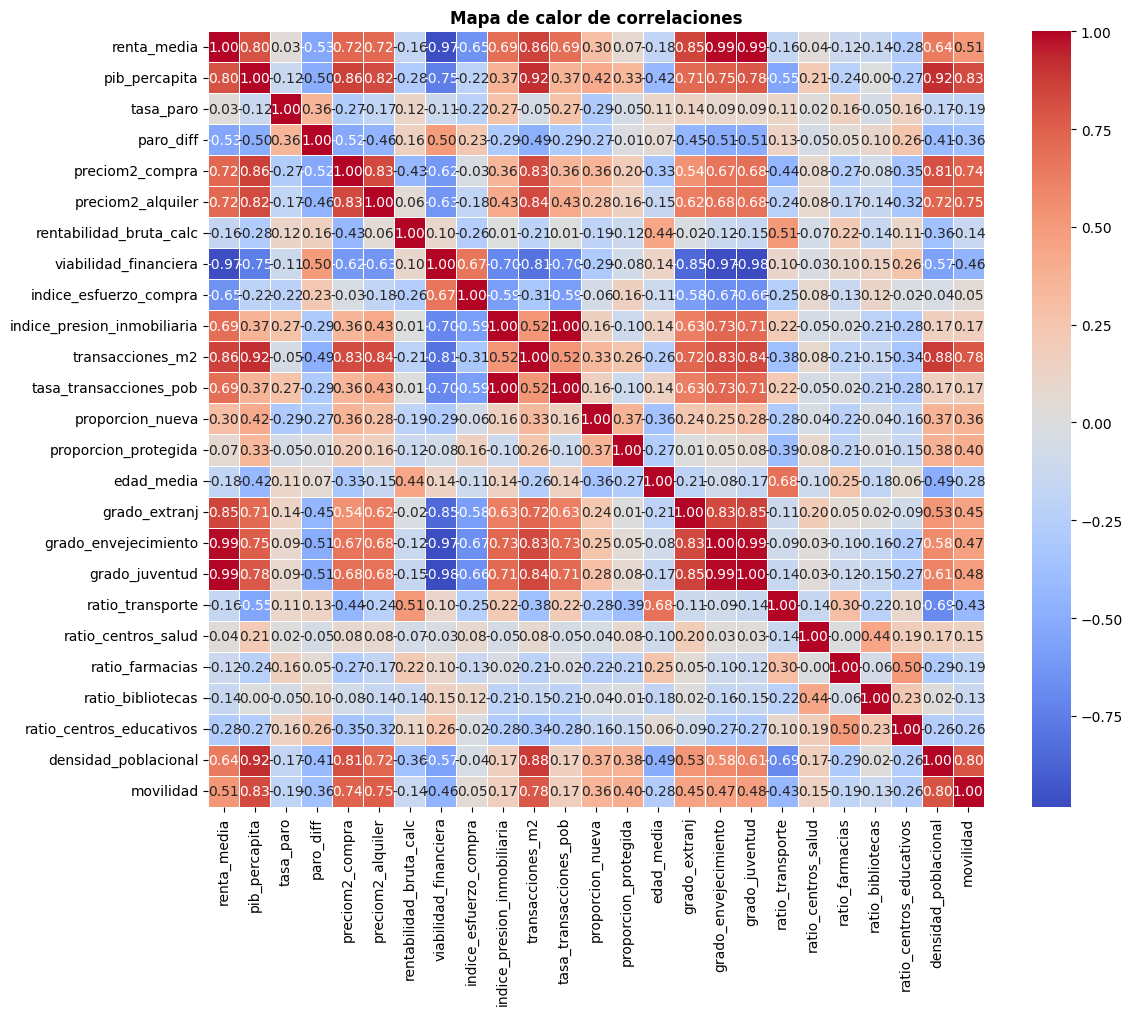

In [ ]:
# --------- MAPA DE CALOR DE CORRELACIONES ---------
plt.figure(figsize=(12, 10))
correlation_matrix = df_completo.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm",
            square=True, cbar=True, linewidths=0.5)
plt.title("Mapa de calor de correlaciones", fontweight='bold')
plt.tight_layout()
plt.show()


In [ ]:
# --------- MATRIZ DE CONTINGENCIA ---------
# Crear cuartiles para dos variables
df_completo['cuartil_renta'] = pd.qcut(df_completo['renta_media'], q=4, labels=["baja", "media-baja", "media-alta", "alta"])
df_completo['cuartil_rentabilidad'] = pd.qcut(df_completo['rentabilidad_bruta_calc'], q=4, labels=["baja", "media-baja", "media-alta", "alta"])

# Crear matriz de contingencia
contingencia = pd.crosstab(df_completo['cuartil_renta'], df_completo['cuartil_rentabilidad'], margins=True)
display(Markdown("**Matriz de contingencia entre cuartiles de renta y rentabilidad:**"))
display(contingencia)


**Matriz de contingencia entre cuartiles de renta y rentabilidad:**

cuartil_rentabilidad  baja  media-baja  media-alta  alta  All
cuartil_renta                                                
baja                     9           6          10    25   50
media-baja              13           9          15    13   50
media-alta              17          14          14     5   50
alta                    11          21          11     7   50
All                     50          50          50    50  200

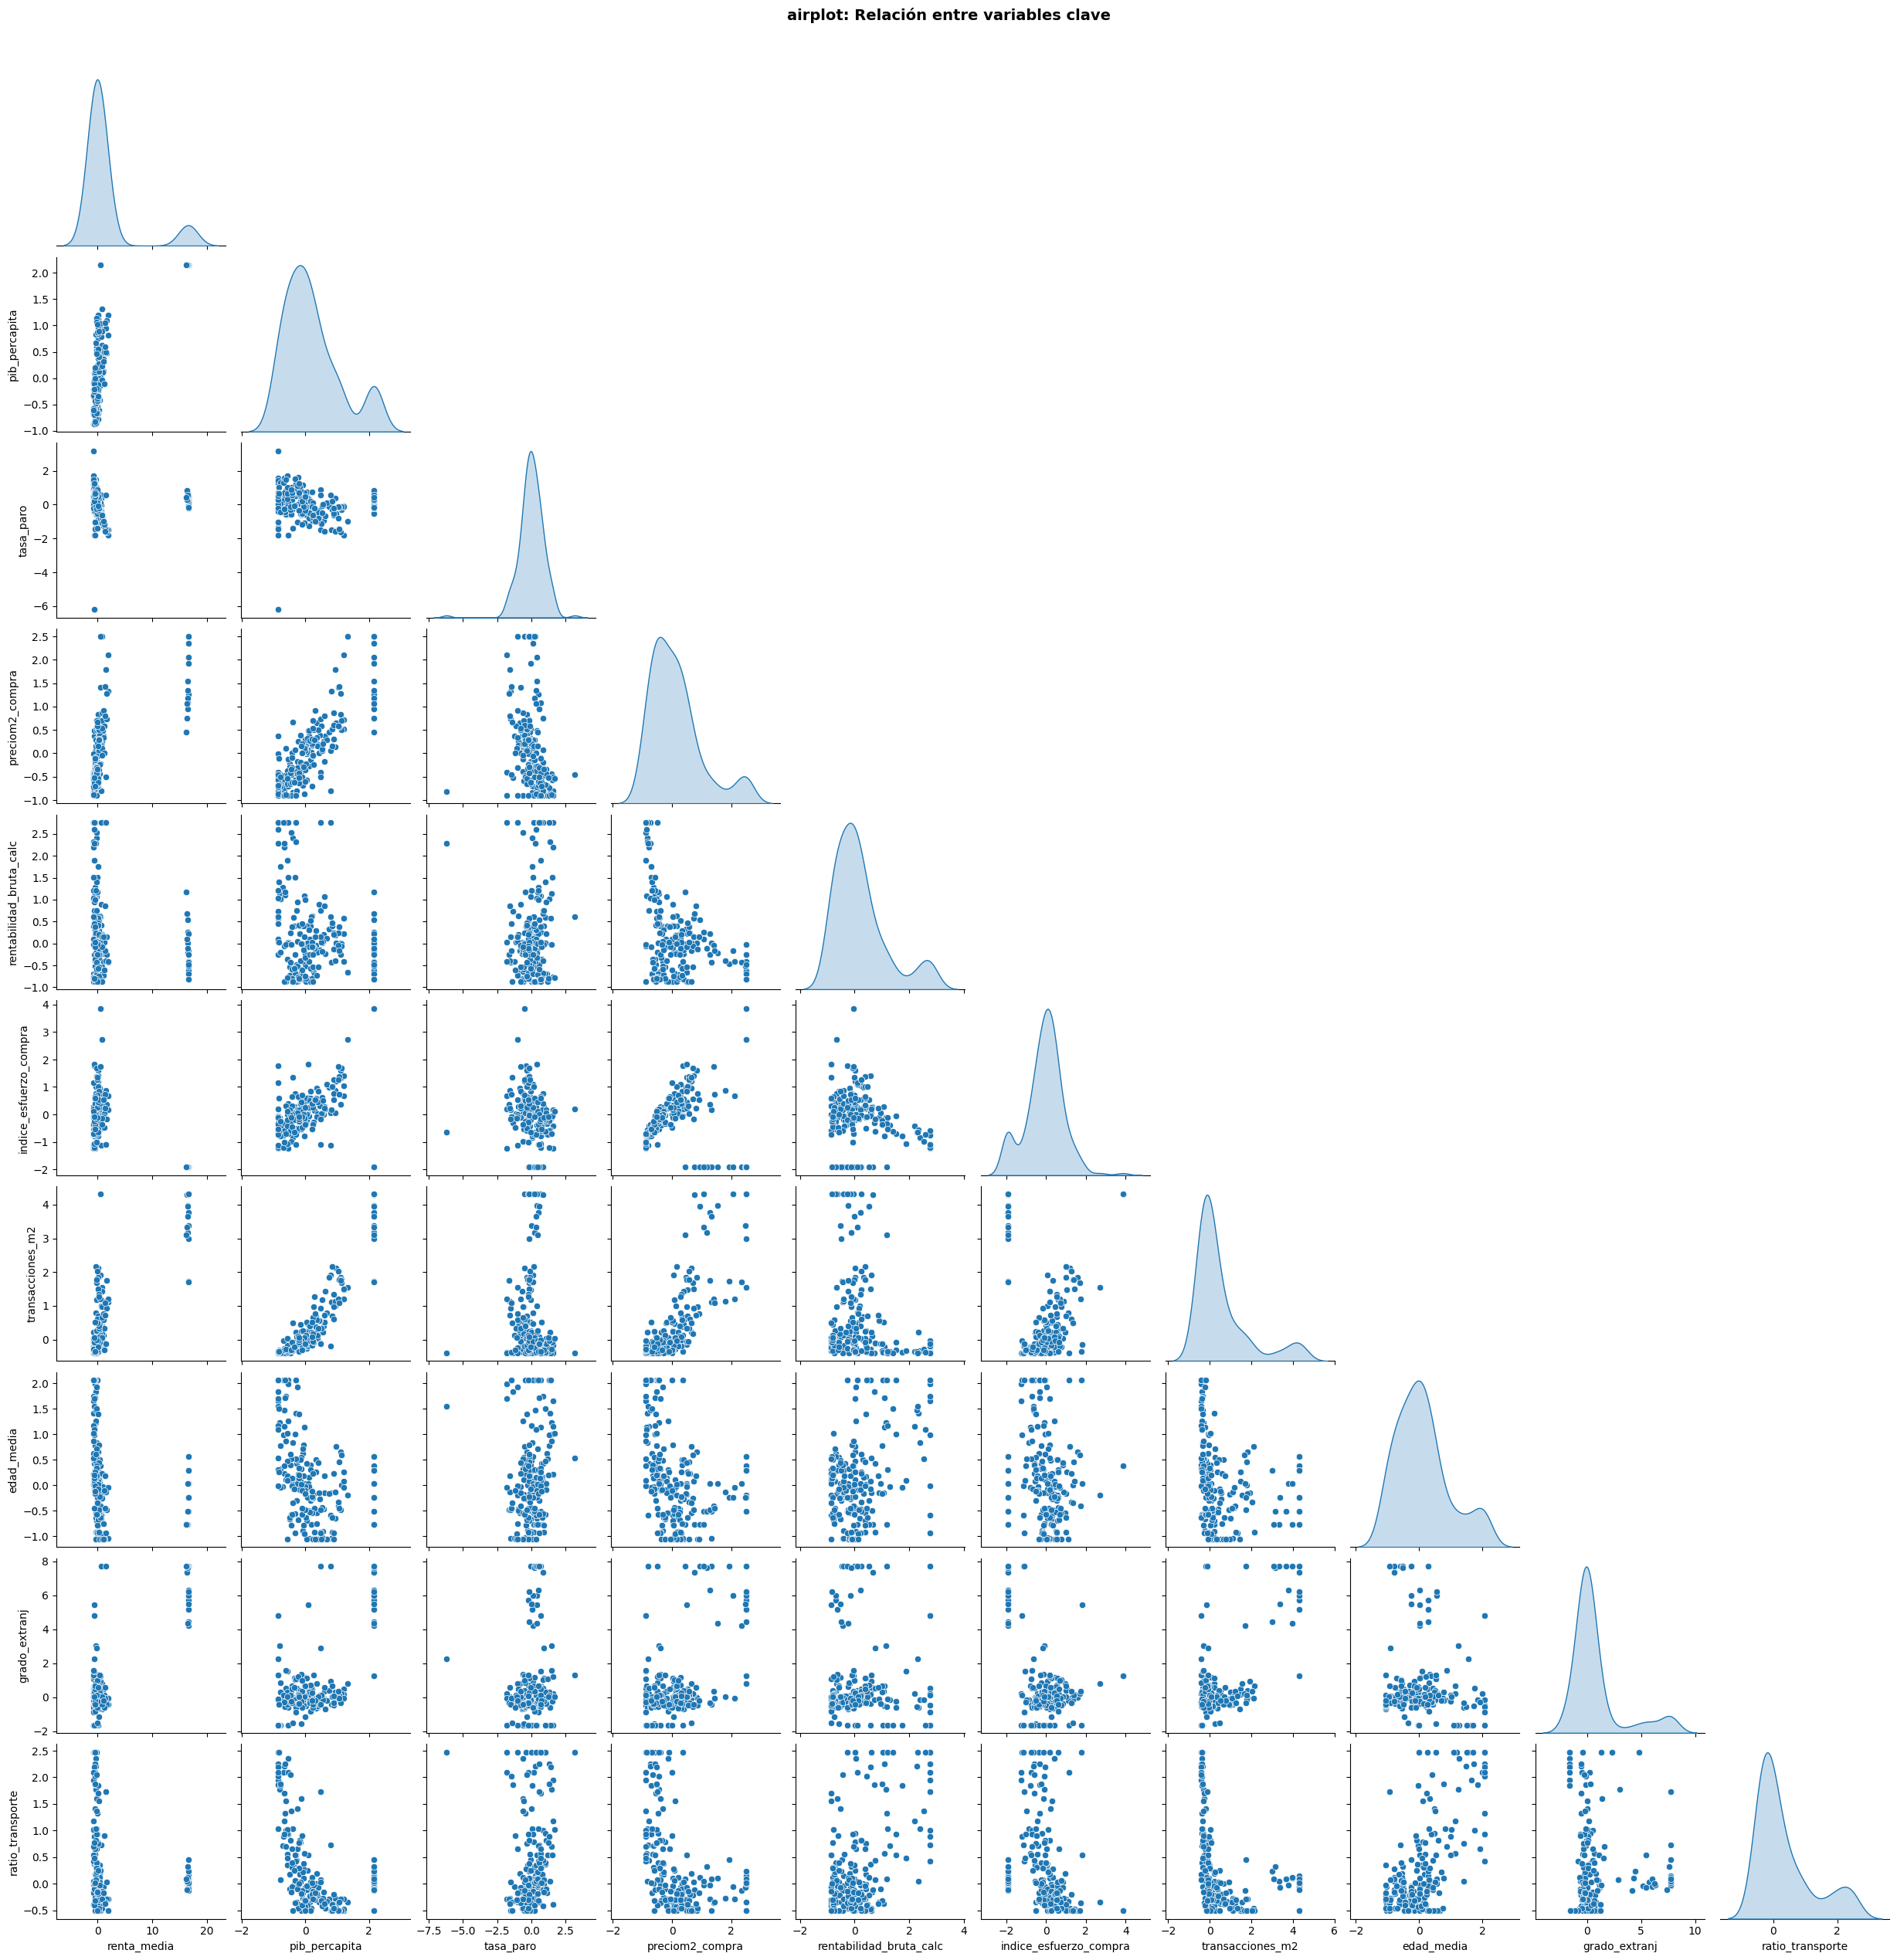

In [ ]:
# --------- PAIRPLOTS ---------
# Subconjunto de variables numéricas clave
variables_pairplot = [
    'renta_media',
    'pib_percapita',
    'tasa_paro',
    'preciom2_compra',
    'rentabilidad_bruta_calc',
    'indice_esfuerzo_compra',
    'transacciones_m2',
    'edad_media',
    'grado_extranj',
    'ratio_transporte'
]

# Generar pairplot
sns.pairplot(df_completo[variables_pairplot], diag_kind="kde", corner=True)
plt.suptitle("airplot: Relación entre variables clave", y=1.02, fontsize=14, fontweight='bold')
plt.show()


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Ruta al archivo .shp (asegúrate que el nombre coincide exactamente)
ruta = "/content/recintos_municipales_inspire_peninbal_etrs89.shp"

# Cargar shapefile completo
gdf = gpd.read_file(ruta)

# Visualiza las columnas disponibles (opcional para saber cómo filtrar)
print(gdf.columns)

# Ver algunas filas para identificar la columna del código de provincia
print(gdf.head())


Index(['INSPIREID', 'COUNTRY', 'NATLEV', 'NATLEVNAME', 'NATCODE', 'NAMEUNIT',
       'CODNUT1', 'CODNUT2', 'CODNUT3', 'geometry'],
      dtype='object')
                  INSPIREID COUNTRY  \
0  ES.IGN.BDDAE.34040707901      ES   
1  ES.IGN.BDDAE.34040707902      ES   
2  ES.IGN.BDDAE.34164848057      ES   
3  ES.IGN.BDDAE.34164848058      ES   
4  ES.IGN.BDDAE.34164848059      ES   

                                              NATLEV NATLEVNAME      NATCODE  \
0  https://inspire.ec.europa.eu/codelist/Administ...  Municipio  34040707901   
1  https://inspire.ec.europa.eu/codelist/Administ...  Municipio  34040707902   
2  https://inspire.ec.europa.eu/codelist/Administ...  Municipio  34164848057   
3  https://inspire.ec.europa.eu/codelist/Administ...  Municipio  34164848058   
4  https://inspire.ec.europa.eu/codelist/Administ...  Municipio  34164848059   

          NAMEUNIT CODNUT1 CODNUT2 CODNUT3  \
0           Ariany     ES5    ES53   ES532   
1  Es Migjorn Gran     ES5    ES53   ES

In [ ]:
# Verifica valores únicos primero (opcional)
print(gdf['CODNUT3'].unique())

# Filtrar por CODNUT3 correspondiente a Madrid
gdf_madrid = gdf[gdf['CODNUT3'] == 'ES300']

# Confirmamos
print(f"Total municipios seleccionados: {len(gdf_madrid)}")
gdf_madrid.head()

['ES532' 'ES533' 'ES213' 'ES220' 'ES211' 'ES230' 'ES113' 'ES130' 'ES114'
 'ES432' 'ES212' 'ES300' 'ES112' 'ES620' 'ES611' 'ES612' 'ES613' 'ES614'
 'ES615' 'ES616' 'ES617' 'ES618' 'ES241' 'ES242' 'ES243' 'ES120' 'ES531'
 'ES431' 'ES411' 'ES412' 'ES413' 'ES414' 'ES415' 'ES111' 'ES416' 'ES417'
 'ES418' 'ES419' 'ES421' 'ES422' 'ES630' 'ES640' None 'ES423' 'ES424'
 'ES425' 'ES511' 'ES512' 'ES513' 'ES514' 'ES521' 'ES522' 'ES523']
Total municipios seleccionados: 181


INSPIREID COUNTRY  \
183  ES.IGN.BDDAE.34132828049      ES   
184  ES.IGN.BDDAE.34132828050      ES   
185  ES.IGN.BDDAE.34132828051      ES   
186  ES.IGN.BDDAE.34132828052      ES   
187  ES.IGN.BDDAE.34132828053      ES   

                                                NATLEV NATLEVNAME  \
183  https://inspire.ec.europa.eu/codelist/Administ...  Municipio   
184  https://inspire.ec.europa.eu/codelist/Administ...  Municipio   
185  https://inspire.ec.europa.eu/codelist/Administ...  Municipio   
186  https://inspire.ec.europa.eu/codelist/Administ...  Municipio   
187  https://inspire.ec.europa.eu/codelist/Administ...  Municipio   

         NATCODE           NAMEUNIT CODNUT1 CODNUT2 CODNUT3  \
183  34132828049            Coslada     ES3    ES30   ES300   
184  34132828050  Cubas de la Sagra     ES3    ES30   ES300   
185  34132828051         Chapinería     ES3    ES30   ES300   
186  34132828052           Chinchón     ES3    ES30   ES300   
187  34132828053  Daganzo de Arriba     ES3    ES30   ES300   

                                              geometry  
183  POLYGON ((-3.53119 40.42008, -3.53023 40.41471...  
184  POLYGON ((-3.87632 40.19122, -3.87623 40.19123...  
185  POLYGON ((-4.23555 40.39329, -4.23396 40.39376...  
186  POLYGON ((-3.58093 40.09899, -3.58075 40.10069...  
187  POLYGON ((-3.48098 40.56217, -3.48022 40.56407...

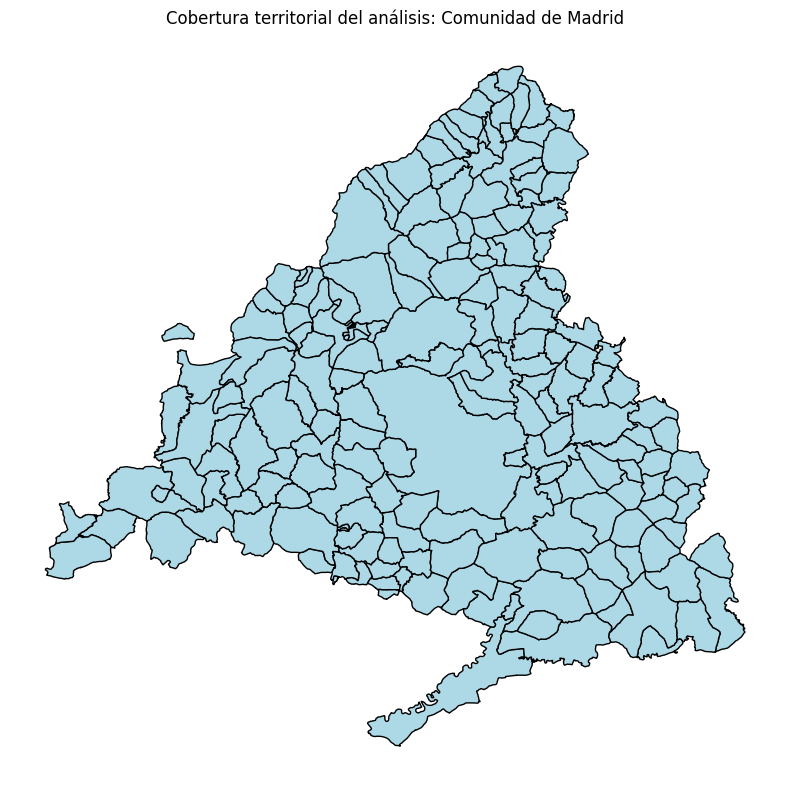

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))
gdf_madrid.plot(ax=ax, color='lightblue', edgecolor='black')
ax.set_title('Cobertura territorial del análisis: Comunidad de Madrid', fontsize=12)
ax.set_aspect('auto')  # evita errores de aspecto
ax.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# Revisar si hay valores duplicados
print(gdf_madrid['NAMEUNIT'].value_counts())

# Contar valores únicos reales
print("Municipios únicos:", gdf_madrid['NAMEUNIT'].nunique())


NAMEUNIT
Coslada                          1
Cubas de la Sagra                1
Chapinería                       1
Chinchón                         1
Daganzo de Arriba                1
                                ..
Villavieja del Lozoya            1
Zarzalejo                        1
Lozoyuela-Navas-Sieteiglesias    1
Puentes Viejas                   1
Tres Cantos                      1
Name: count, Length: 181, dtype: int64
Municipios únicos: 181


In [ ]:
gdf_madrid = gdf_madrid[gdf_madrid['NAMEUNIT'].notna()]

# Lista oficial de nombres válidos (puedes cargarla desde un CSV o copiar aquí manualmente si lo necesitas)
# Por ahora, lo más rápido: ordenamos por nombre y nos quedamos con los primeros 179
gdf_madrid_filtrado = gdf_madrid.sort_values('NAMEUNIT').head(179)

# Verificamos
print("Municipios seleccionados:", gdf_madrid_filtrado.shape[0])


Municipios seleccionados: 179
